Here we'll first be loading the FC matrices and explore their structure

In [6]:
#using read_dataset from Datasets/FC/create_dataset.py to read the dataset
from Datasets.FC.create_dataset import read_dataset_MDD
import torch 
print('GPU available?', torch.cuda.is_available())

GPU available? True


In [7]:
dataset = read_dataset_MDD()

In [8]:
#ok, let's explore the data a bit more
#dataset is a list object of torch_geometric.data objects

#let's see the first element
print(dataset[0])

#it's a dictionary object, let's see the keys
print(dataset[0].keys())

#ok, let's see the values
print(dataset[0].values())

#it has 4 keys, 'x', 'edge_index', 'edge_attr' and 'y' where y=0 menas the patient is healthy and y=1 means the patient has MDD
"""graph = Data(x=ROI.reshape(-1,116).float(),
                     edge_index=G.indices().reshape(2,-1).long(),
                     edge_attr=G.values().reshape(-1,1).float(),
                     y=y.long())"""

#how much data do we have?
print('Number of samples:', len(dataset))


Data(x=[116, 116], edge_index=[2, 1294], edge_attr=[1294, 1], y=[1])
['y', 'edge_attr', 'edge_index', 'x']
ValuesView({'x': tensor([[ 0.0000,  0.2857,  0.0804,  ...,  0.2032,  0.1674,  0.0906],
        [ 0.2857,  0.0000, -0.3860,  ...,  0.1637, -0.0359,  0.1674],
        [ 0.0804, -0.3860,  0.0000,  ..., -0.0175, -0.0309,  0.0296],
        ...,
        [ 0.2032,  0.1637, -0.0175,  ...,  0.0000,  0.2329, -0.1452],
        [ 0.1674, -0.0359, -0.0309,  ...,  0.2329,  0.0000,  0.0183],
        [ 0.0906,  0.1674,  0.0296,  ..., -0.1452,  0.0183,  0.0000]]), 'edge_index': tensor([[  0,   0,   0,  ..., 113, 113, 114],
        [ 10,  12,  14,  ..., 111, 112, 108]]), 'edge_attr': tensor([[0.7785],
        [0.6966],
        [0.5463],
        ...,
        [0.6415],
        [0.4745],
        [0.5401]]), 'y': tensor([0])})
Number of samples: 1604


In [9]:
#set the seed
import torch
torch.manual_seed(0)

MODEL = "GCN"
DATASET = "FC_MDD"

from models.models_FC import GCN_framework_wo_edge_weight as framework # import the model

gnn = framework(dataset,device="cpu")

print(gnn.model)
print(gnn.train_idx)

Net(
  (conv_layers): ModuleList(
    (0): GCNConv(116, 128)
    (1): GCNConv(128, 128)
    (2): GCNConv(128, 128)
    (3): GCNConv(128, 128)
    (4): GCNConv(128, 128)
  )
  (batch_norms): ModuleList(
    (0): BatchNorm(128)
    (1): BatchNorm(128)
    (2): BatchNorm(128)
    (3): BatchNorm(128)
    (4): BatchNorm(128)
  )
  (lin1): Linear(128, 128, bias=True)
  (lin2): Linear(128, 2, bias=True)
  (bn1): BatchNorm(128)
  (bn2): BatchNorm(2)
)
tensor([1365,  984, 1017,  ...,  260,  678,   83])


c:\Users\tomdu\miniconda3\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [11]:
# gnn.iterate()

Epoch: 020, Loss: 0.111, Test Loss: 0.663, Train Acc: 1.000 Test Acc: 0.642
Epoch: 040, Loss: 0.092, Test Loss: 0.654, Train Acc: 1.000 Test Acc: 0.642
Epoch: 060, Loss: 0.077, Test Loss: 0.667, Train Acc: 1.000 Test Acc: 0.642
Epoch: 080, Loss: 0.071, Test Loss: 0.680, Train Acc: 1.000 Test Acc: 0.642
Epoch: 100, Loss: 0.065, Test Loss: 0.668, Train Acc: 1.000 Test Acc: 0.630
Epoch: 120, Loss: 0.061, Test Loss: 0.677, Train Acc: 1.000 Test Acc: 0.642
Epoch: 140, Loss: 0.060, Test Loss: 0.677, Train Acc: 1.000 Test Acc: 0.642


In [10]:
#gnn.train()

In [12]:
#save the model 
#gnn.save_model(path="models/"+DATASET+"_"+MODEL+"server.pt")

Model saved in: models/FC_MDD_GCNserver.pt


In [9]:
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+"server.pt")

In [8]:
#save the model 
#gnn.save_model(path="models/"+DATASET+"_"+MODEL+"server.pt")

In [11]:
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+"server_gpu.pt")

In [12]:
gnn.evaluate()

Test Loss: 0.677, Train Acc: 1.000 Test Acc: 0.642


In [13]:
train_features, test_features = gnn.evaluate_with_features2()

In [14]:
print(len(train_features[0]))
len(train_features), len(test_features)

8


(1523, 81)

In [15]:
import pickle as pkl
import networkx as nx

def calculate_avg_path_length(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        # Alternative metrics for disconnected graphs
        # Option 1: Use the average path length of the largest connected component
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.average_shortest_path_length(largest_component)
    
def calculate_small_world(G):
    if nx.is_connected(G):
        return nx.algorithms.smallworld.sigma(G)
    else:
        # Alternative metrics for disconnected graphs
        # Option 1: Use the small world coefficient of the largest connected component
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.algorithms.smallworld.sigma(largest_component)
    
def compute_swi(graph):
    # Calculate clustering coefficient and average path length for the given graph
    clustering_coeff = nx.average_clustering(graph)
    avg_path_len = calculate_avg_path_length(graph)
    
    # Generate a random graph with the same number of nodes and edges
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    random_graph = nx.gnm_random_graph(num_nodes, num_edges)
    
    # Generate a lattice graph with the same number of nodes and edges
    lattice_graph = nx.watts_strogatz_graph(num_nodes, k=4, p=0)  # Adjust k as needed
    
    # Calculate clustering coefficient and average path length for the random graph
    random_clustering_coeff = nx.average_clustering(random_graph)
    random_avg_path_len = calculate_avg_path_length(random_graph)
    
    # Calculate clustering coefficient and average path length for the lattice graph
    lattice_clustering_coeff = nx.average_clustering(lattice_graph)
    lattice_avg_path_len = calculate_avg_path_length(lattice_graph)
    
    # Compute the Small-World Index (SWI)
    swi = ((avg_path_len - lattice_avg_path_len) / (random_avg_path_len - lattice_avg_path_len)) * \
          ((clustering_coeff - random_clustering_coeff) / (lattice_clustering_coeff - random_clustering_coeff))
    
    return swi
    

def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        density = nx.density(G)
        avg_path_len = calculate_avg_path_length(G)
        num_cliques = len(list(nx.find_cliques(G)))
        num_triangles = sum(nx.triangles(G).values()) / 3
        num_squares = sum(nx.square_clustering(G).values()) / 4
        number_of_node_in_the_largest_fully_connected_component = len(max(nx.connected_components(G), key=len))
        assortativity = nx.degree_assortativity_coefficient(G)
        small_world = compute_swi(G)
            
        properties.append((num_nodes, num_edges, density, avg_path_len, num_cliques, num_triangles, num_squares, number_of_node_in_the_largest_fully_connected_component, assortativity, small_world))
    return properties

train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties = compute_graph_properties(selected_dataset)

# Save the properties to files
with open("results/"+DATASET+"_"+MODEL+"_train_properties_with_sm.pkl", "wb") as f:
    pkl.dump(train_properties, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_with_sm.pkl", "wb") as f:
    pkl.dump(test_properties, f)

In [16]:
print(len(train_properties))
train_properties[0:5]



1523


[(116,
  488,
  0.07316341829085457,
  3.314842578710645,
  148,
  938.0,
  6.439699892510922,
  116),
 (114,
  598,
  0.0928427262847384,
  3.166744294364229,
  164,
  1378.0,
  7.519630514954544,
  114),
 (114,
  408,
  0.06334420121099209,
  3.391864617295451,
  135,
  511.0,
  5.279502013122494,
  114),
 (115,
  744,
  0.11350114416475973,
  2.796796338672769,
  198,
  1870.0,
  7.980704583203741,
  115),
 (112,
  706,
  0.11357786357786358,
  3.3745173745173744,
  181,
  2528.0,
  9.050100863174576,
  112)]

In [17]:
import pickle as pkl
# save the properties in a file
# with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "wb") as f:
#     pkl.dump(train_properties, f)

# with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "wb") as f:
#     pkl.dump(test_properties, f)

#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties_with_sm.pkl", "rb") as f:
    train_properties = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_with_sm.pkl", "rb") as f:
    test_properties = pkl.load(f)

In [18]:
"""
The embeddings of GCN are like this:
return F.log_softmax(x7, dim=-1), (x1, x2, x3, x4, x5, x_global, x6, x7)
"""


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
#train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x4 = np.array([feat[3] for feat in train_features])
test_x4 = np.array([feat[3] for feat in test_features])

train_x5 = np.array([feat[4] for feat in train_features])
test_x5 = np.array([feat[4] for feat in test_features])

train_x_global = np.array([feat[5] for feat in train_features])
test_x_global = np.array([feat[5] for feat in test_features])

train_x6 = np.array([feat[6] for feat in train_features])
test_x6 = np.array([feat[6] for feat in test_features])

train_x7 = np.array([feat[7] for feat in train_features])
test_x7 = np.array([feat[7] for feat in test_features])

# Compute graph properties
# train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
# test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x6 = torch.tensor(test_x6, dtype=torch.float32)
test_x7 = torch.tensor(test_x7, dtype=torch.float32)

train_y = torch.tensor(train_properties, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component', 'assortativity', 'small_world']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x5, test_x5), (train_x_global, test_x_global), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

In [20]:
#create a dictionary where we will sotre the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 500000  # Adjust this as needed

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Adjust this for more frequent/lower print frequency
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embdedding = embeddings_names[ii]
            results[(name_of_embdedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results.pkl", "wb") as f:
    pkl.dump(results, f)

Epoch [1000/500000], Property: num_nodes, Loss: 11624.9824
Epoch [2000/500000], Property: num_nodes, Loss: 10502.0410
Epoch [3000/500000], Property: num_nodes, Loss: 9531.1025
Epoch [4000/500000], Property: num_nodes, Loss: 8680.4258
Epoch [5000/500000], Property: num_nodes, Loss: 7929.2969
Epoch [6000/500000], Property: num_nodes, Loss: 7264.3770
Epoch [7000/500000], Property: num_nodes, Loss: 6676.3281
Epoch [8000/500000], Property: num_nodes, Loss: 6158.7349
Epoch [9000/500000], Property: num_nodes, Loss: 5705.3633
Epoch [10000/500000], Property: num_nodes, Loss: 5308.6855
Epoch [11000/500000], Property: num_nodes, Loss: 4962.2534
Epoch [12000/500000], Property: num_nodes, Loss: 4660.2222
Epoch [13000/500000], Property: num_nodes, Loss: 4396.0117
Epoch [14000/500000], Property: num_nodes, Loss: 4163.7397
Epoch [15000/500000], Property: num_nodes, Loss: 3958.3645
Epoch [16000/500000], Property: num_nodes, Loss: 3775.4065
Epoch [17000/500000], Property: num_nodes, Loss: 3611.0925
Epoc

Epoch [142000/500000], Property: num_nodes, Loss: 5.2219
Epoch [143000/500000], Property: num_nodes, Loss: 5.2219
Epoch [144000/500000], Property: num_nodes, Loss: 5.2219
Epoch [145000/500000], Property: num_nodes, Loss: 5.2219
Epoch [146000/500000], Property: num_nodes, Loss: 5.2219
Epoch [147000/500000], Property: num_nodes, Loss: 5.2219
Epoch [148000/500000], Property: num_nodes, Loss: 5.2219
Epoch [149000/500000], Property: num_nodes, Loss: 5.2219
Epoch [150000/500000], Property: num_nodes, Loss: 5.2219
Epoch [151000/500000], Property: num_nodes, Loss: 5.2219
Epoch [152000/500000], Property: num_nodes, Loss: 5.2219
Epoch [153000/500000], Property: num_nodes, Loss: 5.2219
Epoch [154000/500000], Property: num_nodes, Loss: 5.2219
Epoch [155000/500000], Property: num_nodes, Loss: 5.2219
Epoch [156000/500000], Property: num_nodes, Loss: 5.2219
Epoch [157000/500000], Property: num_nodes, Loss: 5.2219
Epoch [158000/500000], Property: num_nodes, Loss: 5.2219
Epoch [159000/500000], Property

Epoch [286000/500000], Property: num_nodes, Loss: 5.2219
Epoch [287000/500000], Property: num_nodes, Loss: 5.2219
Epoch [288000/500000], Property: num_nodes, Loss: 5.2219
Epoch [289000/500000], Property: num_nodes, Loss: 5.2219
Epoch [290000/500000], Property: num_nodes, Loss: 5.2219
Epoch [291000/500000], Property: num_nodes, Loss: 5.2219
Epoch [292000/500000], Property: num_nodes, Loss: 5.2219
Epoch [293000/500000], Property: num_nodes, Loss: 5.2219
Epoch [294000/500000], Property: num_nodes, Loss: 5.2219
Epoch [295000/500000], Property: num_nodes, Loss: 5.2219
Epoch [296000/500000], Property: num_nodes, Loss: 5.2219
Epoch [297000/500000], Property: num_nodes, Loss: 5.2219
Epoch [298000/500000], Property: num_nodes, Loss: 5.2219
Epoch [299000/500000], Property: num_nodes, Loss: 5.2219
Epoch [300000/500000], Property: num_nodes, Loss: 5.2219
Epoch [301000/500000], Property: num_nodes, Loss: 5.2219
Epoch [302000/500000], Property: num_nodes, Loss: 5.2219
Epoch [303000/500000], Property

Epoch [430000/500000], Property: num_nodes, Loss: 5.2219
Epoch [431000/500000], Property: num_nodes, Loss: 5.2219
Epoch [432000/500000], Property: num_nodes, Loss: 5.2219
Epoch [433000/500000], Property: num_nodes, Loss: 5.2219
Epoch [434000/500000], Property: num_nodes, Loss: 5.2219
Epoch [435000/500000], Property: num_nodes, Loss: 5.2219
Epoch [436000/500000], Property: num_nodes, Loss: 5.2219
Epoch [437000/500000], Property: num_nodes, Loss: 5.2219
Epoch [438000/500000], Property: num_nodes, Loss: 5.2219
Epoch [439000/500000], Property: num_nodes, Loss: 5.2219
Epoch [440000/500000], Property: num_nodes, Loss: 5.2219
Epoch [441000/500000], Property: num_nodes, Loss: 5.2219
Epoch [442000/500000], Property: num_nodes, Loss: 5.2219
Epoch [443000/500000], Property: num_nodes, Loss: 5.2219
Epoch [444000/500000], Property: num_nodes, Loss: 5.2219
Epoch [445000/500000], Property: num_nodes, Loss: 5.2219
Epoch [446000/500000], Property: num_nodes, Loss: 5.2219
Epoch [447000/500000], Property

Epoch [68000/500000], Property: num_edges, Loss: 91217.0859
Epoch [69000/500000], Property: num_edges, Loss: 90401.8672
Epoch [70000/500000], Property: num_edges, Loss: 89608.0234
Epoch [71000/500000], Property: num_edges, Loss: 88834.9219
Epoch [72000/500000], Property: num_edges, Loss: 88081.7422
Epoch [73000/500000], Property: num_edges, Loss: 87347.8594
Epoch [74000/500000], Property: num_edges, Loss: 86632.4297
Epoch [75000/500000], Property: num_edges, Loss: 85934.7266
Epoch [76000/500000], Property: num_edges, Loss: 85253.7344
Epoch [77000/500000], Property: num_edges, Loss: 84588.5859
Epoch [78000/500000], Property: num_edges, Loss: 83938.8359
Epoch [79000/500000], Property: num_edges, Loss: 83304.2812
Epoch [80000/500000], Property: num_edges, Loss: 82684.6719
Epoch [81000/500000], Property: num_edges, Loss: 82079.6250
Epoch [82000/500000], Property: num_edges, Loss: 81488.6797
Epoch [83000/500000], Property: num_edges, Loss: 80911.1484
Epoch [84000/500000], Property: num_edge

Epoch [203000/500000], Property: num_edges, Loss: 45087.3906
Epoch [204000/500000], Property: num_edges, Loss: 44887.0195
Epoch [205000/500000], Property: num_edges, Loss: 44687.2539
Epoch [206000/500000], Property: num_edges, Loss: 44488.1211
Epoch [207000/500000], Property: num_edges, Loss: 44289.6055
Epoch [208000/500000], Property: num_edges, Loss: 44091.7148
Epoch [209000/500000], Property: num_edges, Loss: 43894.4492
Epoch [210000/500000], Property: num_edges, Loss: 43697.8125
Epoch [211000/500000], Property: num_edges, Loss: 43501.7930
Epoch [212000/500000], Property: num_edges, Loss: 43306.3984
Epoch [213000/500000], Property: num_edges, Loss: 43111.6211
Epoch [214000/500000], Property: num_edges, Loss: 42917.4688
Epoch [215000/500000], Property: num_edges, Loss: 42723.9492
Epoch [216000/500000], Property: num_edges, Loss: 42531.0508
Epoch [217000/500000], Property: num_edges, Loss: 42338.7695
Epoch [218000/500000], Property: num_edges, Loss: 42147.1133
Epoch [219000/500000], P

Epoch [338000/500000], Property: num_edges, Loss: 23532.3516
Epoch [339000/500000], Property: num_edges, Loss: 23415.1211
Epoch [340000/500000], Property: num_edges, Loss: 23298.5312
Epoch [341000/500000], Property: num_edges, Loss: 23182.5879
Epoch [342000/500000], Property: num_edges, Loss: 23067.2832
Epoch [343000/500000], Property: num_edges, Loss: 22952.6250
Epoch [344000/500000], Property: num_edges, Loss: 22838.6074
Epoch [345000/500000], Property: num_edges, Loss: 22725.2344
Epoch [346000/500000], Property: num_edges, Loss: 22612.5020
Epoch [347000/500000], Property: num_edges, Loss: 22500.4121
Epoch [348000/500000], Property: num_edges, Loss: 22388.9648
Epoch [349000/500000], Property: num_edges, Loss: 22278.1641
Epoch [350000/500000], Property: num_edges, Loss: 22168.0020
Epoch [351000/500000], Property: num_edges, Loss: 22058.4824
Epoch [352000/500000], Property: num_edges, Loss: 21949.6094
Epoch [353000/500000], Property: num_edges, Loss: 21841.3750
Epoch [354000/500000], P

Epoch [473000/500000], Property: num_edges, Loss: 13588.2246
Epoch [474000/500000], Property: num_edges, Loss: 13557.3232
Epoch [475000/500000], Property: num_edges, Loss: 13527.0254
Epoch [476000/500000], Property: num_edges, Loss: 13497.3320
Epoch [477000/500000], Property: num_edges, Loss: 13468.2412
Epoch [478000/500000], Property: num_edges, Loss: 13439.7559
Epoch [479000/500000], Property: num_edges, Loss: 13411.8750
Epoch [480000/500000], Property: num_edges, Loss: 13384.6006
Epoch [481000/500000], Property: num_edges, Loss: 13357.9268
Epoch [482000/500000], Property: num_edges, Loss: 13331.8584
Epoch [483000/500000], Property: num_edges, Loss: 13306.3955
Epoch [484000/500000], Property: num_edges, Loss: 13281.5361
Epoch [485000/500000], Property: num_edges, Loss: 13257.2832
Epoch [486000/500000], Property: num_edges, Loss: 13233.6318
Epoch [487000/500000], Property: num_edges, Loss: 13210.5869
Epoch [488000/500000], Property: num_edges, Loss: 13188.1436
Epoch [489000/500000], P

Epoch [119000/500000], Property: density, Loss: 0.0003
Epoch [120000/500000], Property: density, Loss: 0.0003
Epoch [121000/500000], Property: density, Loss: 0.0003
Epoch [122000/500000], Property: density, Loss: 0.0003
Epoch [123000/500000], Property: density, Loss: 0.0003
Epoch [124000/500000], Property: density, Loss: 0.0003
Epoch [125000/500000], Property: density, Loss: 0.0003
Epoch [126000/500000], Property: density, Loss: 0.0003
Epoch [127000/500000], Property: density, Loss: 0.0003
Epoch [128000/500000], Property: density, Loss: 0.0003
Epoch [129000/500000], Property: density, Loss: 0.0003
Epoch [130000/500000], Property: density, Loss: 0.0003
Epoch [131000/500000], Property: density, Loss: 0.0003
Epoch [132000/500000], Property: density, Loss: 0.0003
Epoch [133000/500000], Property: density, Loss: 0.0003
Epoch [134000/500000], Property: density, Loss: 0.0003
Epoch [135000/500000], Property: density, Loss: 0.0003
Epoch [136000/500000], Property: density, Loss: 0.0003
Epoch [137

Epoch [268000/500000], Property: density, Loss: 0.0003
Epoch [269000/500000], Property: density, Loss: 0.0003
Epoch [270000/500000], Property: density, Loss: 0.0003
Epoch [271000/500000], Property: density, Loss: 0.0003
Epoch [272000/500000], Property: density, Loss: 0.0003
Epoch [273000/500000], Property: density, Loss: 0.0003
Epoch [274000/500000], Property: density, Loss: 0.0003
Epoch [275000/500000], Property: density, Loss: 0.0003
Epoch [276000/500000], Property: density, Loss: 0.0003
Epoch [277000/500000], Property: density, Loss: 0.0003
Epoch [278000/500000], Property: density, Loss: 0.0003
Epoch [279000/500000], Property: density, Loss: 0.0003
Epoch [280000/500000], Property: density, Loss: 0.0003
Epoch [281000/500000], Property: density, Loss: 0.0003
Epoch [282000/500000], Property: density, Loss: 0.0003
Epoch [283000/500000], Property: density, Loss: 0.0003
Epoch [284000/500000], Property: density, Loss: 0.0003
Epoch [285000/500000], Property: density, Loss: 0.0003
Epoch [286

Epoch [417000/500000], Property: density, Loss: 0.0003
Epoch [418000/500000], Property: density, Loss: 0.0003
Epoch [419000/500000], Property: density, Loss: 0.0003
Epoch [420000/500000], Property: density, Loss: 0.0003
Epoch [421000/500000], Property: density, Loss: 0.0003
Epoch [422000/500000], Property: density, Loss: 0.0003
Epoch [423000/500000], Property: density, Loss: 0.0003
Epoch [424000/500000], Property: density, Loss: 0.0003
Epoch [425000/500000], Property: density, Loss: 0.0003
Epoch [426000/500000], Property: density, Loss: 0.0003
Epoch [427000/500000], Property: density, Loss: 0.0003
Epoch [428000/500000], Property: density, Loss: 0.0003
Epoch [429000/500000], Property: density, Loss: 0.0003
Epoch [430000/500000], Property: density, Loss: 0.0003
Epoch [431000/500000], Property: density, Loss: 0.0003
Epoch [432000/500000], Property: density, Loss: 0.0003
Epoch [433000/500000], Property: density, Loss: 0.0003
Epoch [434000/500000], Property: density, Loss: 0.0003
Epoch [435

Epoch [60000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [61000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [62000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [63000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [64000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [65000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [66000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [67000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [68000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [69000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [70000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [71000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [72000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [73000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [74000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [75000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [76000/500000], Property: avg_path_len, Loss: 0.13

Epoch [198000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [199000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [200000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [201000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [202000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [203000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [204000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [205000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [206000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [207000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [208000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [209000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [210000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [211000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [212000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [213000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [214000/500000], Property: avg_pat

Epoch [335000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [336000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [337000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [338000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [339000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [340000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [341000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [342000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [343000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [344000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [345000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [346000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [347000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [348000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [349000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [350000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [351000/500000], Property: avg_pat

Epoch [472000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [473000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [474000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [475000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [476000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [477000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [478000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [479000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [480000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [481000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [482000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [483000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [484000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [485000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [486000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [487000/500000], Property: avg_path_len, Loss: 0.1326
Epoch [488000/500000], Property: avg_pat

Epoch [105000/500000], Property: num_cliques, Loss: 1628.8323
Epoch [106000/500000], Property: num_cliques, Loss: 1593.3804
Epoch [107000/500000], Property: num_cliques, Loss: 1558.5427
Epoch [108000/500000], Property: num_cliques, Loss: 1524.3187
Epoch [109000/500000], Property: num_cliques, Loss: 1490.7086
Epoch [110000/500000], Property: num_cliques, Loss: 1457.7123
Epoch [111000/500000], Property: num_cliques, Loss: 1425.3300
Epoch [112000/500000], Property: num_cliques, Loss: 1393.5614
Epoch [113000/500000], Property: num_cliques, Loss: 1362.4067
Epoch [114000/500000], Property: num_cliques, Loss: 1332.0330
Epoch [115000/500000], Property: num_cliques, Loss: 1302.3319
Epoch [116000/500000], Property: num_cliques, Loss: 1273.2358
Epoch [117000/500000], Property: num_cliques, Loss: 1244.7438
Epoch [118000/500000], Property: num_cliques, Loss: 1216.8561
Epoch [119000/500000], Property: num_cliques, Loss: 1189.5729
Epoch [120000/500000], Property: num_cliques, Loss: 1162.8940
Epoch [1

Epoch [239000/500000], Property: num_cliques, Loss: 587.3209
Epoch [240000/500000], Property: num_cliques, Loss: 587.3209
Epoch [241000/500000], Property: num_cliques, Loss: 587.3209
Epoch [242000/500000], Property: num_cliques, Loss: 587.3210
Epoch [243000/500000], Property: num_cliques, Loss: 587.3210
Epoch [244000/500000], Property: num_cliques, Loss: 587.3210
Epoch [245000/500000], Property: num_cliques, Loss: 587.3209
Epoch [246000/500000], Property: num_cliques, Loss: 587.3209
Epoch [247000/500000], Property: num_cliques, Loss: 587.3209
Epoch [248000/500000], Property: num_cliques, Loss: 587.3209
Epoch [249000/500000], Property: num_cliques, Loss: 587.3210
Epoch [250000/500000], Property: num_cliques, Loss: 587.3209
Epoch [251000/500000], Property: num_cliques, Loss: 587.3209
Epoch [252000/500000], Property: num_cliques, Loss: 587.3209
Epoch [253000/500000], Property: num_cliques, Loss: 587.3209
Epoch [254000/500000], Property: num_cliques, Loss: 587.3210
Epoch [255000/500000], P

Epoch [374000/500000], Property: num_cliques, Loss: 587.3209
Epoch [375000/500000], Property: num_cliques, Loss: 587.3209
Epoch [376000/500000], Property: num_cliques, Loss: 587.3209
Epoch [377000/500000], Property: num_cliques, Loss: 587.3209
Epoch [378000/500000], Property: num_cliques, Loss: 587.3210
Epoch [379000/500000], Property: num_cliques, Loss: 587.3209
Epoch [380000/500000], Property: num_cliques, Loss: 587.3209
Epoch [381000/500000], Property: num_cliques, Loss: 587.3210
Epoch [382000/500000], Property: num_cliques, Loss: 587.3209
Epoch [383000/500000], Property: num_cliques, Loss: 587.3210
Epoch [384000/500000], Property: num_cliques, Loss: 587.3209
Epoch [385000/500000], Property: num_cliques, Loss: 587.3209
Epoch [386000/500000], Property: num_cliques, Loss: 587.3209
Epoch [387000/500000], Property: num_cliques, Loss: 587.3209
Epoch [388000/500000], Property: num_cliques, Loss: 587.3209
Epoch [389000/500000], Property: num_cliques, Loss: 587.3209
Epoch [390000/500000], P

Epoch [6000/500000], Property: num_triangles, Loss: 1302783.1250
Epoch [7000/500000], Property: num_triangles, Loss: 1290812.3750
Epoch [8000/500000], Property: num_triangles, Loss: 1279065.8750
Epoch [9000/500000], Property: num_triangles, Loss: 1267528.6250
Epoch [10000/500000], Property: num_triangles, Loss: 1256192.8750
Epoch [11000/500000], Property: num_triangles, Loss: 1245048.1250
Epoch [12000/500000], Property: num_triangles, Loss: 1234087.1250
Epoch [13000/500000], Property: num_triangles, Loss: 1223305.0000
Epoch [14000/500000], Property: num_triangles, Loss: 1212694.8750
Epoch [15000/500000], Property: num_triangles, Loss: 1202249.1250
Epoch [16000/500000], Property: num_triangles, Loss: 1191957.6250
Epoch [17000/500000], Property: num_triangles, Loss: 1181815.3750
Epoch [18000/500000], Property: num_triangles, Loss: 1171820.8750
Epoch [19000/500000], Property: num_triangles, Loss: 1161972.6250
Epoch [20000/500000], Property: num_triangles, Loss: 1152270.6250
Epoch [21000/5

Epoch [132000/500000], Property: num_triangles, Loss: 634600.4375
Epoch [133000/500000], Property: num_triangles, Loss: 632976.6250
Epoch [134000/500000], Property: num_triangles, Loss: 631376.3750
Epoch [135000/500000], Property: num_triangles, Loss: 629798.7500
Epoch [136000/500000], Property: num_triangles, Loss: 628243.7500
Epoch [137000/500000], Property: num_triangles, Loss: 626710.6875
Epoch [138000/500000], Property: num_triangles, Loss: 625198.3750
Epoch [139000/500000], Property: num_triangles, Loss: 623706.5000
Epoch [140000/500000], Property: num_triangles, Loss: 622234.8125
Epoch [141000/500000], Property: num_triangles, Loss: 620782.5000
Epoch [142000/500000], Property: num_triangles, Loss: 619348.6875
Epoch [143000/500000], Property: num_triangles, Loss: 617933.9375
Epoch [144000/500000], Property: num_triangles, Loss: 616537.1875
Epoch [145000/500000], Property: num_triangles, Loss: 615158.3125
Epoch [146000/500000], Property: num_triangles, Loss: 613796.5000
Epoch [147

Epoch [257000/500000], Property: num_triangles, Loss: 518481.0312
Epoch [258000/500000], Property: num_triangles, Loss: 517925.0312
Epoch [259000/500000], Property: num_triangles, Loss: 517365.0000
Epoch [260000/500000], Property: num_triangles, Loss: 516806.6250
Epoch [261000/500000], Property: num_triangles, Loss: 516251.0625
Epoch [262000/500000], Property: num_triangles, Loss: 515698.1250
Epoch [263000/500000], Property: num_triangles, Loss: 515147.9062
Epoch [264000/500000], Property: num_triangles, Loss: 514600.0938
Epoch [265000/500000], Property: num_triangles, Loss: 514054.8438
Epoch [266000/500000], Property: num_triangles, Loss: 513511.7188
Epoch [267000/500000], Property: num_triangles, Loss: 512970.7500
Epoch [268000/500000], Property: num_triangles, Loss: 512431.8750
Epoch [269000/500000], Property: num_triangles, Loss: 511894.8750
Epoch [270000/500000], Property: num_triangles, Loss: 511359.9062
Epoch [271000/500000], Property: num_triangles, Loss: 510826.7812
Epoch [272

Epoch [382000/500000], Property: num_triangles, Loss: 459234.2812
Epoch [383000/500000], Property: num_triangles, Loss: 458821.2500
Epoch [384000/500000], Property: num_triangles, Loss: 458408.8125
Epoch [385000/500000], Property: num_triangles, Loss: 457997.0000
Epoch [386000/500000], Property: num_triangles, Loss: 457585.8750
Epoch [387000/500000], Property: num_triangles, Loss: 457175.3125
Epoch [388000/500000], Property: num_triangles, Loss: 456765.4375
Epoch [389000/500000], Property: num_triangles, Loss: 456356.2500
Epoch [390000/500000], Property: num_triangles, Loss: 455947.7188
Epoch [391000/500000], Property: num_triangles, Loss: 455539.7188
Epoch [392000/500000], Property: num_triangles, Loss: 455132.5000
Epoch [393000/500000], Property: num_triangles, Loss: 454725.8125
Epoch [394000/500000], Property: num_triangles, Loss: 454319.7500
Epoch [395000/500000], Property: num_triangles, Loss: 453914.4688
Epoch [396000/500000], Property: num_triangles, Loss: 453509.8125
Epoch [397

Epoch [5000/500000], Property: num_squares, Loss: 3.7038
Epoch [6000/500000], Property: num_squares, Loss: 2.6324
Epoch [7000/500000], Property: num_squares, Loss: 1.9116
Epoch [8000/500000], Property: num_squares, Loss: 1.5112
Epoch [9000/500000], Property: num_squares, Loss: 1.3471
Epoch [10000/500000], Property: num_squares, Loss: 1.3078
Epoch [11000/500000], Property: num_squares, Loss: 1.3042
Epoch [12000/500000], Property: num_squares, Loss: 1.3041
Epoch [13000/500000], Property: num_squares, Loss: 1.3041
Epoch [14000/500000], Property: num_squares, Loss: 1.3041
Epoch [15000/500000], Property: num_squares, Loss: 1.3041
Epoch [16000/500000], Property: num_squares, Loss: 1.3041
Epoch [17000/500000], Property: num_squares, Loss: 1.3041
Epoch [18000/500000], Property: num_squares, Loss: 1.3041
Epoch [19000/500000], Property: num_squares, Loss: 1.3041
Epoch [20000/500000], Property: num_squares, Loss: 1.3041
Epoch [21000/500000], Property: num_squares, Loss: 1.3041
Epoch [22000/500000

Epoch [146000/500000], Property: num_squares, Loss: 1.3041
Epoch [147000/500000], Property: num_squares, Loss: 1.3041
Epoch [148000/500000], Property: num_squares, Loss: 1.3041
Epoch [149000/500000], Property: num_squares, Loss: 1.3041
Epoch [150000/500000], Property: num_squares, Loss: 1.3041
Epoch [151000/500000], Property: num_squares, Loss: 1.3041
Epoch [152000/500000], Property: num_squares, Loss: 1.3041
Epoch [153000/500000], Property: num_squares, Loss: 1.3041
Epoch [154000/500000], Property: num_squares, Loss: 1.3041
Epoch [155000/500000], Property: num_squares, Loss: 1.3041
Epoch [156000/500000], Property: num_squares, Loss: 1.3041
Epoch [157000/500000], Property: num_squares, Loss: 1.3041
Epoch [158000/500000], Property: num_squares, Loss: 1.3041
Epoch [159000/500000], Property: num_squares, Loss: 1.3041
Epoch [160000/500000], Property: num_squares, Loss: 1.3041
Epoch [161000/500000], Property: num_squares, Loss: 1.3041
Epoch [162000/500000], Property: num_squares, Loss: 1.30

Epoch [285000/500000], Property: num_squares, Loss: 1.3041
Epoch [286000/500000], Property: num_squares, Loss: 1.3041
Epoch [287000/500000], Property: num_squares, Loss: 1.3041
Epoch [288000/500000], Property: num_squares, Loss: 1.3041
Epoch [289000/500000], Property: num_squares, Loss: 1.3041
Epoch [290000/500000], Property: num_squares, Loss: 1.3041
Epoch [291000/500000], Property: num_squares, Loss: 1.3041
Epoch [292000/500000], Property: num_squares, Loss: 1.3041
Epoch [293000/500000], Property: num_squares, Loss: 1.3041
Epoch [294000/500000], Property: num_squares, Loss: 1.3041
Epoch [295000/500000], Property: num_squares, Loss: 1.3041
Epoch [296000/500000], Property: num_squares, Loss: 1.3041
Epoch [297000/500000], Property: num_squares, Loss: 1.3041
Epoch [298000/500000], Property: num_squares, Loss: 1.3041
Epoch [299000/500000], Property: num_squares, Loss: 1.3041
Epoch [300000/500000], Property: num_squares, Loss: 1.3041
Epoch [301000/500000], Property: num_squares, Loss: 1.30

Epoch [424000/500000], Property: num_squares, Loss: 1.3041
Epoch [425000/500000], Property: num_squares, Loss: 1.3041
Epoch [426000/500000], Property: num_squares, Loss: 1.3041
Epoch [427000/500000], Property: num_squares, Loss: 1.3041
Epoch [428000/500000], Property: num_squares, Loss: 1.3041
Epoch [429000/500000], Property: num_squares, Loss: 1.3041
Epoch [430000/500000], Property: num_squares, Loss: 1.3041
Epoch [431000/500000], Property: num_squares, Loss: 1.3041
Epoch [432000/500000], Property: num_squares, Loss: 1.3041
Epoch [433000/500000], Property: num_squares, Loss: 1.3041
Epoch [434000/500000], Property: num_squares, Loss: 1.3041
Epoch [435000/500000], Property: num_squares, Loss: 1.3041
Epoch [436000/500000], Property: num_squares, Loss: 1.3041
Epoch [437000/500000], Property: num_squares, Loss: 1.3041
Epoch [438000/500000], Property: num_squares, Loss: 1.3041
Epoch [439000/500000], Property: num_squares, Loss: 1.3041
Epoch [440000/500000], Property: num_squares, Loss: 1.30

Epoch [35000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 2020.6349
Epoch [36000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1967.8019
Epoch [37000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1916.0134
Epoch [38000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1865.2805
Epoch [39000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1815.5975
Epoch [40000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1766.9561
Epoch [41000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1719.3433
Epoch [42000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1672.7426
Epoch [43000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1627.1299
Epoch [44000/500000], Property: number_of_node

Epoch [113000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 16.4561
Epoch [114000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 14.5395
Epoch [115000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 13.0942
Epoch [116000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 12.0824
Epoch [117000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.4519
Epoch [118000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.1281
Epoch [119000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0097
Epoch [120000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9863
Epoch [121000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [122000/500000], Property: number_of_nodes_in_the

Epoch [192000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [193000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [194000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [195000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [196000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [197000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [198000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [199000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [200000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [201000/500000], Property: number_of_nodes_in_the

Epoch [271000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [272000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [273000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [274000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [275000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [276000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [277000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [278000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [279000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [280000/500000], Property: number_of_nodes_in_the

Epoch [350000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [351000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [352000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [353000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [354000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [355000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [356000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [357000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [358000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [359000/500000], Property: number_of_nodes_in_the

Epoch [429000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [430000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [431000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [432000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [433000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [434000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [435000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [436000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [437000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9848
Epoch [438000/500000], Property: number_of_nodes_in_the

Epoch [9000/500000], Property: num_nodes, Loss: 4654.7778
Epoch [10000/500000], Property: num_nodes, Loss: 4253.1533
Epoch [11000/500000], Property: num_nodes, Loss: 3905.1301
Epoch [12000/500000], Property: num_nodes, Loss: 3604.7622
Epoch [13000/500000], Property: num_nodes, Loss: 3345.2773
Epoch [14000/500000], Property: num_nodes, Loss: 3120.2588
Epoch [15000/500000], Property: num_nodes, Loss: 2924.3916
Epoch [16000/500000], Property: num_nodes, Loss: 2752.4998
Epoch [17000/500000], Property: num_nodes, Loss: 2600.4678
Epoch [18000/500000], Property: num_nodes, Loss: 2465.7107
Epoch [19000/500000], Property: num_nodes, Loss: 2346.2803
Epoch [20000/500000], Property: num_nodes, Loss: 2240.3430
Epoch [21000/500000], Property: num_nodes, Loss: 2146.2991
Epoch [22000/500000], Property: num_nodes, Loss: 2062.6714
Epoch [23000/500000], Property: num_nodes, Loss: 1987.9414
Epoch [24000/500000], Property: num_nodes, Loss: 1920.7490
Epoch [25000/500000], Property: num_nodes, Loss: 1859.824

Epoch [151000/500000], Property: num_nodes, Loss: 5.2187
Epoch [152000/500000], Property: num_nodes, Loss: 5.2187
Epoch [153000/500000], Property: num_nodes, Loss: 5.2187
Epoch [154000/500000], Property: num_nodes, Loss: 5.2187
Epoch [155000/500000], Property: num_nodes, Loss: 5.2187
Epoch [156000/500000], Property: num_nodes, Loss: 5.2187
Epoch [157000/500000], Property: num_nodes, Loss: 5.2187
Epoch [158000/500000], Property: num_nodes, Loss: 5.2187
Epoch [159000/500000], Property: num_nodes, Loss: 5.2187
Epoch [160000/500000], Property: num_nodes, Loss: 5.2187
Epoch [161000/500000], Property: num_nodes, Loss: 5.2187
Epoch [162000/500000], Property: num_nodes, Loss: 5.2187
Epoch [163000/500000], Property: num_nodes, Loss: 5.2187
Epoch [164000/500000], Property: num_nodes, Loss: 5.2187
Epoch [165000/500000], Property: num_nodes, Loss: 5.2187
Epoch [166000/500000], Property: num_nodes, Loss: 5.2187
Epoch [167000/500000], Property: num_nodes, Loss: 5.2187
Epoch [168000/500000], Property

Epoch [295000/500000], Property: num_nodes, Loss: 5.2187
Epoch [296000/500000], Property: num_nodes, Loss: 5.2187
Epoch [297000/500000], Property: num_nodes, Loss: 5.2187
Epoch [298000/500000], Property: num_nodes, Loss: 5.2187
Epoch [299000/500000], Property: num_nodes, Loss: 5.2187
Epoch [300000/500000], Property: num_nodes, Loss: 5.2187
Epoch [301000/500000], Property: num_nodes, Loss: 5.2187
Epoch [302000/500000], Property: num_nodes, Loss: 5.2187
Epoch [303000/500000], Property: num_nodes, Loss: 5.2187
Epoch [304000/500000], Property: num_nodes, Loss: 5.2187
Epoch [305000/500000], Property: num_nodes, Loss: 5.2187
Epoch [306000/500000], Property: num_nodes, Loss: 5.2187
Epoch [307000/500000], Property: num_nodes, Loss: 5.2187
Epoch [308000/500000], Property: num_nodes, Loss: 5.2187
Epoch [309000/500000], Property: num_nodes, Loss: 5.2187
Epoch [310000/500000], Property: num_nodes, Loss: 5.2187
Epoch [311000/500000], Property: num_nodes, Loss: 5.2187
Epoch [312000/500000], Property

Epoch [439000/500000], Property: num_nodes, Loss: 5.2187
Epoch [440000/500000], Property: num_nodes, Loss: 5.2187
Epoch [441000/500000], Property: num_nodes, Loss: 5.2187
Epoch [442000/500000], Property: num_nodes, Loss: 5.2187
Epoch [443000/500000], Property: num_nodes, Loss: 5.2187
Epoch [444000/500000], Property: num_nodes, Loss: 5.2187
Epoch [445000/500000], Property: num_nodes, Loss: 5.2187
Epoch [446000/500000], Property: num_nodes, Loss: 5.2187
Epoch [447000/500000], Property: num_nodes, Loss: 5.2187
Epoch [448000/500000], Property: num_nodes, Loss: 5.2187
Epoch [449000/500000], Property: num_nodes, Loss: 5.2187
Epoch [450000/500000], Property: num_nodes, Loss: 5.2187
Epoch [451000/500000], Property: num_nodes, Loss: 5.2187
Epoch [452000/500000], Property: num_nodes, Loss: 5.2187
Epoch [453000/500000], Property: num_nodes, Loss: 5.2187
Epoch [454000/500000], Property: num_nodes, Loss: 5.2187
Epoch [455000/500000], Property: num_nodes, Loss: 5.2187
Epoch [456000/500000], Property

Epoch [76000/500000], Property: num_edges, Loss: 63076.5508
Epoch [77000/500000], Property: num_edges, Loss: 62475.3477
Epoch [78000/500000], Property: num_edges, Loss: 61891.7930
Epoch [79000/500000], Property: num_edges, Loss: 61325.3164
Epoch [80000/500000], Property: num_edges, Loss: 60775.8477
Epoch [81000/500000], Property: num_edges, Loss: 60242.9844
Epoch [82000/500000], Property: num_edges, Loss: 59726.1758
Epoch [83000/500000], Property: num_edges, Loss: 59224.4922
Epoch [84000/500000], Property: num_edges, Loss: 58736.9961
Epoch [85000/500000], Property: num_edges, Loss: 58262.9219
Epoch [86000/500000], Property: num_edges, Loss: 57802.0078
Epoch [87000/500000], Property: num_edges, Loss: 57352.6523
Epoch [88000/500000], Property: num_edges, Loss: 56915.6914
Epoch [89000/500000], Property: num_edges, Loss: 56491.3672
Epoch [90000/500000], Property: num_edges, Loss: 56081.2031
Epoch [91000/500000], Property: num_edges, Loss: 55682.9102
Epoch [92000/500000], Property: num_edge

Epoch [211000/500000], Property: num_edges, Loss: 33169.5352
Epoch [212000/500000], Property: num_edges, Loss: 33037.8672
Epoch [213000/500000], Property: num_edges, Loss: 32906.6250
Epoch [214000/500000], Property: num_edges, Loss: 32775.8125
Epoch [215000/500000], Property: num_edges, Loss: 32645.4238
Epoch [216000/500000], Property: num_edges, Loss: 32515.4668
Epoch [217000/500000], Property: num_edges, Loss: 32385.9375
Epoch [218000/500000], Property: num_edges, Loss: 32256.8359
Epoch [219000/500000], Property: num_edges, Loss: 32128.1660
Epoch [220000/500000], Property: num_edges, Loss: 31999.9102
Epoch [221000/500000], Property: num_edges, Loss: 31872.0938
Epoch [222000/500000], Property: num_edges, Loss: 31744.7012
Epoch [223000/500000], Property: num_edges, Loss: 31617.7363
Epoch [224000/500000], Property: num_edges, Loss: 31491.1973
Epoch [225000/500000], Property: num_edges, Loss: 31365.0898
Epoch [226000/500000], Property: num_edges, Loss: 31239.4121
Epoch [227000/500000], P

Epoch [346000/500000], Property: num_edges, Loss: 19163.8438
Epoch [347000/500000], Property: num_edges, Loss: 19089.3633
Epoch [348000/500000], Property: num_edges, Loss: 19015.3203
Epoch [349000/500000], Property: num_edges, Loss: 18941.7188
Epoch [350000/500000], Property: num_edges, Loss: 18868.5605
Epoch [351000/500000], Property: num_edges, Loss: 18795.8418
Epoch [352000/500000], Property: num_edges, Loss: 18723.5625
Epoch [353000/500000], Property: num_edges, Loss: 18651.7305
Epoch [354000/500000], Property: num_edges, Loss: 18580.3320
Epoch [355000/500000], Property: num_edges, Loss: 18509.3770
Epoch [356000/500000], Property: num_edges, Loss: 18438.8672
Epoch [357000/500000], Property: num_edges, Loss: 18368.7949
Epoch [358000/500000], Property: num_edges, Loss: 18299.1641
Epoch [359000/500000], Property: num_edges, Loss: 18229.9707
Epoch [360000/500000], Property: num_edges, Loss: 18161.2227
Epoch [361000/500000], Property: num_edges, Loss: 18092.9141
Epoch [362000/500000], P

Epoch [481000/500000], Property: num_edges, Loss: 13137.9209
Epoch [482000/500000], Property: num_edges, Loss: 13122.3115
Epoch [483000/500000], Property: num_edges, Loss: 13107.1152
Epoch [484000/500000], Property: num_edges, Loss: 13092.3340
Epoch [485000/500000], Property: num_edges, Loss: 13077.9668
Epoch [486000/500000], Property: num_edges, Loss: 13064.0156
Epoch [487000/500000], Property: num_edges, Loss: 13050.4775
Epoch [488000/500000], Property: num_edges, Loss: 13037.3555
Epoch [489000/500000], Property: num_edges, Loss: 13024.6484
Epoch [490000/500000], Property: num_edges, Loss: 13012.3516
Epoch [491000/500000], Property: num_edges, Loss: 13000.4756
Epoch [492000/500000], Property: num_edges, Loss: 12989.0098
Epoch [493000/500000], Property: num_edges, Loss: 12977.9619
Epoch [494000/500000], Property: num_edges, Loss: 12967.3281
Epoch [495000/500000], Property: num_edges, Loss: 12957.3945
Epoch [496000/500000], Property: num_edges, Loss: 12947.8779
Epoch [497000/500000], P

Epoch [128000/500000], Property: density, Loss: 0.0003
Epoch [129000/500000], Property: density, Loss: 0.0003
Epoch [130000/500000], Property: density, Loss: 0.0003
Epoch [131000/500000], Property: density, Loss: 0.0003
Epoch [132000/500000], Property: density, Loss: 0.0003
Epoch [133000/500000], Property: density, Loss: 0.0003
Epoch [134000/500000], Property: density, Loss: 0.0003
Epoch [135000/500000], Property: density, Loss: 0.0003
Epoch [136000/500000], Property: density, Loss: 0.0003
Epoch [137000/500000], Property: density, Loss: 0.0003
Epoch [138000/500000], Property: density, Loss: 0.0003
Epoch [139000/500000], Property: density, Loss: 0.0003
Epoch [140000/500000], Property: density, Loss: 0.0003
Epoch [141000/500000], Property: density, Loss: 0.0003
Epoch [142000/500000], Property: density, Loss: 0.0003
Epoch [143000/500000], Property: density, Loss: 0.0003
Epoch [144000/500000], Property: density, Loss: 0.0003
Epoch [145000/500000], Property: density, Loss: 0.0003
Epoch [146

Epoch [277000/500000], Property: density, Loss: 0.0003
Epoch [278000/500000], Property: density, Loss: 0.0003
Epoch [279000/500000], Property: density, Loss: 0.0003
Epoch [280000/500000], Property: density, Loss: 0.0003
Epoch [281000/500000], Property: density, Loss: 0.0003
Epoch [282000/500000], Property: density, Loss: 0.0003
Epoch [283000/500000], Property: density, Loss: 0.0003
Epoch [284000/500000], Property: density, Loss: 0.0003
Epoch [285000/500000], Property: density, Loss: 0.0003
Epoch [286000/500000], Property: density, Loss: 0.0003
Epoch [287000/500000], Property: density, Loss: 0.0003
Epoch [288000/500000], Property: density, Loss: 0.0003
Epoch [289000/500000], Property: density, Loss: 0.0003
Epoch [290000/500000], Property: density, Loss: 0.0003
Epoch [291000/500000], Property: density, Loss: 0.0003
Epoch [292000/500000], Property: density, Loss: 0.0003
Epoch [293000/500000], Property: density, Loss: 0.0003
Epoch [294000/500000], Property: density, Loss: 0.0003
Epoch [295

Epoch [426000/500000], Property: density, Loss: 0.0003
Epoch [427000/500000], Property: density, Loss: 0.0003
Epoch [428000/500000], Property: density, Loss: 0.0003
Epoch [429000/500000], Property: density, Loss: 0.0003
Epoch [430000/500000], Property: density, Loss: 0.0003
Epoch [431000/500000], Property: density, Loss: 0.0003
Epoch [432000/500000], Property: density, Loss: 0.0003
Epoch [433000/500000], Property: density, Loss: 0.0003
Epoch [434000/500000], Property: density, Loss: 0.0003
Epoch [435000/500000], Property: density, Loss: 0.0003
Epoch [436000/500000], Property: density, Loss: 0.0003
Epoch [437000/500000], Property: density, Loss: 0.0003
Epoch [438000/500000], Property: density, Loss: 0.0003
Epoch [439000/500000], Property: density, Loss: 0.0003
Epoch [440000/500000], Property: density, Loss: 0.0003
Epoch [441000/500000], Property: density, Loss: 0.0003
Epoch [442000/500000], Property: density, Loss: 0.0003
Epoch [443000/500000], Property: density, Loss: 0.0003
Epoch [444

Epoch [68000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [69000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [70000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [71000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [72000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [73000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [74000/500000], Property: avg_path_len, Loss: 0.1335
Epoch [75000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [76000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [77000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [78000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [79000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [80000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [81000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [82000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [83000/500000], Property: avg_path_len, Loss: 0.1335
Epoch [84000/500000], Property: avg_path_len, Loss: 0.13

Epoch [206000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [207000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [208000/500000], Property: avg_path_len, Loss: 0.1335
Epoch [209000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [210000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [211000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [212000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [213000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [214000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [215000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [216000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [217000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [218000/500000], Property: avg_path_len, Loss: 0.1335
Epoch [219000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [220000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [221000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [222000/500000], Property: avg_pat

Epoch [343000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [344000/500000], Property: avg_path_len, Loss: 0.1335
Epoch [345000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [346000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [347000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [348000/500000], Property: avg_path_len, Loss: 0.1335
Epoch [349000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [350000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [351000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [352000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [353000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [354000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [355000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [356000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [357000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [358000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [359000/500000], Property: avg_pat

Epoch [480000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [481000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [482000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [483000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [484000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [485000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [486000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [487000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [488000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [489000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [490000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [491000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [492000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [493000/500000], Property: avg_path_len, Loss: 0.1335
Epoch [494000/500000], Property: avg_path_len, Loss: 0.1334
Epoch [495000/500000], Property: avg_path_len, Loss: 0.1335
Epoch [496000/500000], Property: avg_pat

Epoch [113000/500000], Property: num_cliques, Loss: 1089.7920
Epoch [114000/500000], Property: num_cliques, Loss: 1069.6761
Epoch [115000/500000], Property: num_cliques, Loss: 1049.9750
Epoch [116000/500000], Property: num_cliques, Loss: 1030.6884
Epoch [117000/500000], Property: num_cliques, Loss: 1011.8165
Epoch [118000/500000], Property: num_cliques, Loss: 993.3591
Epoch [119000/500000], Property: num_cliques, Loss: 975.3167
Epoch [120000/500000], Property: num_cliques, Loss: 957.6886
Epoch [121000/500000], Property: num_cliques, Loss: 940.4753
Epoch [122000/500000], Property: num_cliques, Loss: 923.6765
Epoch [123000/500000], Property: num_cliques, Loss: 907.2925
Epoch [124000/500000], Property: num_cliques, Loss: 891.3231
Epoch [125000/500000], Property: num_cliques, Loss: 875.7682
Epoch [126000/500000], Property: num_cliques, Loss: 860.6282
Epoch [127000/500000], Property: num_cliques, Loss: 845.9948
Epoch [128000/500000], Property: num_cliques, Loss: 831.7915
Epoch [129000/50000

Epoch [248000/500000], Property: num_cliques, Loss: 591.7328
Epoch [249000/500000], Property: num_cliques, Loss: 591.7328
Epoch [250000/500000], Property: num_cliques, Loss: 591.7328
Epoch [251000/500000], Property: num_cliques, Loss: 591.7328
Epoch [252000/500000], Property: num_cliques, Loss: 591.7328
Epoch [253000/500000], Property: num_cliques, Loss: 591.7328
Epoch [254000/500000], Property: num_cliques, Loss: 591.7328
Epoch [255000/500000], Property: num_cliques, Loss: 591.7328
Epoch [256000/500000], Property: num_cliques, Loss: 591.7328
Epoch [257000/500000], Property: num_cliques, Loss: 591.7328
Epoch [258000/500000], Property: num_cliques, Loss: 591.7328
Epoch [259000/500000], Property: num_cliques, Loss: 591.7328
Epoch [260000/500000], Property: num_cliques, Loss: 591.7328
Epoch [261000/500000], Property: num_cliques, Loss: 591.7328
Epoch [262000/500000], Property: num_cliques, Loss: 591.7328
Epoch [263000/500000], Property: num_cliques, Loss: 591.7328
Epoch [264000/500000], P

Epoch [383000/500000], Property: num_cliques, Loss: 591.7328
Epoch [384000/500000], Property: num_cliques, Loss: 591.7328
Epoch [385000/500000], Property: num_cliques, Loss: 591.7328
Epoch [386000/500000], Property: num_cliques, Loss: 591.7328
Epoch [387000/500000], Property: num_cliques, Loss: 591.7328
Epoch [388000/500000], Property: num_cliques, Loss: 591.7328
Epoch [389000/500000], Property: num_cliques, Loss: 591.7328
Epoch [390000/500000], Property: num_cliques, Loss: 591.7328
Epoch [391000/500000], Property: num_cliques, Loss: 591.7328
Epoch [392000/500000], Property: num_cliques, Loss: 591.7328
Epoch [393000/500000], Property: num_cliques, Loss: 591.7328
Epoch [394000/500000], Property: num_cliques, Loss: 591.7328
Epoch [395000/500000], Property: num_cliques, Loss: 591.7328
Epoch [396000/500000], Property: num_cliques, Loss: 591.7328
Epoch [397000/500000], Property: num_cliques, Loss: 591.7328
Epoch [398000/500000], Property: num_cliques, Loss: 591.7328
Epoch [399000/500000], P

Epoch [15000/500000], Property: num_triangles, Loss: 1153075.1250
Epoch [16000/500000], Property: num_triangles, Loss: 1140594.0000
Epoch [17000/500000], Property: num_triangles, Loss: 1128371.6250
Epoch [18000/500000], Property: num_triangles, Loss: 1116395.5000
Epoch [19000/500000], Property: num_triangles, Loss: 1104664.6250
Epoch [20000/500000], Property: num_triangles, Loss: 1093180.8750
Epoch [21000/500000], Property: num_triangles, Loss: 1081943.8750
Epoch [22000/500000], Property: num_triangles, Loss: 1070951.5000
Epoch [23000/500000], Property: num_triangles, Loss: 1060200.8750
Epoch [24000/500000], Property: num_triangles, Loss: 1049683.0000
Epoch [25000/500000], Property: num_triangles, Loss: 1039386.1250
Epoch [26000/500000], Property: num_triangles, Loss: 1029291.3750
Epoch [27000/500000], Property: num_triangles, Loss: 1019377.8125
Epoch [28000/500000], Property: num_triangles, Loss: 1009635.5000
Epoch [29000/500000], Property: num_triangles, Loss: 1000058.1250
Epoch [300

Epoch [141000/500000], Property: num_triangles, Loss: 530375.0000
Epoch [142000/500000], Property: num_triangles, Loss: 528963.9375
Epoch [143000/500000], Property: num_triangles, Loss: 527574.5000
Epoch [144000/500000], Property: num_triangles, Loss: 526206.4375
Epoch [145000/500000], Property: num_triangles, Loss: 524859.8125
Epoch [146000/500000], Property: num_triangles, Loss: 523534.9062
Epoch [147000/500000], Property: num_triangles, Loss: 522231.2500
Epoch [148000/500000], Property: num_triangles, Loss: 520948.8750
Epoch [149000/500000], Property: num_triangles, Loss: 519687.0625
Epoch [150000/500000], Property: num_triangles, Loss: 518445.9375
Epoch [151000/500000], Property: num_triangles, Loss: 517224.6250
Epoch [152000/500000], Property: num_triangles, Loss: 516023.3750
Epoch [153000/500000], Property: num_triangles, Loss: 514841.2188
Epoch [154000/500000], Property: num_triangles, Loss: 513677.9375
Epoch [155000/500000], Property: num_triangles, Loss: 512533.1250
Epoch [156

Epoch [266000/500000], Property: num_triangles, Loss: 447169.2188
Epoch [267000/500000], Property: num_triangles, Loss: 446827.0625
Epoch [268000/500000], Property: num_triangles, Loss: 446486.4375
Epoch [269000/500000], Property: num_triangles, Loss: 446147.2812
Epoch [270000/500000], Property: num_triangles, Loss: 445809.4062
Epoch [271000/500000], Property: num_triangles, Loss: 445472.6562
Epoch [272000/500000], Property: num_triangles, Loss: 445137.1562
Epoch [273000/500000], Property: num_triangles, Loss: 444802.9688
Epoch [274000/500000], Property: num_triangles, Loss: 444469.8750
Epoch [275000/500000], Property: num_triangles, Loss: 444137.9688
Epoch [276000/500000], Property: num_triangles, Loss: 443807.2188
Epoch [277000/500000], Property: num_triangles, Loss: 443477.7188
Epoch [278000/500000], Property: num_triangles, Loss: 443149.3750
Epoch [279000/500000], Property: num_triangles, Loss: 442822.0938
Epoch [280000/500000], Property: num_triangles, Loss: 442495.9062
Epoch [281

Epoch [391000/500000], Property: num_triangles, Loss: 410078.8750
Epoch [392000/500000], Property: num_triangles, Loss: 409812.1250
Epoch [393000/500000], Property: num_triangles, Loss: 409545.9062
Epoch [394000/500000], Property: num_triangles, Loss: 409280.1250
Epoch [395000/500000], Property: num_triangles, Loss: 409014.7500
Epoch [396000/500000], Property: num_triangles, Loss: 408749.7500
Epoch [397000/500000], Property: num_triangles, Loss: 408485.3125
Epoch [398000/500000], Property: num_triangles, Loss: 408221.2812
Epoch [399000/500000], Property: num_triangles, Loss: 407957.6562
Epoch [400000/500000], Property: num_triangles, Loss: 407694.4688
Epoch [401000/500000], Property: num_triangles, Loss: 407431.7812
Epoch [402000/500000], Property: num_triangles, Loss: 407169.4688
Epoch [403000/500000], Property: num_triangles, Loss: 406907.6250
Epoch [404000/500000], Property: num_triangles, Loss: 406646.2188
Epoch [405000/500000], Property: num_triangles, Loss: 406385.2812
Epoch [406

Epoch [15000/500000], Property: num_squares, Loss: 1.3235
Epoch [16000/500000], Property: num_squares, Loss: 1.3235
Epoch [17000/500000], Property: num_squares, Loss: 1.3235
Epoch [18000/500000], Property: num_squares, Loss: 1.3235
Epoch [19000/500000], Property: num_squares, Loss: 1.3235
Epoch [20000/500000], Property: num_squares, Loss: 1.3235
Epoch [21000/500000], Property: num_squares, Loss: 1.3235
Epoch [22000/500000], Property: num_squares, Loss: 1.3235
Epoch [23000/500000], Property: num_squares, Loss: 1.3235
Epoch [24000/500000], Property: num_squares, Loss: 1.3235
Epoch [25000/500000], Property: num_squares, Loss: 1.3235
Epoch [26000/500000], Property: num_squares, Loss: 1.3235
Epoch [27000/500000], Property: num_squares, Loss: 1.3235
Epoch [28000/500000], Property: num_squares, Loss: 1.3235
Epoch [29000/500000], Property: num_squares, Loss: 1.3235
Epoch [30000/500000], Property: num_squares, Loss: 1.3235
Epoch [31000/500000], Property: num_squares, Loss: 1.3235
Epoch [32000/5

Epoch [156000/500000], Property: num_squares, Loss: 1.3235
Epoch [157000/500000], Property: num_squares, Loss: 1.3235
Epoch [158000/500000], Property: num_squares, Loss: 1.3235
Epoch [159000/500000], Property: num_squares, Loss: 1.3235
Epoch [160000/500000], Property: num_squares, Loss: 1.3235
Epoch [161000/500000], Property: num_squares, Loss: 1.3235
Epoch [162000/500000], Property: num_squares, Loss: 1.3235
Epoch [163000/500000], Property: num_squares, Loss: 1.3235
Epoch [164000/500000], Property: num_squares, Loss: 1.3235
Epoch [165000/500000], Property: num_squares, Loss: 1.3235
Epoch [166000/500000], Property: num_squares, Loss: 1.3235
Epoch [167000/500000], Property: num_squares, Loss: 1.3235
Epoch [168000/500000], Property: num_squares, Loss: 1.3235
Epoch [169000/500000], Property: num_squares, Loss: 1.3235
Epoch [170000/500000], Property: num_squares, Loss: 1.3235
Epoch [171000/500000], Property: num_squares, Loss: 1.3235
Epoch [172000/500000], Property: num_squares, Loss: 1.32

Epoch [295000/500000], Property: num_squares, Loss: 1.3235
Epoch [296000/500000], Property: num_squares, Loss: 1.3235
Epoch [297000/500000], Property: num_squares, Loss: 1.3235
Epoch [298000/500000], Property: num_squares, Loss: 1.3235
Epoch [299000/500000], Property: num_squares, Loss: 1.3235
Epoch [300000/500000], Property: num_squares, Loss: 1.3235
Epoch [301000/500000], Property: num_squares, Loss: 1.3235
Epoch [302000/500000], Property: num_squares, Loss: 1.3235
Epoch [303000/500000], Property: num_squares, Loss: 1.3235
Epoch [304000/500000], Property: num_squares, Loss: 1.3235
Epoch [305000/500000], Property: num_squares, Loss: 1.3235
Epoch [306000/500000], Property: num_squares, Loss: 1.3235
Epoch [307000/500000], Property: num_squares, Loss: 1.3235
Epoch [308000/500000], Property: num_squares, Loss: 1.3235
Epoch [309000/500000], Property: num_squares, Loss: 1.3235
Epoch [310000/500000], Property: num_squares, Loss: 1.3235
Epoch [311000/500000], Property: num_squares, Loss: 1.32

Epoch [434000/500000], Property: num_squares, Loss: 1.3235
Epoch [435000/500000], Property: num_squares, Loss: 1.3235
Epoch [436000/500000], Property: num_squares, Loss: 1.3235
Epoch [437000/500000], Property: num_squares, Loss: 1.3235
Epoch [438000/500000], Property: num_squares, Loss: 1.3235
Epoch [439000/500000], Property: num_squares, Loss: 1.3235
Epoch [440000/500000], Property: num_squares, Loss: 1.3235
Epoch [441000/500000], Property: num_squares, Loss: 1.3235
Epoch [442000/500000], Property: num_squares, Loss: 1.3235
Epoch [443000/500000], Property: num_squares, Loss: 1.3235
Epoch [444000/500000], Property: num_squares, Loss: 1.3235
Epoch [445000/500000], Property: num_squares, Loss: 1.3235
Epoch [446000/500000], Property: num_squares, Loss: 1.3235
Epoch [447000/500000], Property: num_squares, Loss: 1.3235
Epoch [448000/500000], Property: num_squares, Loss: 1.3235
Epoch [449000/500000], Property: num_squares, Loss: 1.3235
Epoch [450000/500000], Property: num_squares, Loss: 1.32

Epoch [40000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1218.7477
Epoch [41000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1186.9366
Epoch [42000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1155.5530
Epoch [43000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1124.5946
Epoch [44000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1094.0615
Epoch [45000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1063.9530
Epoch [46000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1034.3591
Epoch [47000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1005.2107
Epoch [48000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 976.4832
Epoch [49000/500000], Property: number_of_nodes

Epoch [118000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.1280
Epoch [119000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0293
Epoch [120000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0073
Epoch [121000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [122000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [123000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [124000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [125000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [126000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [127000/500000], Property: number_of_nodes_in_the

Epoch [197000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [198000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [199000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [200000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [201000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [202000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [203000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [204000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [205000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [206000/500000], Property: number_of_nodes_in_the

Epoch [276000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [277000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [278000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [279000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [280000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [281000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [282000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [283000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [284000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [285000/500000], Property: number_of_nodes_in_the

Epoch [355000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [356000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [357000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [358000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [359000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [360000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [361000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [362000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [363000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [364000/500000], Property: number_of_nodes_in_the

Epoch [434000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [435000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [436000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [437000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [438000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [439000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [440000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [441000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [442000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0055
Epoch [443000/500000], Property: number_of_nodes_in_the

Epoch [18000/500000], Property: num_nodes, Loss: 1871.4238
Epoch [19000/500000], Property: num_nodes, Loss: 1782.2024
Epoch [20000/500000], Property: num_nodes, Loss: 1704.9352
Epoch [21000/500000], Property: num_nodes, Loss: 1637.5575
Epoch [22000/500000], Property: num_nodes, Loss: 1578.3260
Epoch [23000/500000], Property: num_nodes, Loss: 1525.8494
Epoch [24000/500000], Property: num_nodes, Loss: 1478.7577
Epoch [25000/500000], Property: num_nodes, Loss: 1435.5844
Epoch [26000/500000], Property: num_nodes, Loss: 1395.2963
Epoch [27000/500000], Property: num_nodes, Loss: 1357.3721
Epoch [28000/500000], Property: num_nodes, Loss: 1321.3999
Epoch [29000/500000], Property: num_nodes, Loss: 1287.0560
Epoch [30000/500000], Property: num_nodes, Loss: 1254.1025
Epoch [31000/500000], Property: num_nodes, Loss: 1222.3624
Epoch [32000/500000], Property: num_nodes, Loss: 1191.7280
Epoch [33000/500000], Property: num_nodes, Loss: 1162.0460
Epoch [34000/500000], Property: num_nodes, Loss: 1133.29

Epoch [160000/500000], Property: num_nodes, Loss: 5.1687
Epoch [161000/500000], Property: num_nodes, Loss: 5.1687
Epoch [162000/500000], Property: num_nodes, Loss: 5.1687
Epoch [163000/500000], Property: num_nodes, Loss: 5.1687
Epoch [164000/500000], Property: num_nodes, Loss: 5.1687
Epoch [165000/500000], Property: num_nodes, Loss: 5.1687
Epoch [166000/500000], Property: num_nodes, Loss: 5.1687
Epoch [167000/500000], Property: num_nodes, Loss: 5.1687
Epoch [168000/500000], Property: num_nodes, Loss: 5.1687
Epoch [169000/500000], Property: num_nodes, Loss: 5.1687
Epoch [170000/500000], Property: num_nodes, Loss: 5.1687
Epoch [171000/500000], Property: num_nodes, Loss: 5.1687
Epoch [172000/500000], Property: num_nodes, Loss: 5.1687
Epoch [173000/500000], Property: num_nodes, Loss: 5.1687
Epoch [174000/500000], Property: num_nodes, Loss: 5.1687
Epoch [175000/500000], Property: num_nodes, Loss: 5.1687
Epoch [176000/500000], Property: num_nodes, Loss: 5.1687
Epoch [177000/500000], Property

Epoch [304000/500000], Property: num_nodes, Loss: 5.1687
Epoch [305000/500000], Property: num_nodes, Loss: 5.1687
Epoch [306000/500000], Property: num_nodes, Loss: 5.1687
Epoch [307000/500000], Property: num_nodes, Loss: 5.1687
Epoch [308000/500000], Property: num_nodes, Loss: 5.1687
Epoch [309000/500000], Property: num_nodes, Loss: 5.1687
Epoch [310000/500000], Property: num_nodes, Loss: 5.1687
Epoch [311000/500000], Property: num_nodes, Loss: 5.1687
Epoch [312000/500000], Property: num_nodes, Loss: 5.1687
Epoch [313000/500000], Property: num_nodes, Loss: 5.1687
Epoch [314000/500000], Property: num_nodes, Loss: 5.1687
Epoch [315000/500000], Property: num_nodes, Loss: 5.1687
Epoch [316000/500000], Property: num_nodes, Loss: 5.1687
Epoch [317000/500000], Property: num_nodes, Loss: 5.1687
Epoch [318000/500000], Property: num_nodes, Loss: 5.1687
Epoch [319000/500000], Property: num_nodes, Loss: 5.1687
Epoch [320000/500000], Property: num_nodes, Loss: 5.1687
Epoch [321000/500000], Property

Epoch [448000/500000], Property: num_nodes, Loss: 5.1687
Epoch [449000/500000], Property: num_nodes, Loss: 5.1687
Epoch [450000/500000], Property: num_nodes, Loss: 5.1687
Epoch [451000/500000], Property: num_nodes, Loss: 5.1687
Epoch [452000/500000], Property: num_nodes, Loss: 5.1687
Epoch [453000/500000], Property: num_nodes, Loss: 5.1687
Epoch [454000/500000], Property: num_nodes, Loss: 5.1687
Epoch [455000/500000], Property: num_nodes, Loss: 5.1687
Epoch [456000/500000], Property: num_nodes, Loss: 5.1687
Epoch [457000/500000], Property: num_nodes, Loss: 5.1687
Epoch [458000/500000], Property: num_nodes, Loss: 5.1687
Epoch [459000/500000], Property: num_nodes, Loss: 5.1687
Epoch [460000/500000], Property: num_nodes, Loss: 5.1687
Epoch [461000/500000], Property: num_nodes, Loss: 5.1687
Epoch [462000/500000], Property: num_nodes, Loss: 5.1687
Epoch [463000/500000], Property: num_nodes, Loss: 5.1687
Epoch [464000/500000], Property: num_nodes, Loss: 5.1687
Epoch [465000/500000], Property

Epoch [85000/500000], Property: num_edges, Loss: 47900.6758
Epoch [86000/500000], Property: num_edges, Loss: 47567.2109
Epoch [87000/500000], Property: num_edges, Loss: 47245.3945
Epoch [88000/500000], Property: num_edges, Loss: 46934.6445
Epoch [89000/500000], Property: num_edges, Loss: 46634.5430
Epoch [90000/500000], Property: num_edges, Loss: 46343.2891
Epoch [91000/500000], Property: num_edges, Loss: 46060.7812
Epoch [92000/500000], Property: num_edges, Loss: 45786.6172
Epoch [93000/500000], Property: num_edges, Loss: 45520.3828
Epoch [94000/500000], Property: num_edges, Loss: 45261.7773
Epoch [95000/500000], Property: num_edges, Loss: 45010.4961
Epoch [96000/500000], Property: num_edges, Loss: 44766.1719
Epoch [97000/500000], Property: num_edges, Loss: 44528.4453
Epoch [98000/500000], Property: num_edges, Loss: 44297.0391
Epoch [99000/500000], Property: num_edges, Loss: 44071.5781
Epoch [100000/500000], Property: num_edges, Loss: 43851.5352
Epoch [101000/500000], Property: num_ed

Epoch [220000/500000], Property: num_edges, Loss: 27886.5137
Epoch [221000/500000], Property: num_edges, Loss: 27785.9824
Epoch [222000/500000], Property: num_edges, Loss: 27685.7891
Epoch [223000/500000], Property: num_edges, Loss: 27585.9297
Epoch [224000/500000], Property: num_edges, Loss: 27486.3945
Epoch [225000/500000], Property: num_edges, Loss: 27387.1992
Epoch [226000/500000], Property: num_edges, Loss: 27288.3301
Epoch [227000/500000], Property: num_edges, Loss: 27189.7930
Epoch [228000/500000], Property: num_edges, Loss: 27091.5957
Epoch [229000/500000], Property: num_edges, Loss: 26993.7285
Epoch [230000/500000], Property: num_edges, Loss: 26896.1895
Epoch [231000/500000], Property: num_edges, Loss: 26798.9805
Epoch [232000/500000], Property: num_edges, Loss: 26702.1094
Epoch [233000/500000], Property: num_edges, Loss: 26605.5684
Epoch [234000/500000], Property: num_edges, Loss: 26509.3633
Epoch [235000/500000], Property: num_edges, Loss: 26413.4844
Epoch [236000/500000], P

Epoch [355000/500000], Property: num_edges, Loss: 17237.7676
Epoch [356000/500000], Property: num_edges, Loss: 17181.7227
Epoch [357000/500000], Property: num_edges, Loss: 17126.0254
Epoch [358000/500000], Property: num_edges, Loss: 17070.6680
Epoch [359000/500000], Property: num_edges, Loss: 17015.6504
Epoch [360000/500000], Property: num_edges, Loss: 16960.9766
Epoch [361000/500000], Property: num_edges, Loss: 16906.6465
Epoch [362000/500000], Property: num_edges, Loss: 16852.6602
Epoch [363000/500000], Property: num_edges, Loss: 16799.0137
Epoch [364000/500000], Property: num_edges, Loss: 16745.7090
Epoch [365000/500000], Property: num_edges, Loss: 16692.7520
Epoch [366000/500000], Property: num_edges, Loss: 16640.1328
Epoch [367000/500000], Property: num_edges, Loss: 16587.8574
Epoch [368000/500000], Property: num_edges, Loss: 16535.9238
Epoch [369000/500000], Property: num_edges, Loss: 16484.3340
Epoch [370000/500000], Property: num_edges, Loss: 16433.0840
Epoch [371000/500000], P

Epoch [490000/500000], Property: num_edges, Loss: 12798.1895
Epoch [491000/500000], Property: num_edges, Loss: 12787.7588
Epoch [492000/500000], Property: num_edges, Loss: 12777.6523
Epoch [493000/500000], Property: num_edges, Loss: 12767.8662
Epoch [494000/500000], Property: num_edges, Loss: 12758.4033
Epoch [495000/500000], Property: num_edges, Loss: 12749.2607
Epoch [496000/500000], Property: num_edges, Loss: 12740.4414
Epoch [497000/500000], Property: num_edges, Loss: 12731.9434
Epoch [498000/500000], Property: num_edges, Loss: 12723.8145
Epoch [499000/500000], Property: num_edges, Loss: 12716.1982
Epoch [500000/500000], Property: num_edges, Loss: 12708.8848
Embedding: torch.Size([1523, 128])
Property: num_edges
  Train MSE: 12708.8789, Test MSE: 21000.7871
  Train R²: 0.0688, Test R²: -0.0650
Epoch [1000/500000], Property: density, Loss: 0.0003
Epoch [2000/500000], Property: density, Loss: 0.0003
Epoch [3000/500000], Property: density, Loss: 0.0003
Epoch [4000/500000], Property: d

Epoch [138000/500000], Property: density, Loss: 0.0003
Epoch [139000/500000], Property: density, Loss: 0.0003
Epoch [140000/500000], Property: density, Loss: 0.0003
Epoch [141000/500000], Property: density, Loss: 0.0003
Epoch [142000/500000], Property: density, Loss: 0.0003
Epoch [143000/500000], Property: density, Loss: 0.0003
Epoch [144000/500000], Property: density, Loss: 0.0003
Epoch [145000/500000], Property: density, Loss: 0.0003
Epoch [146000/500000], Property: density, Loss: 0.0003
Epoch [147000/500000], Property: density, Loss: 0.0003
Epoch [148000/500000], Property: density, Loss: 0.0003
Epoch [149000/500000], Property: density, Loss: 0.0003
Epoch [150000/500000], Property: density, Loss: 0.0003
Epoch [151000/500000], Property: density, Loss: 0.0003
Epoch [152000/500000], Property: density, Loss: 0.0003
Epoch [153000/500000], Property: density, Loss: 0.0003
Epoch [154000/500000], Property: density, Loss: 0.0003
Epoch [155000/500000], Property: density, Loss: 0.0003
Epoch [156

Epoch [287000/500000], Property: density, Loss: 0.0003
Epoch [288000/500000], Property: density, Loss: 0.0003
Epoch [289000/500000], Property: density, Loss: 0.0003
Epoch [290000/500000], Property: density, Loss: 0.0003
Epoch [291000/500000], Property: density, Loss: 0.0003
Epoch [292000/500000], Property: density, Loss: 0.0003
Epoch [293000/500000], Property: density, Loss: 0.0003
Epoch [294000/500000], Property: density, Loss: 0.0003
Epoch [295000/500000], Property: density, Loss: 0.0003
Epoch [296000/500000], Property: density, Loss: 0.0003
Epoch [297000/500000], Property: density, Loss: 0.0003
Epoch [298000/500000], Property: density, Loss: 0.0003
Epoch [299000/500000], Property: density, Loss: 0.0003
Epoch [300000/500000], Property: density, Loss: 0.0003
Epoch [301000/500000], Property: density, Loss: 0.0003
Epoch [302000/500000], Property: density, Loss: 0.0003
Epoch [303000/500000], Property: density, Loss: 0.0003
Epoch [304000/500000], Property: density, Loss: 0.0003
Epoch [305

Epoch [436000/500000], Property: density, Loss: 0.0003
Epoch [437000/500000], Property: density, Loss: 0.0003
Epoch [438000/500000], Property: density, Loss: 0.0003
Epoch [439000/500000], Property: density, Loss: 0.0003
Epoch [440000/500000], Property: density, Loss: 0.0003
Epoch [441000/500000], Property: density, Loss: 0.0003
Epoch [442000/500000], Property: density, Loss: 0.0003
Epoch [443000/500000], Property: density, Loss: 0.0003
Epoch [444000/500000], Property: density, Loss: 0.0003
Epoch [445000/500000], Property: density, Loss: 0.0003
Epoch [446000/500000], Property: density, Loss: 0.0003
Epoch [447000/500000], Property: density, Loss: 0.0003
Epoch [448000/500000], Property: density, Loss: 0.0003
Epoch [449000/500000], Property: density, Loss: 0.0003
Epoch [450000/500000], Property: density, Loss: 0.0003
Epoch [451000/500000], Property: density, Loss: 0.0003
Epoch [452000/500000], Property: density, Loss: 0.0003
Epoch [453000/500000], Property: density, Loss: 0.0003
Epoch [454

Epoch [78000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [79000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [80000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [81000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [82000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [83000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [84000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [85000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [86000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [87000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [88000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [89000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [90000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [91000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [92000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [93000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [94000/500000], Property: avg_path_len, Loss: 0.13

Epoch [215000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [216000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [217000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [218000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [219000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [220000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [221000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [222000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [223000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [224000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [225000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [226000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [227000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [228000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [229000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [230000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [231000/500000], Property: avg_pat

Epoch [352000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [353000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [354000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [355000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [356000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [357000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [358000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [359000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [360000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [361000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [362000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [363000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [364000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [365000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [366000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [367000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [368000/500000], Property: avg_pat

Epoch [489000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [490000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [491000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [492000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [493000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [494000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [495000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [496000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [497000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [498000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [499000/500000], Property: avg_path_len, Loss: 0.1307
Epoch [500000/500000], Property: avg_path_len, Loss: 0.1307
Embedding: torch.Size([1523, 128])
Property: avg_path_len
  Train MSE: 0.1307, Test MSE: 0.1683
  Train R²: 0.0881, Test R²: -0.1106
Epoch [1000/500000], Property: num_cliques, Loss: 23376.0254
Epoch [2000/500000], Property: num_cliques, Loss: 20935.3164
Epoch [3000/500000], Prop

Epoch [122000/500000], Property: num_cliques, Loss: 842.5087
Epoch [123000/500000], Property: num_cliques, Loss: 829.8641
Epoch [124000/500000], Property: num_cliques, Loss: 817.5417
Epoch [125000/500000], Property: num_cliques, Loss: 805.5412
Epoch [126000/500000], Property: num_cliques, Loss: 793.8679
Epoch [127000/500000], Property: num_cliques, Loss: 782.5989
Epoch [128000/500000], Property: num_cliques, Loss: 771.6469
Epoch [129000/500000], Property: num_cliques, Loss: 761.0117
Epoch [130000/500000], Property: num_cliques, Loss: 750.6937
Epoch [131000/500000], Property: num_cliques, Loss: 740.6926
Epoch [132000/500000], Property: num_cliques, Loss: 731.0546
Epoch [133000/500000], Property: num_cliques, Loss: 721.7585
Epoch [134000/500000], Property: num_cliques, Loss: 712.7745
Epoch [135000/500000], Property: num_cliques, Loss: 704.1024
Epoch [136000/500000], Property: num_cliques, Loss: 695.7426
Epoch [137000/500000], Property: num_cliques, Loss: 687.6946
Epoch [138000/500000], P

Epoch [257000/500000], Property: num_cliques, Loss: 587.8929
Epoch [258000/500000], Property: num_cliques, Loss: 587.8931
Epoch [259000/500000], Property: num_cliques, Loss: 587.8929
Epoch [260000/500000], Property: num_cliques, Loss: 587.8930
Epoch [261000/500000], Property: num_cliques, Loss: 587.8929
Epoch [262000/500000], Property: num_cliques, Loss: 587.8930
Epoch [263000/500000], Property: num_cliques, Loss: 587.8929
Epoch [264000/500000], Property: num_cliques, Loss: 587.8931
Epoch [265000/500000], Property: num_cliques, Loss: 587.8929
Epoch [266000/500000], Property: num_cliques, Loss: 587.8929
Epoch [267000/500000], Property: num_cliques, Loss: 587.8929
Epoch [268000/500000], Property: num_cliques, Loss: 587.8929
Epoch [269000/500000], Property: num_cliques, Loss: 587.8929
Epoch [270000/500000], Property: num_cliques, Loss: 587.8929
Epoch [271000/500000], Property: num_cliques, Loss: 587.8929
Epoch [272000/500000], Property: num_cliques, Loss: 587.8929
Epoch [273000/500000], P

Epoch [392000/500000], Property: num_cliques, Loss: 587.8929
Epoch [393000/500000], Property: num_cliques, Loss: 587.8929
Epoch [394000/500000], Property: num_cliques, Loss: 587.8930
Epoch [395000/500000], Property: num_cliques, Loss: 587.8930
Epoch [396000/500000], Property: num_cliques, Loss: 587.8930
Epoch [397000/500000], Property: num_cliques, Loss: 587.8930
Epoch [398000/500000], Property: num_cliques, Loss: 587.8930
Epoch [399000/500000], Property: num_cliques, Loss: 587.8929
Epoch [400000/500000], Property: num_cliques, Loss: 587.8930
Epoch [401000/500000], Property: num_cliques, Loss: 587.8930
Epoch [402000/500000], Property: num_cliques, Loss: 587.8930
Epoch [403000/500000], Property: num_cliques, Loss: 587.8929
Epoch [404000/500000], Property: num_cliques, Loss: 587.8929
Epoch [405000/500000], Property: num_cliques, Loss: 587.8930
Epoch [406000/500000], Property: num_cliques, Loss: 587.8930
Epoch [407000/500000], Property: num_cliques, Loss: 587.8929
Epoch [408000/500000], P

Epoch [23000/500000], Property: num_triangles, Loss: 1026734.3125
Epoch [24000/500000], Property: num_triangles, Loss: 1014961.0000
Epoch [25000/500000], Property: num_triangles, Loss: 1003426.1250
Epoch [26000/500000], Property: num_triangles, Loss: 992122.8125
Epoch [27000/500000], Property: num_triangles, Loss: 981052.0000
Epoch [28000/500000], Property: num_triangles, Loss: 970213.8750
Epoch [29000/500000], Property: num_triangles, Loss: 959606.5000
Epoch [30000/500000], Property: num_triangles, Loss: 949222.3125
Epoch [31000/500000], Property: num_triangles, Loss: 939054.8125
Epoch [32000/500000], Property: num_triangles, Loss: 929096.6250
Epoch [33000/500000], Property: num_triangles, Loss: 919340.6875
Epoch [34000/500000], Property: num_triangles, Loss: 909778.0000
Epoch [35000/500000], Property: num_triangles, Loss: 900398.3750
Epoch [36000/500000], Property: num_triangles, Loss: 891203.0000
Epoch [37000/500000], Property: num_triangles, Loss: 882191.1250
Epoch [38000/500000], 

Epoch [149000/500000], Property: num_triangles, Loss: 486095.7500
Epoch [150000/500000], Property: num_triangles, Loss: 485146.5312
Epoch [151000/500000], Property: num_triangles, Loss: 484214.5312
Epoch [152000/500000], Property: num_triangles, Loss: 483299.1250
Epoch [153000/500000], Property: num_triangles, Loss: 482399.4375
Epoch [154000/500000], Property: num_triangles, Loss: 481514.6562
Epoch [155000/500000], Property: num_triangles, Loss: 480644.0625
Epoch [156000/500000], Property: num_triangles, Loss: 479787.2812
Epoch [157000/500000], Property: num_triangles, Loss: 478942.8438
Epoch [158000/500000], Property: num_triangles, Loss: 478110.1250
Epoch [159000/500000], Property: num_triangles, Loss: 477289.0938
Epoch [160000/500000], Property: num_triangles, Loss: 476479.4688
Epoch [161000/500000], Property: num_triangles, Loss: 475680.9375
Epoch [162000/500000], Property: num_triangles, Loss: 474893.5312
Epoch [163000/500000], Property: num_triangles, Loss: 474116.9688
Epoch [164

Epoch [274000/500000], Property: num_triangles, Loss: 426377.5312
Epoch [275000/500000], Property: num_triangles, Loss: 426089.1875
Epoch [276000/500000], Property: num_triangles, Loss: 425801.6250
Epoch [277000/500000], Property: num_triangles, Loss: 425514.9375
Epoch [278000/500000], Property: num_triangles, Loss: 425229.1562
Epoch [279000/500000], Property: num_triangles, Loss: 424944.2812
Epoch [280000/500000], Property: num_triangles, Loss: 424660.2188
Epoch [281000/500000], Property: num_triangles, Loss: 424376.9375
Epoch [282000/500000], Property: num_triangles, Loss: 424094.5625
Epoch [283000/500000], Property: num_triangles, Loss: 423812.9688
Epoch [284000/500000], Property: num_triangles, Loss: 423531.9062
Epoch [285000/500000], Property: num_triangles, Loss: 423251.5938
Epoch [286000/500000], Property: num_triangles, Loss: 422971.8438
Epoch [287000/500000], Property: num_triangles, Loss: 422692.5938
Epoch [288000/500000], Property: num_triangles, Loss: 422413.9062
Epoch [289

Epoch [399000/500000], Property: num_triangles, Loss: 395025.7188
Epoch [400000/500000], Property: num_triangles, Loss: 394807.9375
Epoch [401000/500000], Property: num_triangles, Loss: 394590.5000
Epoch [402000/500000], Property: num_triangles, Loss: 394373.3750
Epoch [403000/500000], Property: num_triangles, Loss: 394156.6562
Epoch [404000/500000], Property: num_triangles, Loss: 393940.2500
Epoch [405000/500000], Property: num_triangles, Loss: 393724.1875
Epoch [406000/500000], Property: num_triangles, Loss: 393508.4688
Epoch [407000/500000], Property: num_triangles, Loss: 393293.1250
Epoch [408000/500000], Property: num_triangles, Loss: 393078.0312
Epoch [409000/500000], Property: num_triangles, Loss: 392863.3438
Epoch [410000/500000], Property: num_triangles, Loss: 392649.0000
Epoch [411000/500000], Property: num_triangles, Loss: 392434.9688
Epoch [412000/500000], Property: num_triangles, Loss: 392221.2812
Epoch [413000/500000], Property: num_triangles, Loss: 392007.9688
Epoch [414

Epoch [24000/500000], Property: num_squares, Loss: 1.3025
Epoch [25000/500000], Property: num_squares, Loss: 1.3025
Epoch [26000/500000], Property: num_squares, Loss: 1.3025
Epoch [27000/500000], Property: num_squares, Loss: 1.3025
Epoch [28000/500000], Property: num_squares, Loss: 1.3025
Epoch [29000/500000], Property: num_squares, Loss: 1.3025
Epoch [30000/500000], Property: num_squares, Loss: 1.3025
Epoch [31000/500000], Property: num_squares, Loss: 1.3025
Epoch [32000/500000], Property: num_squares, Loss: 1.3025
Epoch [33000/500000], Property: num_squares, Loss: 1.3025
Epoch [34000/500000], Property: num_squares, Loss: 1.3025
Epoch [35000/500000], Property: num_squares, Loss: 1.3025
Epoch [36000/500000], Property: num_squares, Loss: 1.3025
Epoch [37000/500000], Property: num_squares, Loss: 1.3025
Epoch [38000/500000], Property: num_squares, Loss: 1.3025
Epoch [39000/500000], Property: num_squares, Loss: 1.3025
Epoch [40000/500000], Property: num_squares, Loss: 1.3025
Epoch [41000/5

Epoch [165000/500000], Property: num_squares, Loss: 1.3025
Epoch [166000/500000], Property: num_squares, Loss: 1.3025
Epoch [167000/500000], Property: num_squares, Loss: 1.3025
Epoch [168000/500000], Property: num_squares, Loss: 1.3025
Epoch [169000/500000], Property: num_squares, Loss: 1.3025
Epoch [170000/500000], Property: num_squares, Loss: 1.3025
Epoch [171000/500000], Property: num_squares, Loss: 1.3025
Epoch [172000/500000], Property: num_squares, Loss: 1.3025
Epoch [173000/500000], Property: num_squares, Loss: 1.3025
Epoch [174000/500000], Property: num_squares, Loss: 1.3025
Epoch [175000/500000], Property: num_squares, Loss: 1.3025
Epoch [176000/500000], Property: num_squares, Loss: 1.3025
Epoch [177000/500000], Property: num_squares, Loss: 1.3025
Epoch [178000/500000], Property: num_squares, Loss: 1.3025
Epoch [179000/500000], Property: num_squares, Loss: 1.3025
Epoch [180000/500000], Property: num_squares, Loss: 1.3025
Epoch [181000/500000], Property: num_squares, Loss: 1.30

Epoch [304000/500000], Property: num_squares, Loss: 1.3025
Epoch [305000/500000], Property: num_squares, Loss: 1.3025
Epoch [306000/500000], Property: num_squares, Loss: 1.3025
Epoch [307000/500000], Property: num_squares, Loss: 1.3025
Epoch [308000/500000], Property: num_squares, Loss: 1.3025
Epoch [309000/500000], Property: num_squares, Loss: 1.3025
Epoch [310000/500000], Property: num_squares, Loss: 1.3025
Epoch [311000/500000], Property: num_squares, Loss: 1.3025
Epoch [312000/500000], Property: num_squares, Loss: 1.3025
Epoch [313000/500000], Property: num_squares, Loss: 1.3025
Epoch [314000/500000], Property: num_squares, Loss: 1.3025
Epoch [315000/500000], Property: num_squares, Loss: 1.3025
Epoch [316000/500000], Property: num_squares, Loss: 1.3025
Epoch [317000/500000], Property: num_squares, Loss: 1.3025
Epoch [318000/500000], Property: num_squares, Loss: 1.3025
Epoch [319000/500000], Property: num_squares, Loss: 1.3025
Epoch [320000/500000], Property: num_squares, Loss: 1.30

Epoch [443000/500000], Property: num_squares, Loss: 1.3025
Epoch [444000/500000], Property: num_squares, Loss: 1.3025
Epoch [445000/500000], Property: num_squares, Loss: 1.3025
Epoch [446000/500000], Property: num_squares, Loss: 1.3025
Epoch [447000/500000], Property: num_squares, Loss: 1.3025
Epoch [448000/500000], Property: num_squares, Loss: 1.3025
Epoch [449000/500000], Property: num_squares, Loss: 1.3025
Epoch [450000/500000], Property: num_squares, Loss: 1.3025
Epoch [451000/500000], Property: num_squares, Loss: 1.3025
Epoch [452000/500000], Property: num_squares, Loss: 1.3025
Epoch [453000/500000], Property: num_squares, Loss: 1.3025
Epoch [454000/500000], Property: num_squares, Loss: 1.3025
Epoch [455000/500000], Property: num_squares, Loss: 1.3025
Epoch [456000/500000], Property: num_squares, Loss: 1.3025
Epoch [457000/500000], Property: num_squares, Loss: 1.3025
Epoch [458000/500000], Property: num_squares, Loss: 1.3025
Epoch [459000/500000], Property: num_squares, Loss: 1.30

Epoch [45000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 834.8764
Epoch [46000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 811.7938
Epoch [47000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 789.0698
Epoch [48000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 766.6729
Epoch [49000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 744.6031
Epoch [50000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 722.8602
Epoch [51000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 701.4445
Epoch [52000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 680.3560
Epoch [53000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 659.5945
Epoch [54000/500000], Property: number_of_nodes_in_the_

Epoch [124000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [125000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [126000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [127000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [128000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [129000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [130000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [131000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [132000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [133000/500000], Property: number_of_nodes_in_the

Epoch [203000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [204000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [205000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [206000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [207000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [208000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [209000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [210000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [211000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [212000/500000], Property: number_of_nodes_in_the

Epoch [282000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [283000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [284000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [285000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [286000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [287000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [288000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [289000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [290000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [291000/500000], Property: number_of_nodes_in_the

Epoch [361000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [362000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [363000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [364000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [365000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [366000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [367000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [368000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [369000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [370000/500000], Property: number_of_nodes_in_the

Epoch [440000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [441000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [442000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [443000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [444000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [445000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [446000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [447000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [448000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9855
Epoch [449000/500000], Property: number_of_nodes_in_the

Epoch [29000/500000], Property: num_nodes, Loss: 1080.7351
Epoch [30000/500000], Property: num_nodes, Loss: 1053.7589
Epoch [31000/500000], Property: num_nodes, Loss: 1027.9347
Epoch [32000/500000], Property: num_nodes, Loss: 1003.0608
Epoch [33000/500000], Property: num_nodes, Loss: 979.0154
Epoch [34000/500000], Property: num_nodes, Loss: 955.6276
Epoch [35000/500000], Property: num_nodes, Loss: 932.7574
Epoch [36000/500000], Property: num_nodes, Loss: 910.3204
Epoch [37000/500000], Property: num_nodes, Loss: 888.1822
Epoch [38000/500000], Property: num_nodes, Loss: 866.2748
Epoch [39000/500000], Property: num_nodes, Loss: 844.6401
Epoch [40000/500000], Property: num_nodes, Loss: 823.2810
Epoch [41000/500000], Property: num_nodes, Loss: 802.1979
Epoch [42000/500000], Property: num_nodes, Loss: 781.3903
Epoch [43000/500000], Property: num_nodes, Loss: 760.8580
Epoch [44000/500000], Property: num_nodes, Loss: 740.6011
Epoch [45000/500000], Property: num_nodes, Loss: 720.6193
Epoch [460

Epoch [172000/500000], Property: num_nodes, Loss: 5.2265
Epoch [173000/500000], Property: num_nodes, Loss: 5.2265
Epoch [174000/500000], Property: num_nodes, Loss: 5.2265
Epoch [175000/500000], Property: num_nodes, Loss: 5.2265
Epoch [176000/500000], Property: num_nodes, Loss: 5.2265
Epoch [177000/500000], Property: num_nodes, Loss: 5.2265
Epoch [178000/500000], Property: num_nodes, Loss: 5.2265
Epoch [179000/500000], Property: num_nodes, Loss: 5.2265
Epoch [180000/500000], Property: num_nodes, Loss: 5.2265
Epoch [181000/500000], Property: num_nodes, Loss: 5.2265
Epoch [182000/500000], Property: num_nodes, Loss: 5.2265
Epoch [183000/500000], Property: num_nodes, Loss: 5.2265
Epoch [184000/500000], Property: num_nodes, Loss: 5.2265
Epoch [185000/500000], Property: num_nodes, Loss: 5.2265
Epoch [186000/500000], Property: num_nodes, Loss: 5.2265
Epoch [187000/500000], Property: num_nodes, Loss: 5.2265
Epoch [188000/500000], Property: num_nodes, Loss: 5.2265
Epoch [189000/500000], Property

Epoch [316000/500000], Property: num_nodes, Loss: 5.2265
Epoch [317000/500000], Property: num_nodes, Loss: 5.2265
Epoch [318000/500000], Property: num_nodes, Loss: 5.2265
Epoch [319000/500000], Property: num_nodes, Loss: 5.2265
Epoch [320000/500000], Property: num_nodes, Loss: 5.2265
Epoch [321000/500000], Property: num_nodes, Loss: 5.2265
Epoch [322000/500000], Property: num_nodes, Loss: 5.2265
Epoch [323000/500000], Property: num_nodes, Loss: 5.2265
Epoch [324000/500000], Property: num_nodes, Loss: 5.2265
Epoch [325000/500000], Property: num_nodes, Loss: 5.2265
Epoch [326000/500000], Property: num_nodes, Loss: 5.2265
Epoch [327000/500000], Property: num_nodes, Loss: 5.2265
Epoch [328000/500000], Property: num_nodes, Loss: 5.2265
Epoch [329000/500000], Property: num_nodes, Loss: 5.2265
Epoch [330000/500000], Property: num_nodes, Loss: 5.2265
Epoch [331000/500000], Property: num_nodes, Loss: 5.2265
Epoch [332000/500000], Property: num_nodes, Loss: 5.2265
Epoch [333000/500000], Property

Epoch [460000/500000], Property: num_nodes, Loss: 5.2265
Epoch [461000/500000], Property: num_nodes, Loss: 5.2265
Epoch [462000/500000], Property: num_nodes, Loss: 5.2265
Epoch [463000/500000], Property: num_nodes, Loss: 5.2265
Epoch [464000/500000], Property: num_nodes, Loss: 5.2265
Epoch [465000/500000], Property: num_nodes, Loss: 5.2265
Epoch [466000/500000], Property: num_nodes, Loss: 5.2265
Epoch [467000/500000], Property: num_nodes, Loss: 5.2265
Epoch [468000/500000], Property: num_nodes, Loss: 5.2265
Epoch [469000/500000], Property: num_nodes, Loss: 5.2265
Epoch [470000/500000], Property: num_nodes, Loss: 5.2265
Epoch [471000/500000], Property: num_nodes, Loss: 5.2265
Epoch [472000/500000], Property: num_nodes, Loss: 5.2265
Epoch [473000/500000], Property: num_nodes, Loss: 5.2265
Epoch [474000/500000], Property: num_nodes, Loss: 5.2265
Epoch [475000/500000], Property: num_nodes, Loss: 5.2265
Epoch [476000/500000], Property: num_nodes, Loss: 5.2265
Epoch [477000/500000], Property

Epoch [97000/500000], Property: num_edges, Loss: 41031.3203
Epoch [98000/500000], Property: num_edges, Loss: 40818.3594
Epoch [99000/500000], Property: num_edges, Loss: 40609.9375
Epoch [100000/500000], Property: num_edges, Loss: 40405.9570
Epoch [101000/500000], Property: num_edges, Loss: 40206.3359
Epoch [102000/500000], Property: num_edges, Loss: 40010.9727
Epoch [103000/500000], Property: num_edges, Loss: 39819.7969
Epoch [104000/500000], Property: num_edges, Loss: 39632.6758
Epoch [105000/500000], Property: num_edges, Loss: 39449.4609
Epoch [106000/500000], Property: num_edges, Loss: 39269.9844
Epoch [107000/500000], Property: num_edges, Loss: 39094.1250
Epoch [108000/500000], Property: num_edges, Loss: 38921.7227
Epoch [109000/500000], Property: num_edges, Loss: 38752.6055
Epoch [110000/500000], Property: num_edges, Loss: 38586.5859
Epoch [111000/500000], Property: num_edges, Loss: 38423.5078
Epoch [112000/500000], Property: num_edges, Loss: 38263.1289
Epoch [113000/500000], Prop

Epoch [232000/500000], Property: num_edges, Loss: 25480.4961
Epoch [233000/500000], Property: num_edges, Loss: 25396.4668
Epoch [234000/500000], Property: num_edges, Loss: 25312.7168
Epoch [235000/500000], Property: num_edges, Loss: 25229.2422
Epoch [236000/500000], Property: num_edges, Loss: 25146.0469
Epoch [237000/500000], Property: num_edges, Loss: 25063.1289
Epoch [238000/500000], Property: num_edges, Loss: 24980.4824
Epoch [239000/500000], Property: num_edges, Loss: 24898.1230
Epoch [240000/500000], Property: num_edges, Loss: 24816.0312
Epoch [241000/500000], Property: num_edges, Loss: 24734.2246
Epoch [242000/500000], Property: num_edges, Loss: 24652.6934
Epoch [243000/500000], Property: num_edges, Loss: 24571.4336
Epoch [244000/500000], Property: num_edges, Loss: 24490.4590
Epoch [245000/500000], Property: num_edges, Loss: 24409.7578
Epoch [246000/500000], Property: num_edges, Loss: 24329.3340
Epoch [247000/500000], Property: num_edges, Loss: 24249.1875
Epoch [248000/500000], P

Epoch [367000/500000], Property: num_edges, Loss: 16568.2500
Epoch [368000/500000], Property: num_edges, Loss: 16521.4180
Epoch [369000/500000], Property: num_edges, Loss: 16474.8691
Epoch [370000/500000], Property: num_edges, Loss: 16428.6074
Epoch [371000/500000], Property: num_edges, Loss: 16382.6318
Epoch [372000/500000], Property: num_edges, Loss: 16336.9414
Epoch [373000/500000], Property: num_edges, Loss: 16291.5391
Epoch [374000/500000], Property: num_edges, Loss: 16246.4199
Epoch [375000/500000], Property: num_edges, Loss: 16201.5889
Epoch [376000/500000], Property: num_edges, Loss: 16157.0439
Epoch [377000/500000], Property: num_edges, Loss: 16112.7822
Epoch [378000/500000], Property: num_edges, Loss: 16068.8086
Epoch [379000/500000], Property: num_edges, Loss: 16025.1211
Epoch [380000/500000], Property: num_edges, Loss: 15981.7207
Epoch [381000/500000], Property: num_edges, Loss: 15938.6025
Epoch [382000/500000], Property: num_edges, Loss: 15895.7725
Epoch [383000/500000], P

Epoch [1000/500000], Property: density, Loss: 0.0003
Epoch [2000/500000], Property: density, Loss: 0.0003
Epoch [3000/500000], Property: density, Loss: 0.0003
Epoch [4000/500000], Property: density, Loss: 0.0003
Epoch [5000/500000], Property: density, Loss: 0.0003
Epoch [6000/500000], Property: density, Loss: 0.0003
Epoch [7000/500000], Property: density, Loss: 0.0003
Epoch [8000/500000], Property: density, Loss: 0.0003
Epoch [9000/500000], Property: density, Loss: 0.0003
Epoch [10000/500000], Property: density, Loss: 0.0003
Epoch [11000/500000], Property: density, Loss: 0.0003
Epoch [12000/500000], Property: density, Loss: 0.0003
Epoch [13000/500000], Property: density, Loss: 0.0003
Epoch [14000/500000], Property: density, Loss: 0.0003
Epoch [15000/500000], Property: density, Loss: 0.0003
Epoch [16000/500000], Property: density, Loss: 0.0003
Epoch [17000/500000], Property: density, Loss: 0.0003
Epoch [18000/500000], Property: density, Loss: 0.0003
Epoch [19000/500000], Property: densi

Epoch [152000/500000], Property: density, Loss: 0.0003
Epoch [153000/500000], Property: density, Loss: 0.0003
Epoch [154000/500000], Property: density, Loss: 0.0003
Epoch [155000/500000], Property: density, Loss: 0.0003
Epoch [156000/500000], Property: density, Loss: 0.0003
Epoch [157000/500000], Property: density, Loss: 0.0003
Epoch [158000/500000], Property: density, Loss: 0.0003
Epoch [159000/500000], Property: density, Loss: 0.0003
Epoch [160000/500000], Property: density, Loss: 0.0003
Epoch [161000/500000], Property: density, Loss: 0.0003
Epoch [162000/500000], Property: density, Loss: 0.0003
Epoch [163000/500000], Property: density, Loss: 0.0003
Epoch [164000/500000], Property: density, Loss: 0.0003
Epoch [165000/500000], Property: density, Loss: 0.0003
Epoch [166000/500000], Property: density, Loss: 0.0003
Epoch [167000/500000], Property: density, Loss: 0.0003
Epoch [168000/500000], Property: density, Loss: 0.0003
Epoch [169000/500000], Property: density, Loss: 0.0003
Epoch [170

Epoch [301000/500000], Property: density, Loss: 0.0003
Epoch [302000/500000], Property: density, Loss: 0.0003
Epoch [303000/500000], Property: density, Loss: 0.0003
Epoch [304000/500000], Property: density, Loss: 0.0003
Epoch [305000/500000], Property: density, Loss: 0.0003
Epoch [306000/500000], Property: density, Loss: 0.0003
Epoch [307000/500000], Property: density, Loss: 0.0003
Epoch [308000/500000], Property: density, Loss: 0.0003
Epoch [309000/500000], Property: density, Loss: 0.0003
Epoch [310000/500000], Property: density, Loss: 0.0003
Epoch [311000/500000], Property: density, Loss: 0.0003
Epoch [312000/500000], Property: density, Loss: 0.0003
Epoch [313000/500000], Property: density, Loss: 0.0003
Epoch [314000/500000], Property: density, Loss: 0.0003
Epoch [315000/500000], Property: density, Loss: 0.0003
Epoch [316000/500000], Property: density, Loss: 0.0003
Epoch [317000/500000], Property: density, Loss: 0.0003
Epoch [318000/500000], Property: density, Loss: 0.0003
Epoch [319

Epoch [450000/500000], Property: density, Loss: 0.0003
Epoch [451000/500000], Property: density, Loss: 0.0003
Epoch [452000/500000], Property: density, Loss: 0.0003
Epoch [453000/500000], Property: density, Loss: 0.0003
Epoch [454000/500000], Property: density, Loss: 0.0003
Epoch [455000/500000], Property: density, Loss: 0.0003
Epoch [456000/500000], Property: density, Loss: 0.0003
Epoch [457000/500000], Property: density, Loss: 0.0003
Epoch [458000/500000], Property: density, Loss: 0.0003
Epoch [459000/500000], Property: density, Loss: 0.0003
Epoch [460000/500000], Property: density, Loss: 0.0003
Epoch [461000/500000], Property: density, Loss: 0.0003
Epoch [462000/500000], Property: density, Loss: 0.0003
Epoch [463000/500000], Property: density, Loss: 0.0003
Epoch [464000/500000], Property: density, Loss: 0.0003
Epoch [465000/500000], Property: density, Loss: 0.0003
Epoch [466000/500000], Property: density, Loss: 0.0003
Epoch [467000/500000], Property: density, Loss: 0.0003
Epoch [468

Epoch [91000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [92000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [93000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [94000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [95000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [96000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [97000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [98000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [99000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [100000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [101000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [102000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [103000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [104000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [105000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [106000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [107000/500000], Property: avg_path_len, Lo

Epoch [228000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [229000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [230000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [231000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [232000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [233000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [234000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [235000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [236000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [237000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [238000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [239000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [240000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [241000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [242000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [243000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [244000/500000], Property: avg_pat

Epoch [365000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [366000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [367000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [368000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [369000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [370000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [371000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [372000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [373000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [374000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [375000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [376000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [377000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [378000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [379000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [380000/500000], Property: avg_path_len, Loss: 0.1332
Epoch [381000/500000], Property: avg_pat

Epoch [1000/500000], Property: num_cliques, Loss: 23227.5098
Epoch [2000/500000], Property: num_cliques, Loss: 20629.0801
Epoch [3000/500000], Property: num_cliques, Loss: 18408.4492
Epoch [4000/500000], Property: num_cliques, Loss: 16475.0879
Epoch [5000/500000], Property: num_cliques, Loss: 14771.1016
Epoch [6000/500000], Property: num_cliques, Loss: 13266.7861
Epoch [7000/500000], Property: num_cliques, Loss: 11942.1836
Epoch [8000/500000], Property: num_cliques, Loss: 10779.4805
Epoch [9000/500000], Property: num_cliques, Loss: 9763.1201
Epoch [10000/500000], Property: num_cliques, Loss: 8876.3770
Epoch [11000/500000], Property: num_cliques, Loss: 8101.0625
Epoch [12000/500000], Property: num_cliques, Loss: 7422.4702
Epoch [13000/500000], Property: num_cliques, Loss: 6831.1216
Epoch [14000/500000], Property: num_cliques, Loss: 6318.3584
Epoch [15000/500000], Property: num_cliques, Loss: 5875.4458
Epoch [16000/500000], Property: num_cliques, Loss: 5493.3750
Epoch [17000/500000], Pro

Epoch [136000/500000], Property: num_cliques, Loss: 696.0455
Epoch [137000/500000], Property: num_cliques, Loss: 688.7735
Epoch [138000/500000], Property: num_cliques, Loss: 681.7620
Epoch [139000/500000], Property: num_cliques, Loss: 675.0109
Epoch [140000/500000], Property: num_cliques, Loss: 668.5204
Epoch [141000/500000], Property: num_cliques, Loss: 662.2905
Epoch [142000/500000], Property: num_cliques, Loss: 656.3212
Epoch [143000/500000], Property: num_cliques, Loss: 650.6124
Epoch [144000/500000], Property: num_cliques, Loss: 645.2012
Epoch [145000/500000], Property: num_cliques, Loss: 640.0920
Epoch [146000/500000], Property: num_cliques, Loss: 635.2352
Epoch [147000/500000], Property: num_cliques, Loss: 630.6307
Epoch [148000/500000], Property: num_cliques, Loss: 626.2786
Epoch [149000/500000], Property: num_cliques, Loss: 622.1788
Epoch [150000/500000], Property: num_cliques, Loss: 618.3791
Epoch [151000/500000], Property: num_cliques, Loss: 614.8369
Epoch [152000/500000], P

Epoch [271000/500000], Property: num_cliques, Loss: 590.8929
Epoch [272000/500000], Property: num_cliques, Loss: 590.8929
Epoch [273000/500000], Property: num_cliques, Loss: 590.8929
Epoch [274000/500000], Property: num_cliques, Loss: 590.8929
Epoch [275000/500000], Property: num_cliques, Loss: 590.8929
Epoch [276000/500000], Property: num_cliques, Loss: 590.8929
Epoch [277000/500000], Property: num_cliques, Loss: 590.8929
Epoch [278000/500000], Property: num_cliques, Loss: 590.8929
Epoch [279000/500000], Property: num_cliques, Loss: 590.8929
Epoch [280000/500000], Property: num_cliques, Loss: 590.8929
Epoch [281000/500000], Property: num_cliques, Loss: 590.8929
Epoch [282000/500000], Property: num_cliques, Loss: 590.8929
Epoch [283000/500000], Property: num_cliques, Loss: 590.8929
Epoch [284000/500000], Property: num_cliques, Loss: 590.8929
Epoch [285000/500000], Property: num_cliques, Loss: 590.8929
Epoch [286000/500000], Property: num_cliques, Loss: 590.8929
Epoch [287000/500000], P

Epoch [406000/500000], Property: num_cliques, Loss: 590.8929
Epoch [407000/500000], Property: num_cliques, Loss: 590.8929
Epoch [408000/500000], Property: num_cliques, Loss: 590.8929
Epoch [409000/500000], Property: num_cliques, Loss: 590.8929
Epoch [410000/500000], Property: num_cliques, Loss: 590.8929
Epoch [411000/500000], Property: num_cliques, Loss: 590.8929
Epoch [412000/500000], Property: num_cliques, Loss: 590.8929
Epoch [413000/500000], Property: num_cliques, Loss: 590.8929
Epoch [414000/500000], Property: num_cliques, Loss: 590.8929
Epoch [415000/500000], Property: num_cliques, Loss: 590.8929
Epoch [416000/500000], Property: num_cliques, Loss: 590.8929
Epoch [417000/500000], Property: num_cliques, Loss: 590.8929
Epoch [418000/500000], Property: num_cliques, Loss: 590.8929
Epoch [419000/500000], Property: num_cliques, Loss: 590.8929
Epoch [420000/500000], Property: num_cliques, Loss: 590.8929
Epoch [421000/500000], Property: num_cliques, Loss: 590.8929
Epoch [422000/500000], P

Epoch [36000/500000], Property: num_triangles, Loss: 862388.6875
Epoch [37000/500000], Property: num_triangles, Loss: 853102.3750
Epoch [38000/500000], Property: num_triangles, Loss: 844018.1250
Epoch [39000/500000], Property: num_triangles, Loss: 835127.0625
Epoch [40000/500000], Property: num_triangles, Loss: 826422.0625
Epoch [41000/500000], Property: num_triangles, Loss: 817899.0625
Epoch [42000/500000], Property: num_triangles, Loss: 809558.1250
Epoch [43000/500000], Property: num_triangles, Loss: 801398.0625
Epoch [44000/500000], Property: num_triangles, Loss: 793418.3750
Epoch [45000/500000], Property: num_triangles, Loss: 785617.7500
Epoch [46000/500000], Property: num_triangles, Loss: 777992.6875
Epoch [47000/500000], Property: num_triangles, Loss: 770542.2500
Epoch [48000/500000], Property: num_triangles, Loss: 763258.1875
Epoch [49000/500000], Property: num_triangles, Loss: 756130.4375
Epoch [50000/500000], Property: num_triangles, Loss: 749155.9375
Epoch [51000/500000], Pro

Epoch [162000/500000], Property: num_triangles, Loss: 466130.3125
Epoch [163000/500000], Property: num_triangles, Loss: 465444.3125
Epoch [164000/500000], Property: num_triangles, Loss: 464767.3750
Epoch [165000/500000], Property: num_triangles, Loss: 464099.5625
Epoch [166000/500000], Property: num_triangles, Loss: 463440.7812
Epoch [167000/500000], Property: num_triangles, Loss: 462790.4688
Epoch [168000/500000], Property: num_triangles, Loss: 462148.5938
Epoch [169000/500000], Property: num_triangles, Loss: 461514.9688
Epoch [170000/500000], Property: num_triangles, Loss: 460889.4688
Epoch [171000/500000], Property: num_triangles, Loss: 460272.0625
Epoch [172000/500000], Property: num_triangles, Loss: 459662.7812
Epoch [173000/500000], Property: num_triangles, Loss: 459061.5000
Epoch [174000/500000], Property: num_triangles, Loss: 458467.9375
Epoch [175000/500000], Property: num_triangles, Loss: 457881.9375
Epoch [176000/500000], Property: num_triangles, Loss: 457303.3125
Epoch [177

Epoch [287000/500000], Property: num_triangles, Loss: 417562.8125
Epoch [288000/500000], Property: num_triangles, Loss: 417302.2188
Epoch [289000/500000], Property: num_triangles, Loss: 417042.6250
Epoch [290000/500000], Property: num_triangles, Loss: 416783.7500
Epoch [291000/500000], Property: num_triangles, Loss: 416525.7500
Epoch [292000/500000], Property: num_triangles, Loss: 416268.5625
Epoch [293000/500000], Property: num_triangles, Loss: 416012.1875
Epoch [294000/500000], Property: num_triangles, Loss: 415756.6875
Epoch [295000/500000], Property: num_triangles, Loss: 415502.0625
Epoch [296000/500000], Property: num_triangles, Loss: 415248.2500
Epoch [297000/500000], Property: num_triangles, Loss: 414995.2812
Epoch [298000/500000], Property: num_triangles, Loss: 414743.1562
Epoch [299000/500000], Property: num_triangles, Loss: 414491.9062
Epoch [300000/500000], Property: num_triangles, Loss: 414241.4062
Epoch [301000/500000], Property: num_triangles, Loss: 413991.7812
Epoch [302

Epoch [412000/500000], Property: num_triangles, Loss: 390268.8750
Epoch [413000/500000], Property: num_triangles, Loss: 390076.5625
Epoch [414000/500000], Property: num_triangles, Loss: 389884.5625
Epoch [415000/500000], Property: num_triangles, Loss: 389692.7500
Epoch [416000/500000], Property: num_triangles, Loss: 389501.2812
Epoch [417000/500000], Property: num_triangles, Loss: 389310.0938
Epoch [418000/500000], Property: num_triangles, Loss: 389119.2500
Epoch [419000/500000], Property: num_triangles, Loss: 388928.5938
Epoch [420000/500000], Property: num_triangles, Loss: 388738.3125
Epoch [421000/500000], Property: num_triangles, Loss: 388548.1875
Epoch [422000/500000], Property: num_triangles, Loss: 388358.4688
Epoch [423000/500000], Property: num_triangles, Loss: 388169.0312
Epoch [424000/500000], Property: num_triangles, Loss: 387979.8438
Epoch [425000/500000], Property: num_triangles, Loss: 387790.9062
Epoch [426000/500000], Property: num_triangles, Loss: 387602.3125
Epoch [427

Epoch [39000/500000], Property: num_squares, Loss: 1.3109
Epoch [40000/500000], Property: num_squares, Loss: 1.3109
Epoch [41000/500000], Property: num_squares, Loss: 1.3109
Epoch [42000/500000], Property: num_squares, Loss: 1.3109
Epoch [43000/500000], Property: num_squares, Loss: 1.3109
Epoch [44000/500000], Property: num_squares, Loss: 1.3109
Epoch [45000/500000], Property: num_squares, Loss: 1.3109
Epoch [46000/500000], Property: num_squares, Loss: 1.3109
Epoch [47000/500000], Property: num_squares, Loss: 1.3109
Epoch [48000/500000], Property: num_squares, Loss: 1.3109
Epoch [49000/500000], Property: num_squares, Loss: 1.3109
Epoch [50000/500000], Property: num_squares, Loss: 1.3109
Epoch [51000/500000], Property: num_squares, Loss: 1.3109
Epoch [52000/500000], Property: num_squares, Loss: 1.3109
Epoch [53000/500000], Property: num_squares, Loss: 1.3109
Epoch [54000/500000], Property: num_squares, Loss: 1.3109
Epoch [55000/500000], Property: num_squares, Loss: 1.3109
Epoch [56000/5

Epoch [179000/500000], Property: num_squares, Loss: 1.3109
Epoch [180000/500000], Property: num_squares, Loss: 1.3109
Epoch [181000/500000], Property: num_squares, Loss: 1.3109
Epoch [182000/500000], Property: num_squares, Loss: 1.3109
Epoch [183000/500000], Property: num_squares, Loss: 1.3109
Epoch [184000/500000], Property: num_squares, Loss: 1.3109
Epoch [185000/500000], Property: num_squares, Loss: 1.3109
Epoch [186000/500000], Property: num_squares, Loss: 1.3109
Epoch [187000/500000], Property: num_squares, Loss: 1.3109
Epoch [188000/500000], Property: num_squares, Loss: 1.3109
Epoch [189000/500000], Property: num_squares, Loss: 1.3109
Epoch [190000/500000], Property: num_squares, Loss: 1.3109
Epoch [191000/500000], Property: num_squares, Loss: 1.3109
Epoch [192000/500000], Property: num_squares, Loss: 1.3109
Epoch [193000/500000], Property: num_squares, Loss: 1.3109
Epoch [194000/500000], Property: num_squares, Loss: 1.3109
Epoch [195000/500000], Property: num_squares, Loss: 1.31

Epoch [318000/500000], Property: num_squares, Loss: 1.3109
Epoch [319000/500000], Property: num_squares, Loss: 1.3109
Epoch [320000/500000], Property: num_squares, Loss: 1.3109
Epoch [321000/500000], Property: num_squares, Loss: 1.3109
Epoch [322000/500000], Property: num_squares, Loss: 1.3109
Epoch [323000/500000], Property: num_squares, Loss: 1.3109
Epoch [324000/500000], Property: num_squares, Loss: 1.3109
Epoch [325000/500000], Property: num_squares, Loss: 1.3109
Epoch [326000/500000], Property: num_squares, Loss: 1.3109
Epoch [327000/500000], Property: num_squares, Loss: 1.3109
Epoch [328000/500000], Property: num_squares, Loss: 1.3109
Epoch [329000/500000], Property: num_squares, Loss: 1.3109
Epoch [330000/500000], Property: num_squares, Loss: 1.3109
Epoch [331000/500000], Property: num_squares, Loss: 1.3109
Epoch [332000/500000], Property: num_squares, Loss: 1.3109
Epoch [333000/500000], Property: num_squares, Loss: 1.3109
Epoch [334000/500000], Property: num_squares, Loss: 1.31

Epoch [457000/500000], Property: num_squares, Loss: 1.3109
Epoch [458000/500000], Property: num_squares, Loss: 1.3109
Epoch [459000/500000], Property: num_squares, Loss: 1.3109
Epoch [460000/500000], Property: num_squares, Loss: 1.3109
Epoch [461000/500000], Property: num_squares, Loss: 1.3109
Epoch [462000/500000], Property: num_squares, Loss: 1.3109
Epoch [463000/500000], Property: num_squares, Loss: 1.3109
Epoch [464000/500000], Property: num_squares, Loss: 1.3109
Epoch [465000/500000], Property: num_squares, Loss: 1.3109
Epoch [466000/500000], Property: num_squares, Loss: 1.3109
Epoch [467000/500000], Property: num_squares, Loss: 1.3109
Epoch [468000/500000], Property: num_squares, Loss: 1.3109
Epoch [469000/500000], Property: num_squares, Loss: 1.3109
Epoch [470000/500000], Property: num_squares, Loss: 1.3109
Epoch [471000/500000], Property: num_squares, Loss: 1.3109
Epoch [472000/500000], Property: num_squares, Loss: 1.3109
Epoch [473000/500000], Property: num_squares, Loss: 1.31

Epoch [53000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 560.7294
Epoch [54000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 543.5374
Epoch [55000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 526.6185
Epoch [56000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 509.9727
Epoch [57000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 493.6001
Epoch [58000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 477.5006
Epoch [59000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 461.6742
Epoch [60000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 446.1208
Epoch [61000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 430.8405
Epoch [62000/500000], Property: number_of_nodes_in_the_

Epoch [132000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [133000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [134000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [135000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [136000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [137000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [138000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [139000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [140000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [141000/500000], Property: number_of_nodes_in_the

Epoch [211000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [212000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [213000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [214000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [215000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [216000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [217000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [218000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [219000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [220000/500000], Property: number_of_nodes_in_the

Epoch [290000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [291000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [292000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [293000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [294000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [295000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [296000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [297000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [298000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [299000/500000], Property: number_of_nodes_in_the

Epoch [369000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [370000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [371000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [372000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [373000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [374000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [375000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [376000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [377000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [378000/500000], Property: number_of_nodes_in_the

Epoch [448000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [449000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [450000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [451000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [452000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [453000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [454000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [455000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [456000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9836
Epoch [457000/500000], Property: number_of_nodes_in_the

Epoch [43000/500000], Property: num_nodes, Loss: 736.1286
Epoch [44000/500000], Property: num_nodes, Loss: 716.3393
Epoch [45000/500000], Property: num_nodes, Loss: 696.9636
Epoch [46000/500000], Property: num_nodes, Loss: 677.9520
Epoch [47000/500000], Property: num_nodes, Loss: 659.2377
Epoch [48000/500000], Property: num_nodes, Loss: 640.7821
Epoch [49000/500000], Property: num_nodes, Loss: 622.5873
Epoch [50000/500000], Property: num_nodes, Loss: 604.6576
Epoch [51000/500000], Property: num_nodes, Loss: 586.9928
Epoch [52000/500000], Property: num_nodes, Loss: 569.5927
Epoch [53000/500000], Property: num_nodes, Loss: 552.4570
Epoch [54000/500000], Property: num_nodes, Loss: 535.5854
Epoch [55000/500000], Property: num_nodes, Loss: 518.9783
Epoch [56000/500000], Property: num_nodes, Loss: 502.6352
Epoch [57000/500000], Property: num_nodes, Loss: 486.5562
Epoch [58000/500000], Property: num_nodes, Loss: 470.7414
Epoch [59000/500000], Property: num_nodes, Loss: 455.1907
Epoch [60000/5

Epoch [186000/500000], Property: num_nodes, Loss: 5.1699
Epoch [187000/500000], Property: num_nodes, Loss: 5.1699
Epoch [188000/500000], Property: num_nodes, Loss: 5.1699
Epoch [189000/500000], Property: num_nodes, Loss: 5.1699
Epoch [190000/500000], Property: num_nodes, Loss: 5.1699
Epoch [191000/500000], Property: num_nodes, Loss: 5.1699
Epoch [192000/500000], Property: num_nodes, Loss: 5.1699
Epoch [193000/500000], Property: num_nodes, Loss: 5.1699
Epoch [194000/500000], Property: num_nodes, Loss: 5.1699
Epoch [195000/500000], Property: num_nodes, Loss: 5.1699
Epoch [196000/500000], Property: num_nodes, Loss: 5.1699
Epoch [197000/500000], Property: num_nodes, Loss: 5.1699
Epoch [198000/500000], Property: num_nodes, Loss: 5.1699
Epoch [199000/500000], Property: num_nodes, Loss: 5.1699
Epoch [200000/500000], Property: num_nodes, Loss: 5.1699
Epoch [201000/500000], Property: num_nodes, Loss: 5.1699
Epoch [202000/500000], Property: num_nodes, Loss: 5.1699
Epoch [203000/500000], Property

Epoch [330000/500000], Property: num_nodes, Loss: 5.1699
Epoch [331000/500000], Property: num_nodes, Loss: 5.1699
Epoch [332000/500000], Property: num_nodes, Loss: 5.1699
Epoch [333000/500000], Property: num_nodes, Loss: 5.1699
Epoch [334000/500000], Property: num_nodes, Loss: 5.1699
Epoch [335000/500000], Property: num_nodes, Loss: 5.1699
Epoch [336000/500000], Property: num_nodes, Loss: 5.1699
Epoch [337000/500000], Property: num_nodes, Loss: 5.1699
Epoch [338000/500000], Property: num_nodes, Loss: 5.1699
Epoch [339000/500000], Property: num_nodes, Loss: 5.1699
Epoch [340000/500000], Property: num_nodes, Loss: 5.1699
Epoch [341000/500000], Property: num_nodes, Loss: 5.1699
Epoch [342000/500000], Property: num_nodes, Loss: 5.1699
Epoch [343000/500000], Property: num_nodes, Loss: 5.1699
Epoch [344000/500000], Property: num_nodes, Loss: 5.1699
Epoch [345000/500000], Property: num_nodes, Loss: 5.1699
Epoch [346000/500000], Property: num_nodes, Loss: 5.1699
Epoch [347000/500000], Property

Epoch [474000/500000], Property: num_nodes, Loss: 5.1699
Epoch [475000/500000], Property: num_nodes, Loss: 5.1699
Epoch [476000/500000], Property: num_nodes, Loss: 5.1699
Epoch [477000/500000], Property: num_nodes, Loss: 5.1699
Epoch [478000/500000], Property: num_nodes, Loss: 5.1699
Epoch [479000/500000], Property: num_nodes, Loss: 5.1699
Epoch [480000/500000], Property: num_nodes, Loss: 5.1699
Epoch [481000/500000], Property: num_nodes, Loss: 5.1699
Epoch [482000/500000], Property: num_nodes, Loss: 5.1699
Epoch [483000/500000], Property: num_nodes, Loss: 5.1699
Epoch [484000/500000], Property: num_nodes, Loss: 5.1699
Epoch [485000/500000], Property: num_nodes, Loss: 5.1699
Epoch [486000/500000], Property: num_nodes, Loss: 5.1699
Epoch [487000/500000], Property: num_nodes, Loss: 5.1699
Epoch [488000/500000], Property: num_nodes, Loss: 5.1699
Epoch [489000/500000], Property: num_nodes, Loss: 5.1699
Epoch [490000/500000], Property: num_nodes, Loss: 5.1699
Epoch [491000/500000], Property

Epoch [110000/500000], Property: num_edges, Loss: 38081.4805
Epoch [111000/500000], Property: num_edges, Loss: 37910.5820
Epoch [112000/500000], Property: num_edges, Loss: 37742.6172
Epoch [113000/500000], Property: num_edges, Loss: 37577.5312
Epoch [114000/500000], Property: num_edges, Loss: 37415.1445
Epoch [115000/500000], Property: num_edges, Loss: 37255.2891
Epoch [116000/500000], Property: num_edges, Loss: 37097.7539
Epoch [117000/500000], Property: num_edges, Loss: 36942.2891
Epoch [118000/500000], Property: num_edges, Loss: 36788.7617
Epoch [119000/500000], Property: num_edges, Loss: 36637.0859
Epoch [120000/500000], Property: num_edges, Loss: 36487.1328
Epoch [121000/500000], Property: num_edges, Loss: 36338.8633
Epoch [122000/500000], Property: num_edges, Loss: 36192.2930
Epoch [123000/500000], Property: num_edges, Loss: 36047.3164
Epoch [124000/500000], Property: num_edges, Loss: 35903.9062
Epoch [125000/500000], Property: num_edges, Loss: 35762.0469
Epoch [126000/500000], P

Epoch [245000/500000], Property: num_edges, Loss: 23849.7539
Epoch [246000/500000], Property: num_edges, Loss: 23772.5742
Epoch [247000/500000], Property: num_edges, Loss: 23695.6660
Epoch [248000/500000], Property: num_edges, Loss: 23619.0254
Epoch [249000/500000], Property: num_edges, Loss: 23542.6504
Epoch [250000/500000], Property: num_edges, Loss: 23466.5449
Epoch [251000/500000], Property: num_edges, Loss: 23390.7031
Epoch [252000/500000], Property: num_edges, Loss: 23315.1367
Epoch [253000/500000], Property: num_edges, Loss: 23239.8379
Epoch [254000/500000], Property: num_edges, Loss: 23164.8008
Epoch [255000/500000], Property: num_edges, Loss: 23090.0371
Epoch [256000/500000], Property: num_edges, Loss: 23015.5410
Epoch [257000/500000], Property: num_edges, Loss: 22941.3125
Epoch [258000/500000], Property: num_edges, Loss: 22867.3516
Epoch [259000/500000], Property: num_edges, Loss: 22793.6621
Epoch [260000/500000], Property: num_edges, Loss: 22719.5039
Epoch [261000/500000], P

Epoch [380000/500000], Property: num_edges, Loss: 15781.0732
Epoch [381000/500000], Property: num_edges, Loss: 15739.9854
Epoch [382000/500000], Property: num_edges, Loss: 15699.1729
Epoch [383000/500000], Property: num_edges, Loss: 15658.6387
Epoch [384000/500000], Property: num_edges, Loss: 15618.3809
Epoch [385000/500000], Property: num_edges, Loss: 15578.3975
Epoch [386000/500000], Property: num_edges, Loss: 15538.6924
Epoch [387000/500000], Property: num_edges, Loss: 15499.2646
Epoch [388000/500000], Property: num_edges, Loss: 15460.1133
Epoch [389000/500000], Property: num_edges, Loss: 15421.2354
Epoch [390000/500000], Property: num_edges, Loss: 15382.6387
Epoch [391000/500000], Property: num_edges, Loss: 15344.3154
Epoch [392000/500000], Property: num_edges, Loss: 15306.2695
Epoch [393000/500000], Property: num_edges, Loss: 15268.4990
Epoch [394000/500000], Property: num_edges, Loss: 15231.0059
Epoch [395000/500000], Property: num_edges, Loss: 15193.7900
Epoch [396000/500000], P

Epoch [14000/500000], Property: density, Loss: 0.0003
Epoch [15000/500000], Property: density, Loss: 0.0003
Epoch [16000/500000], Property: density, Loss: 0.0003
Epoch [17000/500000], Property: density, Loss: 0.0003
Epoch [18000/500000], Property: density, Loss: 0.0003
Epoch [19000/500000], Property: density, Loss: 0.0003
Epoch [20000/500000], Property: density, Loss: 0.0003
Epoch [21000/500000], Property: density, Loss: 0.0003
Epoch [22000/500000], Property: density, Loss: 0.0003
Epoch [23000/500000], Property: density, Loss: 0.0003
Epoch [24000/500000], Property: density, Loss: 0.0003
Epoch [25000/500000], Property: density, Loss: 0.0003
Epoch [26000/500000], Property: density, Loss: 0.0003
Epoch [27000/500000], Property: density, Loss: 0.0003
Epoch [28000/500000], Property: density, Loss: 0.0003
Epoch [29000/500000], Property: density, Loss: 0.0003
Epoch [30000/500000], Property: density, Loss: 0.0003
Epoch [31000/500000], Property: density, Loss: 0.0003
Epoch [32000/500000], Proper

Epoch [165000/500000], Property: density, Loss: 0.0003
Epoch [166000/500000], Property: density, Loss: 0.0003
Epoch [167000/500000], Property: density, Loss: 0.0003
Epoch [168000/500000], Property: density, Loss: 0.0003
Epoch [169000/500000], Property: density, Loss: 0.0003
Epoch [170000/500000], Property: density, Loss: 0.0003
Epoch [171000/500000], Property: density, Loss: 0.0003
Epoch [172000/500000], Property: density, Loss: 0.0003
Epoch [173000/500000], Property: density, Loss: 0.0003
Epoch [174000/500000], Property: density, Loss: 0.0003
Epoch [175000/500000], Property: density, Loss: 0.0003
Epoch [176000/500000], Property: density, Loss: 0.0003
Epoch [177000/500000], Property: density, Loss: 0.0003
Epoch [178000/500000], Property: density, Loss: 0.0003
Epoch [179000/500000], Property: density, Loss: 0.0003
Epoch [180000/500000], Property: density, Loss: 0.0003
Epoch [181000/500000], Property: density, Loss: 0.0003
Epoch [182000/500000], Property: density, Loss: 0.0003
Epoch [183

Epoch [314000/500000], Property: density, Loss: 0.0003
Epoch [315000/500000], Property: density, Loss: 0.0003
Epoch [316000/500000], Property: density, Loss: 0.0003
Epoch [317000/500000], Property: density, Loss: 0.0003
Epoch [318000/500000], Property: density, Loss: 0.0003
Epoch [319000/500000], Property: density, Loss: 0.0003
Epoch [320000/500000], Property: density, Loss: 0.0003
Epoch [321000/500000], Property: density, Loss: 0.0003
Epoch [322000/500000], Property: density, Loss: 0.0003
Epoch [323000/500000], Property: density, Loss: 0.0003
Epoch [324000/500000], Property: density, Loss: 0.0003
Epoch [325000/500000], Property: density, Loss: 0.0003
Epoch [326000/500000], Property: density, Loss: 0.0003
Epoch [327000/500000], Property: density, Loss: 0.0003
Epoch [328000/500000], Property: density, Loss: 0.0003
Epoch [329000/500000], Property: density, Loss: 0.0003
Epoch [330000/500000], Property: density, Loss: 0.0003
Epoch [331000/500000], Property: density, Loss: 0.0003
Epoch [332

Epoch [463000/500000], Property: density, Loss: 0.0003
Epoch [464000/500000], Property: density, Loss: 0.0003
Epoch [465000/500000], Property: density, Loss: 0.0003
Epoch [466000/500000], Property: density, Loss: 0.0003
Epoch [467000/500000], Property: density, Loss: 0.0003
Epoch [468000/500000], Property: density, Loss: 0.0003
Epoch [469000/500000], Property: density, Loss: 0.0003
Epoch [470000/500000], Property: density, Loss: 0.0003
Epoch [471000/500000], Property: density, Loss: 0.0003
Epoch [472000/500000], Property: density, Loss: 0.0003
Epoch [473000/500000], Property: density, Loss: 0.0003
Epoch [474000/500000], Property: density, Loss: 0.0003
Epoch [475000/500000], Property: density, Loss: 0.0003
Epoch [476000/500000], Property: density, Loss: 0.0003
Epoch [477000/500000], Property: density, Loss: 0.0003
Epoch [478000/500000], Property: density, Loss: 0.0003
Epoch [479000/500000], Property: density, Loss: 0.0003
Epoch [480000/500000], Property: density, Loss: 0.0003
Epoch [481

Epoch [103000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [104000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [105000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [106000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [107000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [108000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [109000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [110000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [111000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [112000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [113000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [114000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [115000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [116000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [117000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [118000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [119000/500000], Property: avg_pat

Epoch [240000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [241000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [242000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [243000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [244000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [245000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [246000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [247000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [248000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [249000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [250000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [251000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [252000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [253000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [254000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [255000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [256000/500000], Property: avg_pat

Epoch [377000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [378000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [379000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [380000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [381000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [382000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [383000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [384000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [385000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [386000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [387000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [388000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [389000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [390000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [391000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [392000/500000], Property: avg_path_len, Loss: 0.1331
Epoch [393000/500000], Property: avg_pat

Epoch [12000/500000], Property: num_cliques, Loss: 7441.5391
Epoch [13000/500000], Property: num_cliques, Loss: 6936.2021
Epoch [14000/500000], Property: num_cliques, Loss: 6491.3413
Epoch [15000/500000], Property: num_cliques, Loss: 6096.9263
Epoch [16000/500000], Property: num_cliques, Loss: 5744.2344
Epoch [17000/500000], Property: num_cliques, Loss: 5425.9731
Epoch [18000/500000], Property: num_cliques, Loss: 5137.8223
Epoch [19000/500000], Property: num_cliques, Loss: 4876.5093
Epoch [20000/500000], Property: num_cliques, Loss: 4639.7222
Epoch [21000/500000], Property: num_cliques, Loss: 4425.8169
Epoch [22000/500000], Property: num_cliques, Loss: 4232.8721
Epoch [23000/500000], Property: num_cliques, Loss: 4058.6504
Epoch [24000/500000], Property: num_cliques, Loss: 3901.3335
Epoch [25000/500000], Property: num_cliques, Loss: 3759.5825
Epoch [26000/500000], Property: num_cliques, Loss: 3632.2942
Epoch [27000/500000], Property: num_cliques, Loss: 3518.1064
Epoch [28000/500000], Pr

Epoch [147000/500000], Property: num_cliques, Loss: 628.1184
Epoch [148000/500000], Property: num_cliques, Loss: 623.8602
Epoch [149000/500000], Property: num_cliques, Loss: 619.8460
Epoch [150000/500000], Property: num_cliques, Loss: 616.1108
Epoch [151000/500000], Property: num_cliques, Loss: 612.6373
Epoch [152000/500000], Property: num_cliques, Loss: 609.4001
Epoch [153000/500000], Property: num_cliques, Loss: 606.4059
Epoch [154000/500000], Property: num_cliques, Loss: 603.6841
Epoch [155000/500000], Property: num_cliques, Loss: 601.1908
Epoch [156000/500000], Property: num_cliques, Loss: 598.9550
Epoch [157000/500000], Property: num_cliques, Loss: 596.9514
Epoch [158000/500000], Property: num_cliques, Loss: 595.1932
Epoch [159000/500000], Property: num_cliques, Loss: 593.6691
Epoch [160000/500000], Property: num_cliques, Loss: 592.3733
Epoch [161000/500000], Property: num_cliques, Loss: 591.3036
Epoch [162000/500000], Property: num_cliques, Loss: 590.4480
Epoch [163000/500000], P

Epoch [282000/500000], Property: num_cliques, Loss: 588.8098
Epoch [283000/500000], Property: num_cliques, Loss: 588.8098
Epoch [284000/500000], Property: num_cliques, Loss: 588.8098
Epoch [285000/500000], Property: num_cliques, Loss: 588.8098
Epoch [286000/500000], Property: num_cliques, Loss: 588.8098
Epoch [287000/500000], Property: num_cliques, Loss: 588.8098
Epoch [288000/500000], Property: num_cliques, Loss: 588.8098
Epoch [289000/500000], Property: num_cliques, Loss: 588.8098
Epoch [290000/500000], Property: num_cliques, Loss: 588.8098
Epoch [291000/500000], Property: num_cliques, Loss: 588.8098
Epoch [292000/500000], Property: num_cliques, Loss: 588.8098
Epoch [293000/500000], Property: num_cliques, Loss: 588.8098
Epoch [294000/500000], Property: num_cliques, Loss: 588.8098
Epoch [295000/500000], Property: num_cliques, Loss: 588.8098
Epoch [296000/500000], Property: num_cliques, Loss: 588.8098
Epoch [297000/500000], Property: num_cliques, Loss: 588.8098
Epoch [298000/500000], P

Epoch [417000/500000], Property: num_cliques, Loss: 588.8098
Epoch [418000/500000], Property: num_cliques, Loss: 588.8098
Epoch [419000/500000], Property: num_cliques, Loss: 588.8098
Epoch [420000/500000], Property: num_cliques, Loss: 588.8098
Epoch [421000/500000], Property: num_cliques, Loss: 588.8098
Epoch [422000/500000], Property: num_cliques, Loss: 588.8098
Epoch [423000/500000], Property: num_cliques, Loss: 588.8098
Epoch [424000/500000], Property: num_cliques, Loss: 588.8098
Epoch [425000/500000], Property: num_cliques, Loss: 588.8098
Epoch [426000/500000], Property: num_cliques, Loss: 588.8098
Epoch [427000/500000], Property: num_cliques, Loss: 588.8098
Epoch [428000/500000], Property: num_cliques, Loss: 588.8098
Epoch [429000/500000], Property: num_cliques, Loss: 588.8098
Epoch [430000/500000], Property: num_cliques, Loss: 588.8098
Epoch [431000/500000], Property: num_cliques, Loss: 588.8098
Epoch [432000/500000], Property: num_cliques, Loss: 588.8098
Epoch [433000/500000], P

Epoch [46000/500000], Property: num_triangles, Loss: 751612.7500
Epoch [47000/500000], Property: num_triangles, Loss: 744434.3125
Epoch [48000/500000], Property: num_triangles, Loss: 737474.2500
Epoch [49000/500000], Property: num_triangles, Loss: 730727.3125
Epoch [50000/500000], Property: num_triangles, Loss: 724183.0625
Epoch [51000/500000], Property: num_triangles, Loss: 717829.1875
Epoch [52000/500000], Property: num_triangles, Loss: 711656.3750
Epoch [53000/500000], Property: num_triangles, Loss: 705655.6250
Epoch [54000/500000], Property: num_triangles, Loss: 699814.5000
Epoch [55000/500000], Property: num_triangles, Loss: 694126.4375
Epoch [56000/500000], Property: num_triangles, Loss: 688588.1250
Epoch [57000/500000], Property: num_triangles, Loss: 683197.1250
Epoch [58000/500000], Property: num_triangles, Loss: 677945.1875
Epoch [59000/500000], Property: num_triangles, Loss: 672823.0625
Epoch [60000/500000], Property: num_triangles, Loss: 667825.5000
Epoch [61000/500000], Pro

Epoch [171000/500000], Property: num_triangles, Loss: 449774.1875
Epoch [172000/500000], Property: num_triangles, Loss: 449117.8438
Epoch [173000/500000], Property: num_triangles, Loss: 448471.3750
Epoch [174000/500000], Property: num_triangles, Loss: 447834.2500
Epoch [175000/500000], Property: num_triangles, Loss: 447207.1250
Epoch [176000/500000], Property: num_triangles, Loss: 446589.8125
Epoch [177000/500000], Property: num_triangles, Loss: 445982.1250
Epoch [178000/500000], Property: num_triangles, Loss: 445383.5312
Epoch [179000/500000], Property: num_triangles, Loss: 444794.2500
Epoch [180000/500000], Property: num_triangles, Loss: 444214.0938
Epoch [181000/500000], Property: num_triangles, Loss: 443642.9688
Epoch [182000/500000], Property: num_triangles, Loss: 443081.1562
Epoch [183000/500000], Property: num_triangles, Loss: 442528.4375
Epoch [184000/500000], Property: num_triangles, Loss: 441984.7188
Epoch [185000/500000], Property: num_triangles, Loss: 441449.8125
Epoch [186

Epoch [296000/500000], Property: num_triangles, Loss: 406418.2812
Epoch [297000/500000], Property: num_triangles, Loss: 406186.2188
Epoch [298000/500000], Property: num_triangles, Loss: 405954.9375
Epoch [299000/500000], Property: num_triangles, Loss: 405724.4062
Epoch [300000/500000], Property: num_triangles, Loss: 405494.5000
Epoch [301000/500000], Property: num_triangles, Loss: 405265.4062
Epoch [302000/500000], Property: num_triangles, Loss: 405037.0000
Epoch [303000/500000], Property: num_triangles, Loss: 404809.3750
Epoch [304000/500000], Property: num_triangles, Loss: 404582.5000
Epoch [305000/500000], Property: num_triangles, Loss: 404356.4688
Epoch [306000/500000], Property: num_triangles, Loss: 404131.0312
Epoch [307000/500000], Property: num_triangles, Loss: 403906.4062
Epoch [308000/500000], Property: num_triangles, Loss: 403682.5312
Epoch [309000/500000], Property: num_triangles, Loss: 403459.3125
Epoch [310000/500000], Property: num_triangles, Loss: 403236.9062
Epoch [311

Epoch [421000/500000], Property: num_triangles, Loss: 381727.8125
Epoch [422000/500000], Property: num_triangles, Loss: 381554.5000
Epoch [423000/500000], Property: num_triangles, Loss: 381381.5000
Epoch [424000/500000], Property: num_triangles, Loss: 381208.7500
Epoch [425000/500000], Property: num_triangles, Loss: 381036.3438
Epoch [426000/500000], Property: num_triangles, Loss: 380864.1250
Epoch [427000/500000], Property: num_triangles, Loss: 380692.1562
Epoch [428000/500000], Property: num_triangles, Loss: 380520.5625
Epoch [429000/500000], Property: num_triangles, Loss: 380349.2188
Epoch [430000/500000], Property: num_triangles, Loss: 380178.1250
Epoch [431000/500000], Property: num_triangles, Loss: 380007.2812
Epoch [432000/500000], Property: num_triangles, Loss: 379836.7500
Epoch [433000/500000], Property: num_triangles, Loss: 379666.5312
Epoch [434000/500000], Property: num_triangles, Loss: 379496.5625
Epoch [435000/500000], Property: num_triangles, Loss: 379326.8750
Epoch [436

Epoch [49000/500000], Property: num_squares, Loss: 1.3129
Epoch [50000/500000], Property: num_squares, Loss: 1.3129
Epoch [51000/500000], Property: num_squares, Loss: 1.3129
Epoch [52000/500000], Property: num_squares, Loss: 1.3129
Epoch [53000/500000], Property: num_squares, Loss: 1.3129
Epoch [54000/500000], Property: num_squares, Loss: 1.3129
Epoch [55000/500000], Property: num_squares, Loss: 1.3129
Epoch [56000/500000], Property: num_squares, Loss: 1.3129
Epoch [57000/500000], Property: num_squares, Loss: 1.3129
Epoch [58000/500000], Property: num_squares, Loss: 1.3129
Epoch [59000/500000], Property: num_squares, Loss: 1.3129
Epoch [60000/500000], Property: num_squares, Loss: 1.3129
Epoch [61000/500000], Property: num_squares, Loss: 1.3129
Epoch [62000/500000], Property: num_squares, Loss: 1.3129
Epoch [63000/500000], Property: num_squares, Loss: 1.3129
Epoch [64000/500000], Property: num_squares, Loss: 1.3129
Epoch [65000/500000], Property: num_squares, Loss: 1.3129
Epoch [66000/5

Epoch [189000/500000], Property: num_squares, Loss: 1.3129
Epoch [190000/500000], Property: num_squares, Loss: 1.3129
Epoch [191000/500000], Property: num_squares, Loss: 1.3129
Epoch [192000/500000], Property: num_squares, Loss: 1.3129
Epoch [193000/500000], Property: num_squares, Loss: 1.3129
Epoch [194000/500000], Property: num_squares, Loss: 1.3129
Epoch [195000/500000], Property: num_squares, Loss: 1.3129
Epoch [196000/500000], Property: num_squares, Loss: 1.3129
Epoch [197000/500000], Property: num_squares, Loss: 1.3129
Epoch [198000/500000], Property: num_squares, Loss: 1.3129
Epoch [199000/500000], Property: num_squares, Loss: 1.3129
Epoch [200000/500000], Property: num_squares, Loss: 1.3129
Epoch [201000/500000], Property: num_squares, Loss: 1.3129
Epoch [202000/500000], Property: num_squares, Loss: 1.3129
Epoch [203000/500000], Property: num_squares, Loss: 1.3129
Epoch [204000/500000], Property: num_squares, Loss: 1.3129
Epoch [205000/500000], Property: num_squares, Loss: 1.31

Epoch [328000/500000], Property: num_squares, Loss: 1.3129
Epoch [329000/500000], Property: num_squares, Loss: 1.3129
Epoch [330000/500000], Property: num_squares, Loss: 1.3129
Epoch [331000/500000], Property: num_squares, Loss: 1.3129
Epoch [332000/500000], Property: num_squares, Loss: 1.3129
Epoch [333000/500000], Property: num_squares, Loss: 1.3129
Epoch [334000/500000], Property: num_squares, Loss: 1.3129
Epoch [335000/500000], Property: num_squares, Loss: 1.3129
Epoch [336000/500000], Property: num_squares, Loss: 1.3129
Epoch [337000/500000], Property: num_squares, Loss: 1.3129
Epoch [338000/500000], Property: num_squares, Loss: 1.3129
Epoch [339000/500000], Property: num_squares, Loss: 1.3129
Epoch [340000/500000], Property: num_squares, Loss: 1.3129
Epoch [341000/500000], Property: num_squares, Loss: 1.3129
Epoch [342000/500000], Property: num_squares, Loss: 1.3129
Epoch [343000/500000], Property: num_squares, Loss: 1.3129
Epoch [344000/500000], Property: num_squares, Loss: 1.31

Epoch [467000/500000], Property: num_squares, Loss: 1.3129
Epoch [468000/500000], Property: num_squares, Loss: 1.3129
Epoch [469000/500000], Property: num_squares, Loss: 1.3129
Epoch [470000/500000], Property: num_squares, Loss: 1.3129
Epoch [471000/500000], Property: num_squares, Loss: 1.3129
Epoch [472000/500000], Property: num_squares, Loss: 1.3129
Epoch [473000/500000], Property: num_squares, Loss: 1.3129
Epoch [474000/500000], Property: num_squares, Loss: 1.3129
Epoch [475000/500000], Property: num_squares, Loss: 1.3129
Epoch [476000/500000], Property: num_squares, Loss: 1.3129
Epoch [477000/500000], Property: num_squares, Loss: 1.3129
Epoch [478000/500000], Property: num_squares, Loss: 1.3129
Epoch [479000/500000], Property: num_squares, Loss: 1.3129
Epoch [480000/500000], Property: num_squares, Loss: 1.3129
Epoch [481000/500000], Property: num_squares, Loss: 1.3129
Epoch [482000/500000], Property: num_squares, Loss: 1.3129
Epoch [483000/500000], Property: num_squares, Loss: 1.31

Epoch [59000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 447.0354
Epoch [60000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 431.9869
Epoch [61000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 417.2024
Epoch [62000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 402.7326
Epoch [63000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 388.5303
Epoch [64000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 374.5900
Epoch [65000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 360.9118
Epoch [66000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 347.4958
Epoch [67000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 334.3531
Epoch [68000/500000], Property: number_of_nodes_in_the_

Epoch [138000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [139000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [140000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [141000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [142000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [143000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [144000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [145000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [146000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [147000/500000], Property: number_of_nodes_in_the

Epoch [217000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [218000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [219000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [220000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [221000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [222000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [223000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [224000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [225000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [226000/500000], Property: number_of_nodes_in_the

Epoch [296000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [297000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [298000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [299000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [300000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [301000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [302000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [303000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [304000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [305000/500000], Property: number_of_nodes_in_the

Epoch [375000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [376000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [377000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [378000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [379000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [380000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [381000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [382000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [383000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [384000/500000], Property: number_of_nodes_in_the

Epoch [454000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [455000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [456000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [457000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [458000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [459000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [460000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [461000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [462000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.7975
Epoch [463000/500000], Property: number_of_nodes_in_the

Epoch [55000/500000], Property: num_nodes, Loss: 52.7646
Epoch [56000/500000], Property: num_nodes, Loss: 51.3207
Epoch [57000/500000], Property: num_nodes, Loss: 49.9004
Epoch [58000/500000], Property: num_nodes, Loss: 48.5001
Epoch [59000/500000], Property: num_nodes, Loss: 47.1228
Epoch [60000/500000], Property: num_nodes, Loss: 45.7681
Epoch [61000/500000], Property: num_nodes, Loss: 44.4357
Epoch [62000/500000], Property: num_nodes, Loss: 43.1256
Epoch [63000/500000], Property: num_nodes, Loss: 41.8378
Epoch [64000/500000], Property: num_nodes, Loss: 40.5725
Epoch [65000/500000], Property: num_nodes, Loss: 39.3311
Epoch [66000/500000], Property: num_nodes, Loss: 38.1133
Epoch [67000/500000], Property: num_nodes, Loss: 36.9184
Epoch [68000/500000], Property: num_nodes, Loss: 35.7458
Epoch [69000/500000], Property: num_nodes, Loss: 34.5953
Epoch [70000/500000], Property: num_nodes, Loss: 33.4685
Epoch [71000/500000], Property: num_nodes, Loss: 32.3619
Epoch [72000/500000], Property:

Epoch [199000/500000], Property: num_nodes, Loss: 5.1991
Epoch [200000/500000], Property: num_nodes, Loss: 5.1991
Epoch [201000/500000], Property: num_nodes, Loss: 5.1991
Epoch [202000/500000], Property: num_nodes, Loss: 5.1991
Epoch [203000/500000], Property: num_nodes, Loss: 5.1991
Epoch [204000/500000], Property: num_nodes, Loss: 5.1991
Epoch [205000/500000], Property: num_nodes, Loss: 5.1991
Epoch [206000/500000], Property: num_nodes, Loss: 5.1991
Epoch [207000/500000], Property: num_nodes, Loss: 5.1991
Epoch [208000/500000], Property: num_nodes, Loss: 5.1991
Epoch [209000/500000], Property: num_nodes, Loss: 5.1991
Epoch [210000/500000], Property: num_nodes, Loss: 5.1991
Epoch [211000/500000], Property: num_nodes, Loss: 5.1991
Epoch [212000/500000], Property: num_nodes, Loss: 5.1991
Epoch [213000/500000], Property: num_nodes, Loss: 5.1991
Epoch [214000/500000], Property: num_nodes, Loss: 5.1992
Epoch [215000/500000], Property: num_nodes, Loss: 5.1992
Epoch [216000/500000], Property

Epoch [343000/500000], Property: num_nodes, Loss: 5.2014
Epoch [344000/500000], Property: num_nodes, Loss: 5.1991
Epoch [345000/500000], Property: num_nodes, Loss: 5.1991
Epoch [346000/500000], Property: num_nodes, Loss: 5.1991
Epoch [347000/500000], Property: num_nodes, Loss: 5.1991
Epoch [348000/500000], Property: num_nodes, Loss: 5.1992
Epoch [349000/500000], Property: num_nodes, Loss: 5.1991
Epoch [350000/500000], Property: num_nodes, Loss: 5.1991
Epoch [351000/500000], Property: num_nodes, Loss: 5.1995
Epoch [352000/500000], Property: num_nodes, Loss: 5.1992
Epoch [353000/500000], Property: num_nodes, Loss: 5.1991
Epoch [354000/500000], Property: num_nodes, Loss: 5.1991
Epoch [355000/500000], Property: num_nodes, Loss: 5.1991
Epoch [356000/500000], Property: num_nodes, Loss: 5.1991
Epoch [357000/500000], Property: num_nodes, Loss: 5.1991
Epoch [358000/500000], Property: num_nodes, Loss: 5.1991
Epoch [359000/500000], Property: num_nodes, Loss: 5.1991
Epoch [360000/500000], Property

Epoch [487000/500000], Property: num_nodes, Loss: 5.1991
Epoch [488000/500000], Property: num_nodes, Loss: 5.1991
Epoch [489000/500000], Property: num_nodes, Loss: 5.1991
Epoch [490000/500000], Property: num_nodes, Loss: 5.1991
Epoch [491000/500000], Property: num_nodes, Loss: 5.1991
Epoch [492000/500000], Property: num_nodes, Loss: 5.1991
Epoch [493000/500000], Property: num_nodes, Loss: 5.2015
Epoch [494000/500000], Property: num_nodes, Loss: 5.1991
Epoch [495000/500000], Property: num_nodes, Loss: 5.1991
Epoch [496000/500000], Property: num_nodes, Loss: 5.1991
Epoch [497000/500000], Property: num_nodes, Loss: 5.1991
Epoch [498000/500000], Property: num_nodes, Loss: 5.1991
Epoch [499000/500000], Property: num_nodes, Loss: 5.1991
Epoch [500000/500000], Property: num_nodes, Loss: 5.1991
Embedding: torch.Size([1523, 128])
Property: num_nodes
  Train MSE: 5.1991, Test MSE: 6.7909
  Train R²: 0.0840, Test R²: -0.0767
Epoch [1000/500000], Property: num_edges, Loss: 83270.4844
Epoch [2000/5

Epoch [122000/500000], Property: num_edges, Loss: 13910.3779
Epoch [123000/500000], Property: num_edges, Loss: 13901.8828
Epoch [124000/500000], Property: num_edges, Loss: 13893.4082
Epoch [125000/500000], Property: num_edges, Loss: 13884.9590
Epoch [126000/500000], Property: num_edges, Loss: 13876.5303
Epoch [127000/500000], Property: num_edges, Loss: 13868.1260
Epoch [128000/500000], Property: num_edges, Loss: 13859.7451
Epoch [129000/500000], Property: num_edges, Loss: 13851.3857
Epoch [130000/500000], Property: num_edges, Loss: 13843.0488
Epoch [131000/500000], Property: num_edges, Loss: 13834.7383
Epoch [132000/500000], Property: num_edges, Loss: 13826.4463
Epoch [133000/500000], Property: num_edges, Loss: 13818.1797
Epoch [134000/500000], Property: num_edges, Loss: 13809.9355
Epoch [135000/500000], Property: num_edges, Loss: 13801.7754
Epoch [136000/500000], Property: num_edges, Loss: 13793.6387
Epoch [137000/500000], Property: num_edges, Loss: 13785.5244
Epoch [138000/500000], P

Epoch [257000/500000], Property: num_edges, Loss: 12975.9961
Epoch [258000/500000], Property: num_edges, Loss: 12970.6172
Epoch [259000/500000], Property: num_edges, Loss: 12965.2607
Epoch [260000/500000], Property: num_edges, Loss: 12959.9268
Epoch [261000/500000], Property: num_edges, Loss: 12954.6162
Epoch [262000/500000], Property: num_edges, Loss: 12949.3281
Epoch [263000/500000], Property: num_edges, Loss: 12944.0605
Epoch [264000/500000], Property: num_edges, Loss: 12938.7461
Epoch [265000/500000], Property: num_edges, Loss: 12933.4463
Epoch [266000/500000], Property: num_edges, Loss: 12928.1680
Epoch [267000/500000], Property: num_edges, Loss: 12922.9150
Epoch [268000/500000], Property: num_edges, Loss: 12917.6836
Epoch [269000/500000], Property: num_edges, Loss: 12912.4756
Epoch [270000/500000], Property: num_edges, Loss: 12907.2910
Epoch [271000/500000], Property: num_edges, Loss: 12902.1299
Epoch [272000/500000], Property: num_edges, Loss: 12896.9941
Epoch [273000/500000], P

Epoch [392000/500000], Property: num_edges, Loss: 12451.0049
Epoch [393000/500000], Property: num_edges, Loss: 12448.7432
Epoch [394000/500000], Property: num_edges, Loss: 12446.5020
Epoch [395000/500000], Property: num_edges, Loss: 12444.2832
Epoch [396000/500000], Property: num_edges, Loss: 12442.0869
Epoch [397000/500000], Property: num_edges, Loss: 12439.9121
Epoch [398000/500000], Property: num_edges, Loss: 12437.7598
Epoch [399000/500000], Property: num_edges, Loss: 12435.6299
Epoch [400000/500000], Property: num_edges, Loss: 12433.5225
Epoch [401000/500000], Property: num_edges, Loss: 12431.4336
Epoch [402000/500000], Property: num_edges, Loss: 12429.3701
Epoch [403000/500000], Property: num_edges, Loss: 12427.3281
Epoch [404000/500000], Property: num_edges, Loss: 12425.3066
Epoch [405000/500000], Property: num_edges, Loss: 12423.3076
Epoch [406000/500000], Property: num_edges, Loss: 12421.3301
Epoch [407000/500000], Property: num_edges, Loss: 12419.3760
Epoch [408000/500000], P

Epoch [28000/500000], Property: density, Loss: 0.0003
Epoch [29000/500000], Property: density, Loss: 0.0003
Epoch [30000/500000], Property: density, Loss: 0.0009
Epoch [31000/500000], Property: density, Loss: 0.0003
Epoch [32000/500000], Property: density, Loss: 0.0003
Epoch [33000/500000], Property: density, Loss: 0.0003
Epoch [34000/500000], Property: density, Loss: 0.0003
Epoch [35000/500000], Property: density, Loss: 0.0003
Epoch [36000/500000], Property: density, Loss: 0.0003
Epoch [37000/500000], Property: density, Loss: 0.0003
Epoch [38000/500000], Property: density, Loss: 0.0003
Epoch [39000/500000], Property: density, Loss: 0.0003
Epoch [40000/500000], Property: density, Loss: 0.0003
Epoch [41000/500000], Property: density, Loss: 0.0003
Epoch [42000/500000], Property: density, Loss: 0.0003
Epoch [43000/500000], Property: density, Loss: 0.0003
Epoch [44000/500000], Property: density, Loss: 0.0003
Epoch [45000/500000], Property: density, Loss: 0.0003
Epoch [46000/500000], Proper

Epoch [179000/500000], Property: density, Loss: 0.0003
Epoch [180000/500000], Property: density, Loss: 0.0003
Epoch [181000/500000], Property: density, Loss: 0.0003
Epoch [182000/500000], Property: density, Loss: 0.0003
Epoch [183000/500000], Property: density, Loss: 0.0003
Epoch [184000/500000], Property: density, Loss: 0.0003
Epoch [185000/500000], Property: density, Loss: 0.0003
Epoch [186000/500000], Property: density, Loss: 0.0003
Epoch [187000/500000], Property: density, Loss: 0.0003
Epoch [188000/500000], Property: density, Loss: 0.0003
Epoch [189000/500000], Property: density, Loss: 0.0003
Epoch [190000/500000], Property: density, Loss: 0.0003
Epoch [191000/500000], Property: density, Loss: 0.0003
Epoch [192000/500000], Property: density, Loss: 0.0003
Epoch [193000/500000], Property: density, Loss: 0.0003
Epoch [194000/500000], Property: density, Loss: 0.0003
Epoch [195000/500000], Property: density, Loss: 0.0003
Epoch [196000/500000], Property: density, Loss: 0.0003
Epoch [197

Epoch [328000/500000], Property: density, Loss: 0.0003
Epoch [329000/500000], Property: density, Loss: 0.0003
Epoch [330000/500000], Property: density, Loss: 0.0003
Epoch [331000/500000], Property: density, Loss: 0.0003
Epoch [332000/500000], Property: density, Loss: 0.0003
Epoch [333000/500000], Property: density, Loss: 0.0003
Epoch [334000/500000], Property: density, Loss: 0.0003
Epoch [335000/500000], Property: density, Loss: 0.0003
Epoch [336000/500000], Property: density, Loss: 0.0003
Epoch [337000/500000], Property: density, Loss: 0.0003
Epoch [338000/500000], Property: density, Loss: 0.0003
Epoch [339000/500000], Property: density, Loss: 0.0003
Epoch [340000/500000], Property: density, Loss: 0.0003
Epoch [341000/500000], Property: density, Loss: 0.0003
Epoch [342000/500000], Property: density, Loss: 0.0003
Epoch [343000/500000], Property: density, Loss: 0.0003
Epoch [344000/500000], Property: density, Loss: 0.0003
Epoch [345000/500000], Property: density, Loss: 0.0003
Epoch [346

Epoch [477000/500000], Property: density, Loss: 0.0003
Epoch [478000/500000], Property: density, Loss: 0.0003
Epoch [479000/500000], Property: density, Loss: 0.0003
Epoch [480000/500000], Property: density, Loss: 0.0003
Epoch [481000/500000], Property: density, Loss: 0.0003
Epoch [482000/500000], Property: density, Loss: 0.0003
Epoch [483000/500000], Property: density, Loss: 0.0003
Epoch [484000/500000], Property: density, Loss: 0.0003
Epoch [485000/500000], Property: density, Loss: 0.0003
Epoch [486000/500000], Property: density, Loss: 0.0003
Epoch [487000/500000], Property: density, Loss: 0.0003
Epoch [488000/500000], Property: density, Loss: 0.0003
Epoch [489000/500000], Property: density, Loss: 0.0003
Epoch [490000/500000], Property: density, Loss: 0.0003
Epoch [491000/500000], Property: density, Loss: 0.0003
Epoch [492000/500000], Property: density, Loss: 0.0003
Epoch [493000/500000], Property: density, Loss: 0.0003
Epoch [494000/500000], Property: density, Loss: 0.0003
Epoch [495

Epoch [116000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [117000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [118000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [119000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [120000/500000], Property: avg_path_len, Loss: 0.1313
Epoch [121000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [122000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [123000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [124000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [125000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [126000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [127000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [128000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [129000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [130000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [131000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [132000/500000], Property: avg_pat

Epoch [253000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [254000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [255000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [256000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [257000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [258000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [259000/500000], Property: avg_path_len, Loss: 0.1299
Epoch [260000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [261000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [262000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [263000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [264000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [265000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [266000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [267000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [268000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [269000/500000], Property: avg_pat

Epoch [390000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [391000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [392000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [393000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [394000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [395000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [396000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [397000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [398000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [399000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [400000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [401000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [402000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [403000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [404000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [405000/500000], Property: avg_path_len, Loss: 0.1298
Epoch [406000/500000], Property: avg_pat

Epoch [25000/500000], Property: num_cliques, Loss: 757.4566
Epoch [26000/500000], Property: num_cliques, Loss: 754.5688
Epoch [27000/500000], Property: num_cliques, Loss: 751.7036
Epoch [28000/500000], Property: num_cliques, Loss: 748.8613
Epoch [29000/500000], Property: num_cliques, Loss: 746.0413
Epoch [30000/500000], Property: num_cliques, Loss: 743.2442
Epoch [31000/500000], Property: num_cliques, Loss: 740.4695
Epoch [32000/500000], Property: num_cliques, Loss: 737.7175
Epoch [33000/500000], Property: num_cliques, Loss: 734.9879
Epoch [34000/500000], Property: num_cliques, Loss: 732.2812
Epoch [35000/500000], Property: num_cliques, Loss: 729.5990
Epoch [36000/500000], Property: num_cliques, Loss: 726.9355
Epoch [37000/500000], Property: num_cliques, Loss: 724.2967
Epoch [38000/500000], Property: num_cliques, Loss: 721.6803
Epoch [39000/500000], Property: num_cliques, Loss: 719.0865
Epoch [40000/500000], Property: num_cliques, Loss: 716.5154
Epoch [41000/500000], Property: num_cliq

Epoch [161000/500000], Property: num_cliques, Loss: 571.5136
Epoch [162000/500000], Property: num_cliques, Loss: 571.5136
Epoch [163000/500000], Property: num_cliques, Loss: 571.5136
Epoch [164000/500000], Property: num_cliques, Loss: 571.5135
Epoch [165000/500000], Property: num_cliques, Loss: 571.5136
Epoch [166000/500000], Property: num_cliques, Loss: 571.5136
Epoch [167000/500000], Property: num_cliques, Loss: 571.5136
Epoch [168000/500000], Property: num_cliques, Loss: 571.5136
Epoch [169000/500000], Property: num_cliques, Loss: 571.5135
Epoch [170000/500000], Property: num_cliques, Loss: 571.5136
Epoch [171000/500000], Property: num_cliques, Loss: 571.5136
Epoch [172000/500000], Property: num_cliques, Loss: 571.5136
Epoch [173000/500000], Property: num_cliques, Loss: 571.5135
Epoch [174000/500000], Property: num_cliques, Loss: 571.5136
Epoch [175000/500000], Property: num_cliques, Loss: 571.5136
Epoch [176000/500000], Property: num_cliques, Loss: 571.5136
Epoch [177000/500000], P

Epoch [296000/500000], Property: num_cliques, Loss: 571.5136
Epoch [297000/500000], Property: num_cliques, Loss: 571.5136
Epoch [298000/500000], Property: num_cliques, Loss: 571.5136
Epoch [299000/500000], Property: num_cliques, Loss: 571.5138
Epoch [300000/500000], Property: num_cliques, Loss: 571.5137
Epoch [301000/500000], Property: num_cliques, Loss: 571.5136
Epoch [302000/500000], Property: num_cliques, Loss: 571.5175
Epoch [303000/500000], Property: num_cliques, Loss: 571.5136
Epoch [304000/500000], Property: num_cliques, Loss: 571.5136
Epoch [305000/500000], Property: num_cliques, Loss: 571.5135
Epoch [306000/500000], Property: num_cliques, Loss: 571.5136
Epoch [307000/500000], Property: num_cliques, Loss: 571.5135
Epoch [308000/500000], Property: num_cliques, Loss: 571.5136
Epoch [309000/500000], Property: num_cliques, Loss: 571.5136
Epoch [310000/500000], Property: num_cliques, Loss: 571.5136
Epoch [311000/500000], Property: num_cliques, Loss: 571.5186
Epoch [312000/500000], P

Epoch [431000/500000], Property: num_cliques, Loss: 571.5136
Epoch [432000/500000], Property: num_cliques, Loss: 571.5136
Epoch [433000/500000], Property: num_cliques, Loss: 571.5136
Epoch [434000/500000], Property: num_cliques, Loss: 571.5136
Epoch [435000/500000], Property: num_cliques, Loss: 571.5136
Epoch [436000/500000], Property: num_cliques, Loss: 571.5136
Epoch [437000/500000], Property: num_cliques, Loss: 571.5136
Epoch [438000/500000], Property: num_cliques, Loss: 571.5136
Epoch [439000/500000], Property: num_cliques, Loss: 571.5136
Epoch [440000/500000], Property: num_cliques, Loss: 571.5136
Epoch [441000/500000], Property: num_cliques, Loss: 571.5136
Epoch [442000/500000], Property: num_cliques, Loss: 571.5135
Epoch [443000/500000], Property: num_cliques, Loss: 571.5136
Epoch [444000/500000], Property: num_cliques, Loss: 571.5136
Epoch [445000/500000], Property: num_cliques, Loss: 571.5136
Epoch [446000/500000], Property: num_cliques, Loss: 571.5136
Epoch [447000/500000], P

Epoch [60000/500000], Property: num_triangles, Loss: 326108.0000
Epoch [61000/500000], Property: num_triangles, Loss: 326085.8750
Epoch [62000/500000], Property: num_triangles, Loss: 326064.9062
Epoch [63000/500000], Property: num_triangles, Loss: 326044.9688
Epoch [64000/500000], Property: num_triangles, Loss: 326025.7812
Epoch [65000/500000], Property: num_triangles, Loss: 326007.0000
Epoch [66000/500000], Property: num_triangles, Loss: 325988.4062
Epoch [67000/500000], Property: num_triangles, Loss: 325969.8438
Epoch [68000/500000], Property: num_triangles, Loss: 325951.3438
Epoch [69000/500000], Property: num_triangles, Loss: 325932.8438
Epoch [70000/500000], Property: num_triangles, Loss: 325914.3438
Epoch [71000/500000], Property: num_triangles, Loss: 325895.9062
Epoch [72000/500000], Property: num_triangles, Loss: 325877.4375
Epoch [73000/500000], Property: num_triangles, Loss: 325859.0938
Epoch [74000/500000], Property: num_triangles, Loss: 325840.7188
Epoch [75000/500000], Pro

Epoch [185000/500000], Property: num_triangles, Loss: 323949.2500
Epoch [186000/500000], Property: num_triangles, Loss: 323933.5312
Epoch [187000/500000], Property: num_triangles, Loss: 323917.8750
Epoch [188000/500000], Property: num_triangles, Loss: 323902.2188
Epoch [189000/500000], Property: num_triangles, Loss: 323886.5938
Epoch [190000/500000], Property: num_triangles, Loss: 323870.9688
Epoch [191000/500000], Property: num_triangles, Loss: 323855.4375
Epoch [192000/500000], Property: num_triangles, Loss: 323839.8125
Epoch [193000/500000], Property: num_triangles, Loss: 323824.2812
Epoch [194000/500000], Property: num_triangles, Loss: 323808.8125
Epoch [195000/500000], Property: num_triangles, Loss: 323793.2812
Epoch [196000/500000], Property: num_triangles, Loss: 323777.7812
Epoch [197000/500000], Property: num_triangles, Loss: 323762.3438
Epoch [198000/500000], Property: num_triangles, Loss: 323746.9062
Epoch [199000/500000], Property: num_triangles, Loss: 323731.5312
Epoch [200

Epoch [310000/500000], Property: num_triangles, Loss: 322152.7500
Epoch [311000/500000], Property: num_triangles, Loss: 322139.7500
Epoch [312000/500000], Property: num_triangles, Loss: 322126.6875
Epoch [313000/500000], Property: num_triangles, Loss: 322113.6562
Epoch [314000/500000], Property: num_triangles, Loss: 322100.6875
Epoch [315000/500000], Property: num_triangles, Loss: 322087.7500
Epoch [316000/500000], Property: num_triangles, Loss: 322074.7812
Epoch [317000/500000], Property: num_triangles, Loss: 322061.8750
Epoch [318000/500000], Property: num_triangles, Loss: 322049.0000
Epoch [319000/500000], Property: num_triangles, Loss: 322036.1250
Epoch [320000/500000], Property: num_triangles, Loss: 322023.2812
Epoch [321000/500000], Property: num_triangles, Loss: 322010.4375
Epoch [322000/500000], Property: num_triangles, Loss: 321997.6250
Epoch [323000/500000], Property: num_triangles, Loss: 321984.8750
Epoch [324000/500000], Property: num_triangles, Loss: 321972.0938
Epoch [325

Epoch [435000/500000], Property: num_triangles, Loss: 320701.4062
Epoch [436000/500000], Property: num_triangles, Loss: 320691.2812
Epoch [437000/500000], Property: num_triangles, Loss: 320681.1250
Epoch [438000/500000], Property: num_triangles, Loss: 320671.0625
Epoch [439000/500000], Property: num_triangles, Loss: 320660.9688
Epoch [440000/500000], Property: num_triangles, Loss: 320650.9375
Epoch [441000/500000], Property: num_triangles, Loss: 320640.9062
Epoch [442000/500000], Property: num_triangles, Loss: 320630.9062
Epoch [443000/500000], Property: num_triangles, Loss: 320620.9062
Epoch [444000/500000], Property: num_triangles, Loss: 320610.9375
Epoch [445000/500000], Property: num_triangles, Loss: 320601.0000
Epoch [446000/500000], Property: num_triangles, Loss: 320591.0938
Epoch [447000/500000], Property: num_triangles, Loss: 320581.2188
Epoch [448000/500000], Property: num_triangles, Loss: 320571.3125
Epoch [449000/500000], Property: num_triangles, Loss: 320561.5000
Epoch [450

Epoch [65000/500000], Property: num_squares, Loss: 1.2793
Epoch [66000/500000], Property: num_squares, Loss: 1.2793
Epoch [67000/500000], Property: num_squares, Loss: 1.2793
Epoch [68000/500000], Property: num_squares, Loss: 1.2793
Epoch [69000/500000], Property: num_squares, Loss: 1.2793
Epoch [70000/500000], Property: num_squares, Loss: 1.2793
Epoch [71000/500000], Property: num_squares, Loss: 1.2793
Epoch [72000/500000], Property: num_squares, Loss: 1.2793
Epoch [73000/500000], Property: num_squares, Loss: 1.2793
Epoch [74000/500000], Property: num_squares, Loss: 1.2793
Epoch [75000/500000], Property: num_squares, Loss: 1.2793
Epoch [76000/500000], Property: num_squares, Loss: 1.2793
Epoch [77000/500000], Property: num_squares, Loss: 1.2793
Epoch [78000/500000], Property: num_squares, Loss: 1.2793
Epoch [79000/500000], Property: num_squares, Loss: 1.2793
Epoch [80000/500000], Property: num_squares, Loss: 1.2793
Epoch [81000/500000], Property: num_squares, Loss: 1.2793
Epoch [82000/5

Epoch [205000/500000], Property: num_squares, Loss: 1.2793
Epoch [206000/500000], Property: num_squares, Loss: 1.2793
Epoch [207000/500000], Property: num_squares, Loss: 1.2793
Epoch [208000/500000], Property: num_squares, Loss: 1.2886
Epoch [209000/500000], Property: num_squares, Loss: 1.2793
Epoch [210000/500000], Property: num_squares, Loss: 1.2793
Epoch [211000/500000], Property: num_squares, Loss: 1.2793
Epoch [212000/500000], Property: num_squares, Loss: 1.2793
Epoch [213000/500000], Property: num_squares, Loss: 1.2793
Epoch [214000/500000], Property: num_squares, Loss: 1.2793
Epoch [215000/500000], Property: num_squares, Loss: 1.2793
Epoch [216000/500000], Property: num_squares, Loss: 1.2793
Epoch [217000/500000], Property: num_squares, Loss: 1.2793
Epoch [218000/500000], Property: num_squares, Loss: 1.2958
Epoch [219000/500000], Property: num_squares, Loss: 1.2793
Epoch [220000/500000], Property: num_squares, Loss: 1.2793
Epoch [221000/500000], Property: num_squares, Loss: 1.27

Epoch [344000/500000], Property: num_squares, Loss: 1.2793
Epoch [345000/500000], Property: num_squares, Loss: 1.2793
Epoch [346000/500000], Property: num_squares, Loss: 1.2793
Epoch [347000/500000], Property: num_squares, Loss: 1.2793
Epoch [348000/500000], Property: num_squares, Loss: 1.2793
Epoch [349000/500000], Property: num_squares, Loss: 1.2806
Epoch [350000/500000], Property: num_squares, Loss: 1.2793
Epoch [351000/500000], Property: num_squares, Loss: 1.2793
Epoch [352000/500000], Property: num_squares, Loss: 1.2793
Epoch [353000/500000], Property: num_squares, Loss: 1.2793
Epoch [354000/500000], Property: num_squares, Loss: 1.2793
Epoch [355000/500000], Property: num_squares, Loss: 1.2793
Epoch [356000/500000], Property: num_squares, Loss: 1.2793
Epoch [357000/500000], Property: num_squares, Loss: 1.2793
Epoch [358000/500000], Property: num_squares, Loss: 1.2793
Epoch [359000/500000], Property: num_squares, Loss: 1.2793
Epoch [360000/500000], Property: num_squares, Loss: 1.27

Epoch [483000/500000], Property: num_squares, Loss: 1.2793
Epoch [484000/500000], Property: num_squares, Loss: 1.2793
Epoch [485000/500000], Property: num_squares, Loss: 1.2793
Epoch [486000/500000], Property: num_squares, Loss: 1.2793
Epoch [487000/500000], Property: num_squares, Loss: 1.2793
Epoch [488000/500000], Property: num_squares, Loss: 1.2793
Epoch [489000/500000], Property: num_squares, Loss: 1.2793
Epoch [490000/500000], Property: num_squares, Loss: 1.2793
Epoch [491000/500000], Property: num_squares, Loss: 1.2793
Epoch [492000/500000], Property: num_squares, Loss: 1.2793
Epoch [493000/500000], Property: num_squares, Loss: 1.2793
Epoch [494000/500000], Property: num_squares, Loss: 1.2808
Epoch [495000/500000], Property: num_squares, Loss: 1.2793
Epoch [496000/500000], Property: num_squares, Loss: 1.2793
Epoch [497000/500000], Property: num_squares, Loss: 1.2793
Epoch [498000/500000], Property: num_squares, Loss: 1.2793
Epoch [499000/500000], Property: num_squares, Loss: 1.27

Epoch [69000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 39.3386
Epoch [70000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 38.2301
Epoch [71000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 37.1471
Epoch [72000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 36.0862
Epoch [73000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 35.0474
Epoch [74000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 34.0306
Epoch [75000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 33.0358
Epoch [76000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 32.0630
Epoch [77000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 31.1121
Epoch [78000/500000], Property: number_of_nodes_in_the_largest_f

Epoch [148000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [149000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [150000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [151000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [152000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [153000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [154000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [155000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [156000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [157000/500000], Property: number_of_nodes_in_the

Epoch [227000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [228000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [229000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [230000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [231000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [232000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9526
Epoch [233000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [234000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [235000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [236000/500000], Property: number_of_nodes_in_the

Epoch [306000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [307000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [308000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [309000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [310000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [311000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9548
Epoch [312000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [313000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [314000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [315000/500000], Property: number_of_nodes_in_the

Epoch [385000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [386000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [387000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [388000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [389000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [390000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [391000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [392000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [393000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9561
Epoch [394000/500000], Property: number_of_nodes_in_the

Epoch [464000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [465000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [466000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [467000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [468000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [469000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [470000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [471000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [472000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.9524
Epoch [473000/500000], Property: number_of_nodes_in_the

Epoch [73000/500000], Property: num_nodes, Loss: 38.0566
Epoch [74000/500000], Property: num_nodes, Loss: 36.7163
Epoch [75000/500000], Property: num_nodes, Loss: 35.4039
Epoch [76000/500000], Property: num_nodes, Loss: 34.1195
Epoch [77000/500000], Property: num_nodes, Loss: 32.8630
Epoch [78000/500000], Property: num_nodes, Loss: 31.6344
Epoch [79000/500000], Property: num_nodes, Loss: 30.4339
Epoch [80000/500000], Property: num_nodes, Loss: 29.2612
Epoch [81000/500000], Property: num_nodes, Loss: 28.1165
Epoch [82000/500000], Property: num_nodes, Loss: 26.9998
Epoch [83000/500000], Property: num_nodes, Loss: 25.9110
Epoch [84000/500000], Property: num_nodes, Loss: 24.8502
Epoch [85000/500000], Property: num_nodes, Loss: 23.8174
Epoch [86000/500000], Property: num_nodes, Loss: 22.8155
Epoch [87000/500000], Property: num_nodes, Loss: 21.8459
Epoch [88000/500000], Property: num_nodes, Loss: 20.9039
Epoch [89000/500000], Property: num_nodes, Loss: 19.9894
Epoch [90000/500000], Property:

Epoch [217000/500000], Property: num_nodes, Loss: 5.2478
Epoch [218000/500000], Property: num_nodes, Loss: 5.2478
Epoch [219000/500000], Property: num_nodes, Loss: 5.2478
Epoch [220000/500000], Property: num_nodes, Loss: 5.2478
Epoch [221000/500000], Property: num_nodes, Loss: 5.2478
Epoch [222000/500000], Property: num_nodes, Loss: 5.2478
Epoch [223000/500000], Property: num_nodes, Loss: 5.2478
Epoch [224000/500000], Property: num_nodes, Loss: 5.2478
Epoch [225000/500000], Property: num_nodes, Loss: 5.2478
Epoch [226000/500000], Property: num_nodes, Loss: 5.2478
Epoch [227000/500000], Property: num_nodes, Loss: 5.2478
Epoch [228000/500000], Property: num_nodes, Loss: 5.2478
Epoch [229000/500000], Property: num_nodes, Loss: 5.2478
Epoch [230000/500000], Property: num_nodes, Loss: 5.2478
Epoch [231000/500000], Property: num_nodes, Loss: 5.2478
Epoch [232000/500000], Property: num_nodes, Loss: 5.2478
Epoch [233000/500000], Property: num_nodes, Loss: 5.2478
Epoch [234000/500000], Property

Epoch [361000/500000], Property: num_nodes, Loss: 5.2478
Epoch [362000/500000], Property: num_nodes, Loss: 5.2478
Epoch [363000/500000], Property: num_nodes, Loss: 5.2478
Epoch [364000/500000], Property: num_nodes, Loss: 5.2478
Epoch [365000/500000], Property: num_nodes, Loss: 5.2478
Epoch [366000/500000], Property: num_nodes, Loss: 5.2478
Epoch [367000/500000], Property: num_nodes, Loss: 5.2478
Epoch [368000/500000], Property: num_nodes, Loss: 5.2478
Epoch [369000/500000], Property: num_nodes, Loss: 5.2478
Epoch [370000/500000], Property: num_nodes, Loss: 5.2478
Epoch [371000/500000], Property: num_nodes, Loss: 5.2478
Epoch [372000/500000], Property: num_nodes, Loss: 5.2478
Epoch [373000/500000], Property: num_nodes, Loss: 5.2478
Epoch [374000/500000], Property: num_nodes, Loss: 5.2478
Epoch [375000/500000], Property: num_nodes, Loss: 5.2478
Epoch [376000/500000], Property: num_nodes, Loss: 5.2478
Epoch [377000/500000], Property: num_nodes, Loss: 5.2478
Epoch [378000/500000], Property

Epoch [3000/500000], Property: num_edges, Loss: 161577.6094
Epoch [4000/500000], Property: num_edges, Loss: 131475.8594
Epoch [5000/500000], Property: num_edges, Loss: 105537.4062
Epoch [6000/500000], Property: num_edges, Loss: 83551.5469
Epoch [7000/500000], Property: num_edges, Loss: 65351.2070
Epoch [8000/500000], Property: num_edges, Loss: 50770.8242
Epoch [9000/500000], Property: num_edges, Loss: 39613.5430
Epoch [10000/500000], Property: num_edges, Loss: 31617.9824
Epoch [11000/500000], Property: num_edges, Loss: 26413.7227
Epoch [12000/500000], Property: num_edges, Loss: 23457.2129
Epoch [13000/500000], Property: num_edges, Loss: 21974.3066
Epoch [14000/500000], Property: num_edges, Loss: 21108.8066
Epoch [15000/500000], Property: num_edges, Loss: 20392.0254
Epoch [16000/500000], Property: num_edges, Loss: 19754.9668
Epoch [17000/500000], Property: num_edges, Loss: 19206.4102
Epoch [18000/500000], Property: num_edges, Loss: 18741.9746
Epoch [19000/500000], Property: num_edges, L

Epoch [139000/500000], Property: num_edges, Loss: 14476.7148
Epoch [140000/500000], Property: num_edges, Loss: 14465.8633
Epoch [141000/500000], Property: num_edges, Loss: 14455.0410
Epoch [142000/500000], Property: num_edges, Loss: 14444.2510
Epoch [143000/500000], Property: num_edges, Loss: 14433.4863
Epoch [144000/500000], Property: num_edges, Loss: 14422.7529
Epoch [145000/500000], Property: num_edges, Loss: 14412.0459
Epoch [146000/500000], Property: num_edges, Loss: 14401.3682
Epoch [147000/500000], Property: num_edges, Loss: 14390.7197
Epoch [148000/500000], Property: num_edges, Loss: 14380.1025
Epoch [149000/500000], Property: num_edges, Loss: 14369.5117
Epoch [150000/500000], Property: num_edges, Loss: 14358.9482
Epoch [151000/500000], Property: num_edges, Loss: 14348.4160
Epoch [152000/500000], Property: num_edges, Loss: 14337.9121
Epoch [153000/500000], Property: num_edges, Loss: 14327.4355
Epoch [154000/500000], Property: num_edges, Loss: 14316.9902
Epoch [155000/500000], P

Epoch [274000/500000], Property: num_edges, Loss: 13271.4580
Epoch [275000/500000], Property: num_edges, Loss: 13264.3994
Epoch [276000/500000], Property: num_edges, Loss: 13257.3701
Epoch [277000/500000], Property: num_edges, Loss: 13250.3701
Epoch [278000/500000], Property: num_edges, Loss: 13243.3994
Epoch [279000/500000], Property: num_edges, Loss: 13236.4600
Epoch [280000/500000], Property: num_edges, Loss: 13229.5479
Epoch [281000/500000], Property: num_edges, Loss: 13222.6680
Epoch [282000/500000], Property: num_edges, Loss: 13215.8174
Epoch [283000/500000], Property: num_edges, Loss: 13208.9971
Epoch [284000/500000], Property: num_edges, Loss: 13202.2051
Epoch [285000/500000], Property: num_edges, Loss: 13195.4434
Epoch [286000/500000], Property: num_edges, Loss: 13188.7119
Epoch [287000/500000], Property: num_edges, Loss: 13182.0088
Epoch [288000/500000], Property: num_edges, Loss: 13175.3369
Epoch [289000/500000], Property: num_edges, Loss: 13168.6934
Epoch [290000/500000], P

Epoch [409000/500000], Property: num_edges, Loss: 12588.8984
Epoch [410000/500000], Property: num_edges, Loss: 12585.9287
Epoch [411000/500000], Property: num_edges, Loss: 12582.9912
Epoch [412000/500000], Property: num_edges, Loss: 12580.0771
Epoch [413000/500000], Property: num_edges, Loss: 12577.1924
Epoch [414000/500000], Property: num_edges, Loss: 12574.3359
Epoch [415000/500000], Property: num_edges, Loss: 12571.5059
Epoch [416000/500000], Property: num_edges, Loss: 12568.7080
Epoch [417000/500000], Property: num_edges, Loss: 12565.9346
Epoch [418000/500000], Property: num_edges, Loss: 12563.1885
Epoch [419000/500000], Property: num_edges, Loss: 12560.4727
Epoch [420000/500000], Property: num_edges, Loss: 12557.7832
Epoch [421000/500000], Property: num_edges, Loss: 12555.1211
Epoch [422000/500000], Property: num_edges, Loss: 12552.4883
Epoch [423000/500000], Property: num_edges, Loss: 12549.8848
Epoch [424000/500000], Property: num_edges, Loss: 12547.3066
Epoch [425000/500000], P

Epoch [47000/500000], Property: density, Loss: 0.0003
Epoch [48000/500000], Property: density, Loss: 0.0003
Epoch [49000/500000], Property: density, Loss: 0.0003
Epoch [50000/500000], Property: density, Loss: 0.0003
Epoch [51000/500000], Property: density, Loss: 0.0003
Epoch [52000/500000], Property: density, Loss: 0.0003
Epoch [53000/500000], Property: density, Loss: 0.0003
Epoch [54000/500000], Property: density, Loss: 0.0003
Epoch [55000/500000], Property: density, Loss: 0.0003
Epoch [56000/500000], Property: density, Loss: 0.0003
Epoch [57000/500000], Property: density, Loss: 0.0003
Epoch [58000/500000], Property: density, Loss: 0.0003
Epoch [59000/500000], Property: density, Loss: 0.0003
Epoch [60000/500000], Property: density, Loss: 0.0003
Epoch [61000/500000], Property: density, Loss: 0.0003
Epoch [62000/500000], Property: density, Loss: 0.0003
Epoch [63000/500000], Property: density, Loss: 0.0003
Epoch [64000/500000], Property: density, Loss: 0.0003
Epoch [65000/500000], Proper

Epoch [197000/500000], Property: density, Loss: 0.0003
Epoch [198000/500000], Property: density, Loss: 0.0003
Epoch [199000/500000], Property: density, Loss: 0.0003
Epoch [200000/500000], Property: density, Loss: 0.0003
Epoch [201000/500000], Property: density, Loss: 0.0003
Epoch [202000/500000], Property: density, Loss: 0.0003
Epoch [203000/500000], Property: density, Loss: 0.0003
Epoch [204000/500000], Property: density, Loss: 0.0003
Epoch [205000/500000], Property: density, Loss: 0.0003
Epoch [206000/500000], Property: density, Loss: 0.0003
Epoch [207000/500000], Property: density, Loss: 0.0003
Epoch [208000/500000], Property: density, Loss: 0.0003
Epoch [209000/500000], Property: density, Loss: 0.0003
Epoch [210000/500000], Property: density, Loss: 0.0003
Epoch [211000/500000], Property: density, Loss: 0.0003
Epoch [212000/500000], Property: density, Loss: 0.0003
Epoch [213000/500000], Property: density, Loss: 0.0003
Epoch [214000/500000], Property: density, Loss: 0.0003
Epoch [215

Epoch [346000/500000], Property: density, Loss: 0.0003
Epoch [347000/500000], Property: density, Loss: 0.0004
Epoch [348000/500000], Property: density, Loss: 0.0003
Epoch [349000/500000], Property: density, Loss: 0.0003
Epoch [350000/500000], Property: density, Loss: 0.0003
Epoch [351000/500000], Property: density, Loss: 0.0003
Epoch [352000/500000], Property: density, Loss: 0.0003
Epoch [353000/500000], Property: density, Loss: 0.0003
Epoch [354000/500000], Property: density, Loss: 0.0003
Epoch [355000/500000], Property: density, Loss: 0.0003
Epoch [356000/500000], Property: density, Loss: 0.0003
Epoch [357000/500000], Property: density, Loss: 0.0003
Epoch [358000/500000], Property: density, Loss: 0.0003
Epoch [359000/500000], Property: density, Loss: 0.0003
Epoch [360000/500000], Property: density, Loss: 0.0003
Epoch [361000/500000], Property: density, Loss: 0.0003
Epoch [362000/500000], Property: density, Loss: 0.0003
Epoch [363000/500000], Property: density, Loss: 0.0003
Epoch [364

Epoch [495000/500000], Property: density, Loss: 0.0003
Epoch [496000/500000], Property: density, Loss: 0.0003
Epoch [497000/500000], Property: density, Loss: 0.0003
Epoch [498000/500000], Property: density, Loss: 0.0003
Epoch [499000/500000], Property: density, Loss: 0.0003
Epoch [500000/500000], Property: density, Loss: 0.0003
Embedding: torch.Size([1523, 128])
Property: density
  Train MSE: 0.0003, Test MSE: 0.0005
  Train R²: 0.0891, Test R²: -0.1072
Epoch [1000/500000], Property: avg_path_len, Loss: 0.3026
Epoch [2000/500000], Property: avg_path_len, Loss: 0.2608
Epoch [3000/500000], Property: avg_path_len, Loss: 0.2345
Epoch [4000/500000], Property: avg_path_len, Loss: 0.2056
Epoch [5000/500000], Property: avg_path_len, Loss: 0.1764
Epoch [6000/500000], Property: avg_path_len, Loss: 0.1526
Epoch [7000/500000], Property: avg_path_len, Loss: 0.1376
Epoch [8000/500000], Property: avg_path_len, Loss: 0.1310
Epoch [9000/500000], Property: avg_path_len, Loss: 0.1292
Epoch [10000/500000]

Epoch [132000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [133000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [134000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [135000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [136000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [137000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [138000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [139000/500000], Property: avg_path_len, Loss: 0.1291
Epoch [140000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [141000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [142000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [143000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [144000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [145000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [146000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [147000/500000], Property: avg_path_len, Loss: 0.1291
Epoch [148000/500000], Property: avg_pat

Epoch [269000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [270000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [271000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [272000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [273000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [274000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [275000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [276000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [277000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [278000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [279000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [280000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [281000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [282000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [283000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [284000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [285000/500000], Property: avg_pat

Epoch [406000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [407000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [408000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [409000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [410000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [411000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [412000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [413000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [414000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [415000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [416000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [417000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [418000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [419000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [420000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [421000/500000], Property: avg_path_len, Loss: 0.1290
Epoch [422000/500000], Property: avg_pat

Epoch [41000/500000], Property: num_cliques, Loss: 800.4685
Epoch [42000/500000], Property: num_cliques, Loss: 796.8683
Epoch [43000/500000], Property: num_cliques, Loss: 793.2969
Epoch [44000/500000], Property: num_cliques, Loss: 789.7543
Epoch [45000/500000], Property: num_cliques, Loss: 786.2405
Epoch [46000/500000], Property: num_cliques, Loss: 782.7557
Epoch [47000/500000], Property: num_cliques, Loss: 779.2997
Epoch [48000/500000], Property: num_cliques, Loss: 775.8724
Epoch [49000/500000], Property: num_cliques, Loss: 772.4741
Epoch [50000/500000], Property: num_cliques, Loss: 769.1044
Epoch [51000/500000], Property: num_cliques, Loss: 765.7638
Epoch [52000/500000], Property: num_cliques, Loss: 762.4518
Epoch [53000/500000], Property: num_cliques, Loss: 759.1688
Epoch [54000/500000], Property: num_cliques, Loss: 755.9146
Epoch [55000/500000], Property: num_cliques, Loss: 752.6892
Epoch [56000/500000], Property: num_cliques, Loss: 749.4926
Epoch [57000/500000], Property: num_cliq

Epoch [177000/500000], Property: num_cliques, Loss: 573.8946
Epoch [178000/500000], Property: num_cliques, Loss: 573.8946
Epoch [179000/500000], Property: num_cliques, Loss: 573.8946
Epoch [180000/500000], Property: num_cliques, Loss: 573.8946
Epoch [181000/500000], Property: num_cliques, Loss: 573.8946
Epoch [182000/500000], Property: num_cliques, Loss: 573.8946
Epoch [183000/500000], Property: num_cliques, Loss: 573.8945
Epoch [184000/500000], Property: num_cliques, Loss: 573.8945
Epoch [185000/500000], Property: num_cliques, Loss: 573.8946
Epoch [186000/500000], Property: num_cliques, Loss: 573.8945
Epoch [187000/500000], Property: num_cliques, Loss: 573.8946
Epoch [188000/500000], Property: num_cliques, Loss: 573.8945
Epoch [189000/500000], Property: num_cliques, Loss: 573.8946
Epoch [190000/500000], Property: num_cliques, Loss: 573.8946
Epoch [191000/500000], Property: num_cliques, Loss: 573.8945
Epoch [192000/500000], Property: num_cliques, Loss: 573.8946
Epoch [193000/500000], P

Epoch [312000/500000], Property: num_cliques, Loss: 573.8946
Epoch [313000/500000], Property: num_cliques, Loss: 573.8946
Epoch [314000/500000], Property: num_cliques, Loss: 573.8946
Epoch [315000/500000], Property: num_cliques, Loss: 573.8946
Epoch [316000/500000], Property: num_cliques, Loss: 573.8946
Epoch [317000/500000], Property: num_cliques, Loss: 573.8946
Epoch [318000/500000], Property: num_cliques, Loss: 573.8946
Epoch [319000/500000], Property: num_cliques, Loss: 573.8946
Epoch [320000/500000], Property: num_cliques, Loss: 573.8946
Epoch [321000/500000], Property: num_cliques, Loss: 573.8946
Epoch [322000/500000], Property: num_cliques, Loss: 573.8946
Epoch [323000/500000], Property: num_cliques, Loss: 573.8946
Epoch [324000/500000], Property: num_cliques, Loss: 573.8946
Epoch [325000/500000], Property: num_cliques, Loss: 573.8946
Epoch [326000/500000], Property: num_cliques, Loss: 573.8945
Epoch [327000/500000], Property: num_cliques, Loss: 573.8946
Epoch [328000/500000], P

Epoch [447000/500000], Property: num_cliques, Loss: 573.8946
Epoch [448000/500000], Property: num_cliques, Loss: 573.8946
Epoch [449000/500000], Property: num_cliques, Loss: 573.8945
Epoch [450000/500000], Property: num_cliques, Loss: 573.8946
Epoch [451000/500000], Property: num_cliques, Loss: 573.8945
Epoch [452000/500000], Property: num_cliques, Loss: 573.8945
Epoch [453000/500000], Property: num_cliques, Loss: 573.8946
Epoch [454000/500000], Property: num_cliques, Loss: 573.8946
Epoch [455000/500000], Property: num_cliques, Loss: 573.8945
Epoch [456000/500000], Property: num_cliques, Loss: 573.8946
Epoch [457000/500000], Property: num_cliques, Loss: 573.8946
Epoch [458000/500000], Property: num_cliques, Loss: 573.8946
Epoch [459000/500000], Property: num_cliques, Loss: 573.8946
Epoch [460000/500000], Property: num_cliques, Loss: 573.8946
Epoch [461000/500000], Property: num_cliques, Loss: 573.8946
Epoch [462000/500000], Property: num_cliques, Loss: 573.8946
Epoch [463000/500000], P

Epoch [75000/500000], Property: num_triangles, Loss: 338522.5000
Epoch [76000/500000], Property: num_triangles, Loss: 338295.5938
Epoch [77000/500000], Property: num_triangles, Loss: 338078.3438
Epoch [78000/500000], Property: num_triangles, Loss: 337870.4062
Epoch [79000/500000], Property: num_triangles, Loss: 337671.2188
Epoch [80000/500000], Property: num_triangles, Loss: 337480.2812
Epoch [81000/500000], Property: num_triangles, Loss: 337297.3125
Epoch [82000/500000], Property: num_triangles, Loss: 337122.1250
Epoch [83000/500000], Property: num_triangles, Loss: 336954.5000
Epoch [84000/500000], Property: num_triangles, Loss: 336794.4062
Epoch [85000/500000], Property: num_triangles, Loss: 336641.5938
Epoch [86000/500000], Property: num_triangles, Loss: 336495.9375
Epoch [87000/500000], Property: num_triangles, Loss: 336357.3438
Epoch [88000/500000], Property: num_triangles, Loss: 336225.5625
Epoch [89000/500000], Property: num_triangles, Loss: 336100.1875
Epoch [90000/500000], Pro

Epoch [200000/500000], Property: num_triangles, Loss: 332065.5625
Epoch [201000/500000], Property: num_triangles, Loss: 332043.4375
Epoch [202000/500000], Property: num_triangles, Loss: 332021.2500
Epoch [203000/500000], Property: num_triangles, Loss: 331999.1250
Epoch [204000/500000], Property: num_triangles, Loss: 331977.0312
Epoch [205000/500000], Property: num_triangles, Loss: 331954.9688
Epoch [206000/500000], Property: num_triangles, Loss: 331932.9375
Epoch [207000/500000], Property: num_triangles, Loss: 331910.9688
Epoch [208000/500000], Property: num_triangles, Loss: 331888.9688
Epoch [209000/500000], Property: num_triangles, Loss: 331867.0000
Epoch [210000/500000], Property: num_triangles, Loss: 331845.0938
Epoch [211000/500000], Property: num_triangles, Loss: 331823.2188
Epoch [212000/500000], Property: num_triangles, Loss: 331801.3438
Epoch [213000/500000], Property: num_triangles, Loss: 331779.5312
Epoch [214000/500000], Property: num_triangles, Loss: 331757.7188
Epoch [215

Epoch [325000/500000], Property: num_triangles, Loss: 329498.4688
Epoch [326000/500000], Property: num_triangles, Loss: 329479.6562
Epoch [327000/500000], Property: num_triangles, Loss: 329460.8750
Epoch [328000/500000], Property: num_triangles, Loss: 329442.0938
Epoch [329000/500000], Property: num_triangles, Loss: 329423.3438
Epoch [330000/500000], Property: num_triangles, Loss: 329404.6250
Epoch [331000/500000], Property: num_triangles, Loss: 329385.9688
Epoch [332000/500000], Property: num_triangles, Loss: 329367.3125
Epoch [333000/500000], Property: num_triangles, Loss: 329348.6562
Epoch [334000/500000], Property: num_triangles, Loss: 329330.0938
Epoch [335000/500000], Property: num_triangles, Loss: 329311.5000
Epoch [336000/500000], Property: num_triangles, Loss: 329292.9688
Epoch [337000/500000], Property: num_triangles, Loss: 329274.4688
Epoch [338000/500000], Property: num_triangles, Loss: 329255.9688
Epoch [339000/500000], Property: num_triangles, Loss: 329237.5625
Epoch [340

Epoch [450000/500000], Property: num_triangles, Loss: 327374.8125
Epoch [451000/500000], Property: num_triangles, Loss: 327359.6562
Epoch [452000/500000], Property: num_triangles, Loss: 327344.5625
Epoch [453000/500000], Property: num_triangles, Loss: 327329.5000
Epoch [454000/500000], Property: num_triangles, Loss: 327314.5000
Epoch [455000/500000], Property: num_triangles, Loss: 327299.5000
Epoch [456000/500000], Property: num_triangles, Loss: 327284.5000
Epoch [457000/500000], Property: num_triangles, Loss: 327269.6250
Epoch [458000/500000], Property: num_triangles, Loss: 327254.6562
Epoch [459000/500000], Property: num_triangles, Loss: 327239.7812
Epoch [460000/500000], Property: num_triangles, Loss: 327224.9688
Epoch [461000/500000], Property: num_triangles, Loss: 327210.1562
Epoch [462000/500000], Property: num_triangles, Loss: 327195.3750
Epoch [463000/500000], Property: num_triangles, Loss: 327180.5938
Epoch [464000/500000], Property: num_triangles, Loss: 327165.8438
Epoch [465

Epoch [82000/500000], Property: num_squares, Loss: 1.2925
Epoch [83000/500000], Property: num_squares, Loss: 1.2925
Epoch [84000/500000], Property: num_squares, Loss: 1.2925
Epoch [85000/500000], Property: num_squares, Loss: 1.2925
Epoch [86000/500000], Property: num_squares, Loss: 1.2925
Epoch [87000/500000], Property: num_squares, Loss: 1.2925
Epoch [88000/500000], Property: num_squares, Loss: 1.2925
Epoch [89000/500000], Property: num_squares, Loss: 1.2925
Epoch [90000/500000], Property: num_squares, Loss: 1.2925
Epoch [91000/500000], Property: num_squares, Loss: 1.2925
Epoch [92000/500000], Property: num_squares, Loss: 1.2925
Epoch [93000/500000], Property: num_squares, Loss: 1.2925
Epoch [94000/500000], Property: num_squares, Loss: 1.2925
Epoch [95000/500000], Property: num_squares, Loss: 1.2925
Epoch [96000/500000], Property: num_squares, Loss: 1.2925
Epoch [97000/500000], Property: num_squares, Loss: 1.2925
Epoch [98000/500000], Property: num_squares, Loss: 1.2925
Epoch [99000/5

Epoch [222000/500000], Property: num_squares, Loss: 1.2925
Epoch [223000/500000], Property: num_squares, Loss: 1.2925
Epoch [224000/500000], Property: num_squares, Loss: 1.2925
Epoch [225000/500000], Property: num_squares, Loss: 1.2925
Epoch [226000/500000], Property: num_squares, Loss: 1.2925
Epoch [227000/500000], Property: num_squares, Loss: 1.2925
Epoch [228000/500000], Property: num_squares, Loss: 1.2925
Epoch [229000/500000], Property: num_squares, Loss: 1.2925
Epoch [230000/500000], Property: num_squares, Loss: 1.2925
Epoch [231000/500000], Property: num_squares, Loss: 1.2925
Epoch [232000/500000], Property: num_squares, Loss: 1.2925
Epoch [233000/500000], Property: num_squares, Loss: 1.2925
Epoch [234000/500000], Property: num_squares, Loss: 1.2925
Epoch [235000/500000], Property: num_squares, Loss: 1.2925
Epoch [236000/500000], Property: num_squares, Loss: 1.2925
Epoch [237000/500000], Property: num_squares, Loss: 1.2925
Epoch [238000/500000], Property: num_squares, Loss: 1.29

Epoch [361000/500000], Property: num_squares, Loss: 1.2925
Epoch [362000/500000], Property: num_squares, Loss: 1.2925
Epoch [363000/500000], Property: num_squares, Loss: 1.2925
Epoch [364000/500000], Property: num_squares, Loss: 1.2925
Epoch [365000/500000], Property: num_squares, Loss: 1.2925
Epoch [366000/500000], Property: num_squares, Loss: 1.2925
Epoch [367000/500000], Property: num_squares, Loss: 1.2925
Epoch [368000/500000], Property: num_squares, Loss: 1.2926
Epoch [369000/500000], Property: num_squares, Loss: 1.2925
Epoch [370000/500000], Property: num_squares, Loss: 1.2925
Epoch [371000/500000], Property: num_squares, Loss: 1.2925
Epoch [372000/500000], Property: num_squares, Loss: 1.2925
Epoch [373000/500000], Property: num_squares, Loss: 1.2925
Epoch [374000/500000], Property: num_squares, Loss: 1.2925
Epoch [375000/500000], Property: num_squares, Loss: 1.2925
Epoch [376000/500000], Property: num_squares, Loss: 1.2925
Epoch [377000/500000], Property: num_squares, Loss: 1.29

Epoch [500000/500000], Property: num_squares, Loss: 1.2925
Embedding: torch.Size([1523, 128])
Property: num_squares
  Train MSE: 1.2925, Test MSE: 1.4257
  Train R²: 0.0805, Test R²: -0.0211
Epoch [1000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5095.4834
Epoch [2000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1685.2671
Epoch [3000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 595.3848
Epoch [4000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 382.0970
Epoch [5000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 322.2453
Epoch [6000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 279.9917
Epoch [7000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 252.1242
Epoch [8000/500000], Property: number_of_nodes_in_the_largest_fully_connected_c

Epoch [78000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 35.8250
Epoch [79000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 34.6616
Epoch [80000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 33.5261
Epoch [81000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 32.4186
Epoch [82000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 31.3390
Epoch [83000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 30.2874
Epoch [84000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 29.2639
Epoch [85000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 28.2734
Epoch [86000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 27.3129
Epoch [87000/500000], Property: number_of_nodes_in_the_largest_f

Epoch [157000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [158000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [159000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [160000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [161000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [162000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [163000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [164000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [165000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [166000/500000], Property: number_of_nodes_in_the

Epoch [236000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [237000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [238000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0283
Epoch [239000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [240000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [241000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [242000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [243000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [244000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [245000/500000], Property: number_of_nodes_in_the

Epoch [315000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [316000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [317000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [318000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [319000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [320000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [321000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [322000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [323000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [324000/500000], Property: number_of_nodes_in_the

Epoch [394000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [395000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [396000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [397000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [398000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [399000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [400000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [401000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [402000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [403000/500000], Property: number_of_nodes_in_the

Epoch [473000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [474000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [475000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [476000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [477000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [478000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [479000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [480000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [481000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0282
Epoch [482000/500000], Property: number_of_nodes_in_the

Epoch [87000/500000], Property: num_nodes, Loss: 794.7529
Epoch [88000/500000], Property: num_nodes, Loss: 741.6964
Epoch [89000/500000], Property: num_nodes, Loss: 690.8677
Epoch [90000/500000], Property: num_nodes, Loss: 641.8841
Epoch [91000/500000], Property: num_nodes, Loss: 594.7264
Epoch [92000/500000], Property: num_nodes, Loss: 549.3948
Epoch [93000/500000], Property: num_nodes, Loss: 505.8897
Epoch [94000/500000], Property: num_nodes, Loss: 464.3878
Epoch [95000/500000], Property: num_nodes, Loss: 424.8369
Epoch [96000/500000], Property: num_nodes, Loss: 387.0840
Epoch [97000/500000], Property: num_nodes, Loss: 351.1289
Epoch [98000/500000], Property: num_nodes, Loss: 317.1905
Epoch [99000/500000], Property: num_nodes, Loss: 285.0710
Epoch [100000/500000], Property: num_nodes, Loss: 254.7356
Epoch [101000/500000], Property: num_nodes, Loss: 226.3768
Epoch [102000/500000], Property: num_nodes, Loss: 199.7590
Epoch [103000/500000], Property: num_nodes, Loss: 175.0628
Epoch [104

Epoch [231000/500000], Property: num_nodes, Loss: 5.6731
Epoch [232000/500000], Property: num_nodes, Loss: 5.6731
Epoch [233000/500000], Property: num_nodes, Loss: 5.6731
Epoch [234000/500000], Property: num_nodes, Loss: 5.6731
Epoch [235000/500000], Property: num_nodes, Loss: 5.6731
Epoch [236000/500000], Property: num_nodes, Loss: 5.6731
Epoch [237000/500000], Property: num_nodes, Loss: 5.6731
Epoch [238000/500000], Property: num_nodes, Loss: 5.6731
Epoch [239000/500000], Property: num_nodes, Loss: 5.6731
Epoch [240000/500000], Property: num_nodes, Loss: 5.6731
Epoch [241000/500000], Property: num_nodes, Loss: 5.6731
Epoch [242000/500000], Property: num_nodes, Loss: 5.6731
Epoch [243000/500000], Property: num_nodes, Loss: 5.6731
Epoch [244000/500000], Property: num_nodes, Loss: 5.6731
Epoch [245000/500000], Property: num_nodes, Loss: 5.6731
Epoch [246000/500000], Property: num_nodes, Loss: 5.6731
Epoch [247000/500000], Property: num_nodes, Loss: 5.6731
Epoch [248000/500000], Property

Epoch [375000/500000], Property: num_nodes, Loss: 5.6731
Epoch [376000/500000], Property: num_nodes, Loss: 5.6731
Epoch [377000/500000], Property: num_nodes, Loss: 5.6731
Epoch [378000/500000], Property: num_nodes, Loss: 5.6731
Epoch [379000/500000], Property: num_nodes, Loss: 5.6731
Epoch [380000/500000], Property: num_nodes, Loss: 5.6731
Epoch [381000/500000], Property: num_nodes, Loss: 5.6731
Epoch [382000/500000], Property: num_nodes, Loss: 5.6731
Epoch [383000/500000], Property: num_nodes, Loss: 5.6731
Epoch [384000/500000], Property: num_nodes, Loss: 5.6731
Epoch [385000/500000], Property: num_nodes, Loss: 5.6731
Epoch [386000/500000], Property: num_nodes, Loss: 5.6731
Epoch [387000/500000], Property: num_nodes, Loss: 5.6731
Epoch [388000/500000], Property: num_nodes, Loss: 5.6731
Epoch [389000/500000], Property: num_nodes, Loss: 5.6731
Epoch [390000/500000], Property: num_nodes, Loss: 5.6731
Epoch [391000/500000], Property: num_nodes, Loss: 5.6731
Epoch [392000/500000], Property

Epoch [16000/500000], Property: num_edges, Loss: 263910.2812
Epoch [17000/500000], Property: num_edges, Loss: 262909.1562
Epoch [18000/500000], Property: num_edges, Loss: 261910.0625
Epoch [19000/500000], Property: num_edges, Loss: 260912.9531
Epoch [20000/500000], Property: num_edges, Loss: 259917.8281
Epoch [21000/500000], Property: num_edges, Loss: 258924.7188
Epoch [22000/500000], Property: num_edges, Loss: 257933.6094
Epoch [23000/500000], Property: num_edges, Loss: 256944.5625
Epoch [24000/500000], Property: num_edges, Loss: 255957.4531
Epoch [25000/500000], Property: num_edges, Loss: 254972.4219
Epoch [26000/500000], Property: num_edges, Loss: 253989.3594
Epoch [27000/500000], Property: num_edges, Loss: 253008.3438
Epoch [28000/500000], Property: num_edges, Loss: 252029.3125
Epoch [29000/500000], Property: num_edges, Loss: 251052.3125
Epoch [30000/500000], Property: num_edges, Loss: 250077.3125
Epoch [31000/500000], Property: num_edges, Loss: 249104.3281
Epoch [32000/500000], Pr

Epoch [150000/500000], Property: num_edges, Loss: 147644.2656
Epoch [151000/500000], Property: num_edges, Loss: 146917.0156
Epoch [152000/500000], Property: num_edges, Loss: 146191.7656
Epoch [153000/500000], Property: num_edges, Loss: 145468.5000
Epoch [154000/500000], Property: num_edges, Loss: 144747.2344
Epoch [155000/500000], Property: num_edges, Loss: 144027.9375
Epoch [156000/500000], Property: num_edges, Loss: 143310.6406
Epoch [157000/500000], Property: num_edges, Loss: 142595.3438
Epoch [158000/500000], Property: num_edges, Loss: 141882.0156
Epoch [159000/500000], Property: num_edges, Loss: 141170.7031
Epoch [160000/500000], Property: num_edges, Loss: 140461.3594
Epoch [161000/500000], Property: num_edges, Loss: 139754.0000
Epoch [162000/500000], Property: num_edges, Loss: 139048.6406
Epoch [163000/500000], Property: num_edges, Loss: 138345.2812
Epoch [164000/500000], Property: num_edges, Loss: 137643.8906
Epoch [165000/500000], Property: num_edges, Loss: 136944.5000
Epoch [1

Epoch [284000/500000], Property: num_edges, Loss: 67723.6562
Epoch [285000/500000], Property: num_edges, Loss: 67256.6641
Epoch [286000/500000], Property: num_edges, Loss: 66791.7422
Epoch [287000/500000], Property: num_edges, Loss: 66328.8594
Epoch [288000/500000], Property: num_edges, Loss: 65868.0156
Epoch [289000/500000], Property: num_edges, Loss: 65409.2305
Epoch [290000/500000], Property: num_edges, Loss: 64952.5000
Epoch [291000/500000], Property: num_edges, Loss: 64497.8086
Epoch [292000/500000], Property: num_edges, Loss: 64045.1641
Epoch [293000/500000], Property: num_edges, Loss: 63594.5781
Epoch [294000/500000], Property: num_edges, Loss: 63146.0312
Epoch [295000/500000], Property: num_edges, Loss: 62699.5508
Epoch [296000/500000], Property: num_edges, Loss: 62255.1055
Epoch [297000/500000], Property: num_edges, Loss: 61812.7070
Epoch [298000/500000], Property: num_edges, Loss: 61372.3711
Epoch [299000/500000], Property: num_edges, Loss: 60934.0703
Epoch [300000/500000], P

Epoch [419000/500000], Property: num_edges, Loss: 23276.5273
Epoch [420000/500000], Property: num_edges, Loss: 23087.9941
Epoch [421000/500000], Property: num_edges, Loss: 22901.3477
Epoch [422000/500000], Property: num_edges, Loss: 22716.5859
Epoch [423000/500000], Property: num_edges, Loss: 22533.7129
Epoch [424000/500000], Property: num_edges, Loss: 22352.7246
Epoch [425000/500000], Property: num_edges, Loss: 22173.6211
Epoch [426000/500000], Property: num_edges, Loss: 21996.4023
Epoch [427000/500000], Property: num_edges, Loss: 21821.0723
Epoch [428000/500000], Property: num_edges, Loss: 21647.6289
Epoch [429000/500000], Property: num_edges, Loss: 21476.0742
Epoch [430000/500000], Property: num_edges, Loss: 21306.4062
Epoch [431000/500000], Property: num_edges, Loss: 21138.6230
Epoch [432000/500000], Property: num_edges, Loss: 20972.7324
Epoch [433000/500000], Property: num_edges, Loss: 20808.7207
Epoch [434000/500000], Property: num_edges, Loss: 20646.5977
Epoch [435000/500000], P

Epoch [58000/500000], Property: density, Loss: 0.0003
Epoch [59000/500000], Property: density, Loss: 0.0003
Epoch [60000/500000], Property: density, Loss: 0.0003
Epoch [61000/500000], Property: density, Loss: 0.0003
Epoch [62000/500000], Property: density, Loss: 0.0003
Epoch [63000/500000], Property: density, Loss: 0.0003
Epoch [64000/500000], Property: density, Loss: 0.0003
Epoch [65000/500000], Property: density, Loss: 0.0003
Epoch [66000/500000], Property: density, Loss: 0.0003
Epoch [67000/500000], Property: density, Loss: 0.0003
Epoch [68000/500000], Property: density, Loss: 0.0003
Epoch [69000/500000], Property: density, Loss: 0.0003
Epoch [70000/500000], Property: density, Loss: 0.0003
Epoch [71000/500000], Property: density, Loss: 0.0003
Epoch [72000/500000], Property: density, Loss: 0.0003
Epoch [73000/500000], Property: density, Loss: 0.0003
Epoch [74000/500000], Property: density, Loss: 0.0003
Epoch [75000/500000], Property: density, Loss: 0.0003
Epoch [76000/500000], Proper

Epoch [208000/500000], Property: density, Loss: 0.0003
Epoch [209000/500000], Property: density, Loss: 0.0003
Epoch [210000/500000], Property: density, Loss: 0.0003
Epoch [211000/500000], Property: density, Loss: 0.0003
Epoch [212000/500000], Property: density, Loss: 0.0003
Epoch [213000/500000], Property: density, Loss: 0.0003
Epoch [214000/500000], Property: density, Loss: 0.0003
Epoch [215000/500000], Property: density, Loss: 0.0003
Epoch [216000/500000], Property: density, Loss: 0.0003
Epoch [217000/500000], Property: density, Loss: 0.0003
Epoch [218000/500000], Property: density, Loss: 0.0003
Epoch [219000/500000], Property: density, Loss: 0.0003
Epoch [220000/500000], Property: density, Loss: 0.0003
Epoch [221000/500000], Property: density, Loss: 0.0003
Epoch [222000/500000], Property: density, Loss: 0.0003
Epoch [223000/500000], Property: density, Loss: 0.0003
Epoch [224000/500000], Property: density, Loss: 0.0003
Epoch [225000/500000], Property: density, Loss: 0.0003
Epoch [226

Epoch [357000/500000], Property: density, Loss: 0.0003
Epoch [358000/500000], Property: density, Loss: 0.0003
Epoch [359000/500000], Property: density, Loss: 0.0003
Epoch [360000/500000], Property: density, Loss: 0.0003
Epoch [361000/500000], Property: density, Loss: 0.0003
Epoch [362000/500000], Property: density, Loss: 0.0003
Epoch [363000/500000], Property: density, Loss: 0.0003
Epoch [364000/500000], Property: density, Loss: 0.0003
Epoch [365000/500000], Property: density, Loss: 0.0003
Epoch [366000/500000], Property: density, Loss: 0.0003
Epoch [367000/500000], Property: density, Loss: 0.0003
Epoch [368000/500000], Property: density, Loss: 0.0003
Epoch [369000/500000], Property: density, Loss: 0.0003
Epoch [370000/500000], Property: density, Loss: 0.0003
Epoch [371000/500000], Property: density, Loss: 0.0003
Epoch [372000/500000], Property: density, Loss: 0.0003
Epoch [373000/500000], Property: density, Loss: 0.0003
Epoch [374000/500000], Property: density, Loss: 0.0003
Epoch [375

Epoch [4000/500000], Property: avg_path_len, Loss: 0.2258
Epoch [5000/500000], Property: avg_path_len, Loss: 0.1488
Epoch [6000/500000], Property: avg_path_len, Loss: 0.1440
Epoch [7000/500000], Property: avg_path_len, Loss: 0.1436
Epoch [8000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [9000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [10000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [11000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [12000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [13000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [14000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [15000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [16000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [17000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [18000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [19000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [20000/500000], Property: avg_path_len, Loss: 0.1434
Epo

Epoch [143000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [144000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [145000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [146000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [147000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [148000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [149000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [150000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [151000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [152000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [153000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [154000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [155000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [156000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [157000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [158000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [159000/500000], Property: avg_pat

Epoch [280000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [281000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [282000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [283000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [284000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [285000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [286000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [287000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [288000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [289000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [290000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [291000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [292000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [293000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [294000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [295000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [296000/500000], Property: avg_pat

Epoch [417000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [418000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [419000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [420000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [421000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [422000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [423000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [424000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [425000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [426000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [427000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [428000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [429000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [430000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [431000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [432000/500000], Property: avg_path_len, Loss: 0.1434
Epoch [433000/500000], Property: avg_pat

Epoch [50000/500000], Property: num_cliques, Loss: 12814.6826
Epoch [51000/500000], Property: num_cliques, Loss: 12596.0186
Epoch [52000/500000], Property: num_cliques, Loss: 12379.3438
Epoch [53000/500000], Property: num_cliques, Loss: 12164.6562
Epoch [54000/500000], Property: num_cliques, Loss: 11951.9590
Epoch [55000/500000], Property: num_cliques, Loss: 11741.2500
Epoch [56000/500000], Property: num_cliques, Loss: 11532.5293
Epoch [57000/500000], Property: num_cliques, Loss: 11325.7988
Epoch [58000/500000], Property: num_cliques, Loss: 11121.0557
Epoch [59000/500000], Property: num_cliques, Loss: 10918.3037
Epoch [60000/500000], Property: num_cliques, Loss: 10717.5391
Epoch [61000/500000], Property: num_cliques, Loss: 10518.7646
Epoch [62000/500000], Property: num_cliques, Loss: 10321.9775
Epoch [63000/500000], Property: num_cliques, Loss: 10127.1787
Epoch [64000/500000], Property: num_cliques, Loss: 9935.0547
Epoch [65000/500000], Property: num_cliques, Loss: 9744.6240
Epoch [660

Epoch [184000/500000], Property: num_cliques, Loss: 635.5608
Epoch [185000/500000], Property: num_cliques, Loss: 635.3864
Epoch [186000/500000], Property: num_cliques, Loss: 635.2159
Epoch [187000/500000], Property: num_cliques, Loss: 635.0496
Epoch [188000/500000], Property: num_cliques, Loss: 634.8871
Epoch [189000/500000], Property: num_cliques, Loss: 634.7286
Epoch [190000/500000], Property: num_cliques, Loss: 634.5743
Epoch [191000/500000], Property: num_cliques, Loss: 634.4240
Epoch [192000/500000], Property: num_cliques, Loss: 634.2779
Epoch [193000/500000], Property: num_cliques, Loss: 634.1357
Epoch [194000/500000], Property: num_cliques, Loss: 633.9974
Epoch [195000/500000], Property: num_cliques, Loss: 633.8633
Epoch [196000/500000], Property: num_cliques, Loss: 633.7332
Epoch [197000/500000], Property: num_cliques, Loss: 633.6072
Epoch [198000/500000], Property: num_cliques, Loss: 633.4850
Epoch [199000/500000], Property: num_cliques, Loss: 633.3669
Epoch [200000/500000], P

Epoch [319000/500000], Property: num_cliques, Loss: 631.6293
Epoch [320000/500000], Property: num_cliques, Loss: 631.6292
Epoch [321000/500000], Property: num_cliques, Loss: 631.6292
Epoch [322000/500000], Property: num_cliques, Loss: 631.6293
Epoch [323000/500000], Property: num_cliques, Loss: 631.6293
Epoch [324000/500000], Property: num_cliques, Loss: 631.6293
Epoch [325000/500000], Property: num_cliques, Loss: 631.6292
Epoch [326000/500000], Property: num_cliques, Loss: 631.6293
Epoch [327000/500000], Property: num_cliques, Loss: 631.6293
Epoch [328000/500000], Property: num_cliques, Loss: 631.6293
Epoch [329000/500000], Property: num_cliques, Loss: 631.6292
Epoch [330000/500000], Property: num_cliques, Loss: 631.6293
Epoch [331000/500000], Property: num_cliques, Loss: 631.6292
Epoch [332000/500000], Property: num_cliques, Loss: 631.6293
Epoch [333000/500000], Property: num_cliques, Loss: 631.6292
Epoch [334000/500000], Property: num_cliques, Loss: 631.6293
Epoch [335000/500000], P

Epoch [454000/500000], Property: num_cliques, Loss: 631.6292
Epoch [455000/500000], Property: num_cliques, Loss: 631.6292
Epoch [456000/500000], Property: num_cliques, Loss: 631.6292
Epoch [457000/500000], Property: num_cliques, Loss: 631.6292
Epoch [458000/500000], Property: num_cliques, Loss: 631.6292
Epoch [459000/500000], Property: num_cliques, Loss: 631.6293
Epoch [460000/500000], Property: num_cliques, Loss: 631.6293
Epoch [461000/500000], Property: num_cliques, Loss: 631.6292
Epoch [462000/500000], Property: num_cliques, Loss: 631.6293
Epoch [463000/500000], Property: num_cliques, Loss: 631.6293
Epoch [464000/500000], Property: num_cliques, Loss: 631.6292
Epoch [465000/500000], Property: num_cliques, Loss: 631.6293
Epoch [466000/500000], Property: num_cliques, Loss: 631.6292
Epoch [467000/500000], Property: num_cliques, Loss: 631.6293
Epoch [468000/500000], Property: num_cliques, Loss: 631.6292
Epoch [469000/500000], Property: num_cliques, Loss: 631.6292
Epoch [470000/500000], P

Epoch [80000/500000], Property: num_triangles, Loss: 1221192.0000
Epoch [81000/500000], Property: num_triangles, Loss: 1219322.5000
Epoch [82000/500000], Property: num_triangles, Loss: 1217455.1250
Epoch [83000/500000], Property: num_triangles, Loss: 1215589.7500
Epoch [84000/500000], Property: num_triangles, Loss: 1213726.5000
Epoch [85000/500000], Property: num_triangles, Loss: 1211865.1250
Epoch [86000/500000], Property: num_triangles, Loss: 1210005.8750
Epoch [87000/500000], Property: num_triangles, Loss: 1208148.5000
Epoch [88000/500000], Property: num_triangles, Loss: 1206293.3750
Epoch [89000/500000], Property: num_triangles, Loss: 1204440.1250
Epoch [90000/500000], Property: num_triangles, Loss: 1202588.8750
Epoch [91000/500000], Property: num_triangles, Loss: 1200739.6250
Epoch [92000/500000], Property: num_triangles, Loss: 1198892.5000
Epoch [93000/500000], Property: num_triangles, Loss: 1197047.3750
Epoch [94000/500000], Property: num_triangles, Loss: 1195204.2500
Epoch [950

Epoch [203000/500000], Property: num_triangles, Loss: 1007337.5625
Epoch [204000/500000], Property: num_triangles, Loss: 1005727.6250
Epoch [205000/500000], Property: num_triangles, Loss: 1004119.8125
Epoch [206000/500000], Property: num_triangles, Loss: 1002514.0000
Epoch [207000/500000], Property: num_triangles, Loss: 1000910.2500
Epoch [208000/500000], Property: num_triangles, Loss: 999308.1875
Epoch [209000/500000], Property: num_triangles, Loss: 997708.5000
Epoch [210000/500000], Property: num_triangles, Loss: 996110.6250
Epoch [211000/500000], Property: num_triangles, Loss: 994514.6875
Epoch [212000/500000], Property: num_triangles, Loss: 992920.8125
Epoch [213000/500000], Property: num_triangles, Loss: 991328.8750
Epoch [214000/500000], Property: num_triangles, Loss: 989738.9375
Epoch [215000/500000], Property: num_triangles, Loss: 988150.9375
Epoch [216000/500000], Property: num_triangles, Loss: 986565.0000
Epoch [217000/500000], Property: num_triangles, Loss: 984981.1250
Epoch

Epoch [328000/500000], Property: num_triangles, Loss: 820042.6875
Epoch [329000/500000], Property: num_triangles, Loss: 818662.8125
Epoch [330000/500000], Property: num_triangles, Loss: 817284.9375
Epoch [331000/500000], Property: num_triangles, Loss: 815909.3125
Epoch [332000/500000], Property: num_triangles, Loss: 814535.6250
Epoch [333000/500000], Property: num_triangles, Loss: 813163.9375
Epoch [334000/500000], Property: num_triangles, Loss: 811794.2500
Epoch [335000/500000], Property: num_triangles, Loss: 810426.8125
Epoch [336000/500000], Property: num_triangles, Loss: 809061.1875
Epoch [337000/500000], Property: num_triangles, Loss: 807697.8125
Epoch [338000/500000], Property: num_triangles, Loss: 806336.3750
Epoch [339000/500000], Property: num_triangles, Loss: 804976.9375
Epoch [340000/500000], Property: num_triangles, Loss: 803619.6250
Epoch [341000/500000], Property: num_triangles, Loss: 802264.5000
Epoch [342000/500000], Property: num_triangles, Loss: 800911.1875
Epoch [343

Epoch [453000/500000], Property: num_triangles, Loss: 663448.9375
Epoch [454000/500000], Property: num_triangles, Loss: 662325.3750
Epoch [455000/500000], Property: num_triangles, Loss: 661203.8125
Epoch [456000/500000], Property: num_triangles, Loss: 660084.3750
Epoch [457000/500000], Property: num_triangles, Loss: 658966.8750
Epoch [458000/500000], Property: num_triangles, Loss: 657851.5000
Epoch [459000/500000], Property: num_triangles, Loss: 656738.1875
Epoch [460000/500000], Property: num_triangles, Loss: 655626.8750
Epoch [461000/500000], Property: num_triangles, Loss: 654517.6250
Epoch [462000/500000], Property: num_triangles, Loss: 653410.4375
Epoch [463000/500000], Property: num_triangles, Loss: 652305.3125
Epoch [464000/500000], Property: num_triangles, Loss: 651202.2500
Epoch [465000/500000], Property: num_triangles, Loss: 650101.1875
Epoch [466000/500000], Property: num_triangles, Loss: 649002.1875
Epoch [467000/500000], Property: num_triangles, Loss: 647905.2500
Epoch [468

Epoch [86000/500000], Property: num_squares, Loss: 1.4046
Epoch [87000/500000], Property: num_squares, Loss: 1.4046
Epoch [88000/500000], Property: num_squares, Loss: 1.4046
Epoch [89000/500000], Property: num_squares, Loss: 1.4046
Epoch [90000/500000], Property: num_squares, Loss: 1.4046
Epoch [91000/500000], Property: num_squares, Loss: 1.4046
Epoch [92000/500000], Property: num_squares, Loss: 1.4046
Epoch [93000/500000], Property: num_squares, Loss: 1.4046
Epoch [94000/500000], Property: num_squares, Loss: 1.4046
Epoch [95000/500000], Property: num_squares, Loss: 1.4046
Epoch [96000/500000], Property: num_squares, Loss: 1.4046
Epoch [97000/500000], Property: num_squares, Loss: 1.4046
Epoch [98000/500000], Property: num_squares, Loss: 1.4046
Epoch [99000/500000], Property: num_squares, Loss: 1.4046
Epoch [100000/500000], Property: num_squares, Loss: 1.4046
Epoch [101000/500000], Property: num_squares, Loss: 1.4046
Epoch [102000/500000], Property: num_squares, Loss: 1.4046
Epoch [1030

Epoch [226000/500000], Property: num_squares, Loss: 1.4046
Epoch [227000/500000], Property: num_squares, Loss: 1.4046
Epoch [228000/500000], Property: num_squares, Loss: 1.4046
Epoch [229000/500000], Property: num_squares, Loss: 1.4046
Epoch [230000/500000], Property: num_squares, Loss: 1.4046
Epoch [231000/500000], Property: num_squares, Loss: 1.4046
Epoch [232000/500000], Property: num_squares, Loss: 1.4046
Epoch [233000/500000], Property: num_squares, Loss: 1.4046
Epoch [234000/500000], Property: num_squares, Loss: 1.4046
Epoch [235000/500000], Property: num_squares, Loss: 1.4046
Epoch [236000/500000], Property: num_squares, Loss: 1.4046
Epoch [237000/500000], Property: num_squares, Loss: 1.4046
Epoch [238000/500000], Property: num_squares, Loss: 1.4046
Epoch [239000/500000], Property: num_squares, Loss: 1.4046
Epoch [240000/500000], Property: num_squares, Loss: 1.4046
Epoch [241000/500000], Property: num_squares, Loss: 1.4046
Epoch [242000/500000], Property: num_squares, Loss: 1.40

Epoch [365000/500000], Property: num_squares, Loss: 1.4046
Epoch [366000/500000], Property: num_squares, Loss: 1.4046
Epoch [367000/500000], Property: num_squares, Loss: 1.4046
Epoch [368000/500000], Property: num_squares, Loss: 1.4046
Epoch [369000/500000], Property: num_squares, Loss: 1.4046
Epoch [370000/500000], Property: num_squares, Loss: 1.4046
Epoch [371000/500000], Property: num_squares, Loss: 1.4046
Epoch [372000/500000], Property: num_squares, Loss: 1.4046
Epoch [373000/500000], Property: num_squares, Loss: 1.4046
Epoch [374000/500000], Property: num_squares, Loss: 1.4046
Epoch [375000/500000], Property: num_squares, Loss: 1.4046
Epoch [376000/500000], Property: num_squares, Loss: 1.4046
Epoch [377000/500000], Property: num_squares, Loss: 1.4046
Epoch [378000/500000], Property: num_squares, Loss: 1.4046
Epoch [379000/500000], Property: num_squares, Loss: 1.4046
Epoch [380000/500000], Property: num_squares, Loss: 1.4046
Epoch [381000/500000], Property: num_squares, Loss: 1.40

Epoch [2000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 12384.0156
Epoch [3000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 12163.7705
Epoch [4000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11946.0303
Epoch [5000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11730.2168
Epoch [6000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11516.2471
Epoch [7000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11304.0918
Epoch [8000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11093.7520
Epoch [9000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10885.3018
Epoch [10000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10678.7920
Epoch [11000/500000], Property: number_of_nod

Epoch [80000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1184.4502
Epoch [81000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1119.3639
Epoch [82000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1056.1725
Epoch [83000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 994.8752
Epoch [84000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 935.4695
Epoch [85000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 877.9519
Epoch [86000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 822.3120
Epoch [87000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 768.5319
Epoch [88000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 716.8197
Epoch [89000/500000], Property: number_of_nodes_in_t

Epoch [158000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9835
Epoch [159000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9744
Epoch [160000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9682
Epoch [161000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9643
Epoch [162000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9624
Epoch [163000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9618
Epoch [164000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [165000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [166000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [167000/500000], Property: number_of_nodes_in_the

Epoch [237000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [238000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [239000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [240000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [241000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [242000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [243000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [244000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [245000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [246000/500000], Property: number_of_nodes_in_the

Epoch [316000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [317000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [318000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [319000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [320000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [321000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [322000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [323000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [324000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [325000/500000], Property: number_of_nodes_in_the

Epoch [395000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [396000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [397000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [398000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [399000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [400000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [401000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [402000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [403000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [404000/500000], Property: number_of_nodes_in_the

Epoch [474000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [475000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [476000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [477000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [478000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [479000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [480000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [481000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [482000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.9616
Epoch [483000/500000], Property: number_of_nodes_in_the

In [ ]:
# check train_features shape, ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (40,) + inhomogeneous part.
# check train_features[0] shape, (40,) -> it should be (40,1)
# check train_features[0][0] shape, (1,) -> it should be (1,1)

#print(train_features[0].shape)

#load results 
with open("results/"+DATASET+"_"+MODEL+"_results.pkl", "rb") as f:
    results = pkl.load(f)

In [21]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component', 'assortativity', 'small_world']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'orange', 'purple']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_name)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+'_'+MODEL+'_test_R2_plot.png', dpi=300, bbox_inches='tight')

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
import matplotlib.pyplot as plt

property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component', 'assortativity', 'small_world']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        train_r2 = results[(name_of_embedding, property_name)][2]
        if train_r2 < -0.05:  # Handle negative R² values
            train_r2 = -0.05
        x_points.append(j)
        y_points.append(train_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+'_'+MODEL+'_train_R2_plot.png', dpi=300, bbox_inches='tight')


# Test with new function that has limited convergence to see if it impacts the test R2

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score

#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 800000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv.pkl", "wb") as f:
    pkl.dump(results, f)

Epoch [1000/800000], Property: num_nodes, Loss: 11341.2871
Epoch [2000/800000], Property: num_nodes, Loss: 10082.5352
Epoch [3000/800000], Property: num_nodes, Loss: 9039.9912
Epoch [4000/800000], Property: num_nodes, Loss: 8154.3652
Epoch [5000/800000], Property: num_nodes, Loss: 7387.4019
Epoch [6000/800000], Property: num_nodes, Loss: 6718.8745
Epoch [7000/800000], Property: num_nodes, Loss: 6135.7793
Epoch [8000/800000], Property: num_nodes, Loss: 5628.4307
Epoch [9000/800000], Property: num_nodes, Loss: 5187.0342
Epoch [10000/800000], Property: num_nodes, Loss: 4801.5547
Epoch [11000/800000], Property: num_nodes, Loss: 4462.5332
Epoch [12000/800000], Property: num_nodes, Loss: 4162.6948
Epoch [13000/800000], Property: num_nodes, Loss: 3898.1255
Epoch [14000/800000], Property: num_nodes, Loss: 3665.4441
Epoch [15000/800000], Property: num_nodes, Loss: 3460.3237
Epoch [16000/800000], Property: num_nodes, Loss: 3279.0203
Epoch [17000/800000], Property: num_nodes, Loss: 3118.6458
Epoc

In [ ]:
#load results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv.pkl", "rb") as f:
    results = pkl.load(f)

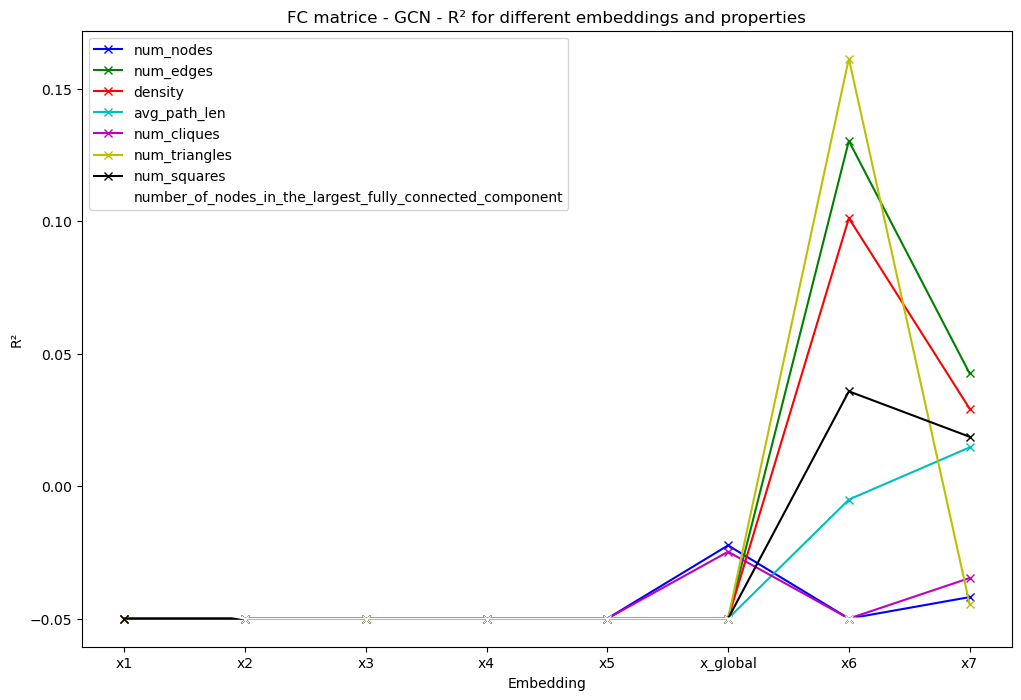

<Figure size 640x480 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component', 'assortativity', 'small_world']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_name)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_test_R2_plot_limited_cv.png', dpi=300, bbox_inches='tight')

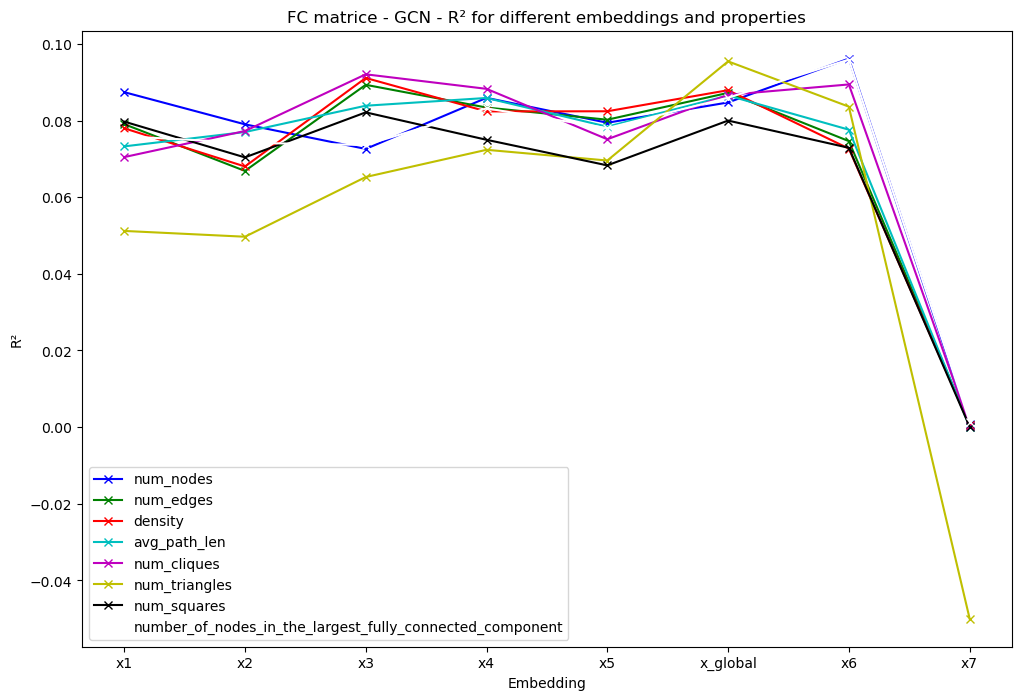

<Figure size 640x480 with 0 Axes>

In [21]:
# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component', 'assortativity', 'small_world']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        train_r2 = results[(name_of_embedding, property_name)][2]
        if train_r2 < -0.05:  # Handle negative R² values
            train_r2 = -0.05
        x_points.append(j)
        y_points.append(train_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_train_R2_plot_limited_cv.png', dpi=300, bbox_inches='tight')

#### Test with more properties

In [22]:
import networkx as nx
import numpy as np

def calculate_avg_path_length(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        # Use the average path length of the largest connected component for disconnected graphs
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.average_shortest_path_length(largest_component)
    
   
def compute_swi(graph):
    # Calculate clustering coefficient and average path length for the given graph
    clustering_coeff = nx.average_clustering(graph)
    avg_path_len = calculate_avg_path_length(graph)
    
    # Generate a random graph with the same number of nodes and edges
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    random_graph = nx.gnm_random_graph(num_nodes, num_edges)
    
    # Generate a lattice graph with the same number of nodes and edges
    lattice_graph = nx.watts_strogatz_graph(num_nodes, k=4, p=0)  # Adjust k as needed
    
    # Calculate clustering coefficient and average path length for the random graph
    random_clustering_coeff = nx.average_clustering(random_graph)
    random_avg_path_len = calculate_avg_path_length(random_graph)
    
    # Calculate clustering coefficient and average path length for the lattice graph
    lattice_clustering_coeff = nx.average_clustering(lattice_graph)
    lattice_avg_path_len = calculate_avg_path_length(lattice_graph)
    
    # Compute the Small-World Index (SWI)
    swi = ((avg_path_len - lattice_avg_path_len) / (random_avg_path_len - lattice_avg_path_len)) * \
          ((clustering_coeff - random_clustering_coeff) / (lattice_clustering_coeff - random_clustering_coeff))
    
    return swi


def betweenness_centralization(G):
    n = len(G)
    betweenness = nx.betweenness_centrality(G)
    max_betweenness = max(betweenness.values())
    centralization = sum(max_betweenness - bet for bet in betweenness.values())
    if n > 2:
        centralization /= (n - 1) * (n - 2) / 2
    return centralization

def pagerank_centralization(G, alpha=0.85):
    n = len(G)
    pagerank = nx.pagerank(G, alpha=alpha)
    max_pagerank = max(pagerank.values())
    centralization = sum(max_pagerank - pr for pr in pagerank.values())
    if n > 1:
        centralization /= (n - 1)
    return centralization

def clustering_properties(G):
    average_clustering = nx.average_clustering(G)
    transitivity = nx.transitivity(G)
    return average_clustering, transitivity

def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        
        # Number of nodes
        num_nodes = G.number_of_nodes()
        
        # Number of edges
        num_edges = G.number_of_edges()
        
        # Density
        density = nx.density(G)
        
        # Average Path Length
        avg_path_len = calculate_avg_path_length(G)
        
        # Diameter
        if nx.is_connected(G):
            diameter = nx.diameter(G)
        else:
            # Use the diameter of the largest connected component for disconnected graphs
            components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
            largest_component = max(components, key=len)
            diameter = nx.diameter(largest_component)
        
        # Radius
        if nx.is_connected(G):
            radius = nx.radius(G)
        else:
            radius = nx.radius(largest_component)
        
        # Clustering Coefficient
        clustering_coeff = nx.average_clustering(G)
        
        # Transitivity
        transitivity = nx.transitivity(G)
        
        # Assortativity
        assortativity = nx.degree_assortativity_coefficient(G)
        
        # Number of Cliques
        num_cliques = len(list(nx.find_cliques(G)))
        
        # Number of Triangles
        num_triangles = sum(nx.triangles(G).values()) / 3
        
        # Number of Squares (4-cycles)
        num_squares = sum(nx.square_clustering(G).values()) / 4
        
        # Size of the Largest Connected Component
        largest_component_size = len(max(nx.connected_components(G), key=len))
        
        # Average Degree
        degrees = [d for n, d in G.degree()]
        avg_degree = np.mean(degrees)
        
        # Betweenness Centrality
        betweenness_centrality = nx.betweenness_centrality(G)
        avg_betweenness_centrality = np.mean(list(betweenness_centrality.values()))
        
        # Eigenvalues of the Adjacency Matrix (for spectral properties)
        eigenvalues = np.linalg.eigvals(nx.adjacency_matrix(G).todense())
        spectral_radius = max(eigenvalues)
        algebraic_connectivity = sorted(eigenvalues)[1]  # second smallest eigenvalue
        
        # Graph Laplacian Eigenvalues
        laplacian_eigenvalues = np.linalg.eigvals(nx.laplacian_matrix(G).todense())
        graph_energy = sum(abs(laplacian_eigenvalues))
        
        # Small-World-ness
        # Compare clustering coefficient and average path length with those of a random graph
        random_graph = nx.gnm_random_graph(num_nodes, num_edges)
        random_clustering_coeff = nx.average_clustering(random_graph)
        random_avg_path_len = calculate_avg_path_length(random_graph)
        small_world_coefficient = (clustering_coeff / random_clustering_coeff) / (avg_path_len / random_avg_path_len)

        small_world_index = compute_swi(G)

        # Calculate Betweenness Centralization
        betweenness_cent = betweenness_centralization(G)
        print(f"Betweenness Centralization: {betweenness_cent}")

        # Calculate PageRank Centralization
        pagerank_cent = pagerank_centralization(G)
        print(f"PageRank Centralization: {pagerank_cent}")

        # Calculate Clustering properties
        avg_clustering, transitivity = clustering_properties(G)
        print(f"Average Clustering Coefficient: {avg_clustering}")
        print(f"Transitivity: {transitivity}")
        
        properties.append((
            num_nodes,
            num_edges,
            density,
            avg_path_len,
            diameter,
            radius,
            clustering_coeff,
            transitivity,
            assortativity,
            num_cliques,
            num_triangles,
            num_squares,
            largest_component_size,
            avg_degree,
            avg_betweenness_centrality,
            spectral_radius,
            algebraic_connectivity,
            graph_energy,
            small_world_coefficient, 
            betweenness_cent,
            pagerank_cent,
            avg_clustering,
            small_world_index           

        ))
    return properties


train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties_long = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties_long = compute_graph_properties(selected_dataset)

#save the properties in a file
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "wb") as f:
    pkl.dump(train_properties_long, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "wb") as f:
    pkl.dump(test_properties_long, f)



Betweenness Centralization: 0.001724022477030078
PageRank Centralization: 0.011393522233220854
Average Clustering Coefficient: 0.46590185426058695
Transitivity: 0.5531747591900924
Betweenness Centralization: 0.0017261983853566708
PageRank Centralization: 0.00892683265732043
Average Clustering Coefficient: 0.5182009816568728
Transitivity: 0.5797223390828776
Betweenness Centralization: 0.003333083015572392
PageRank Centralization: 0.015313849504207902
Average Clustering Coefficient: 0.4704590487485227
Transitivity: 0.4714022140221402
Betweenness Centralization: 0.0010671877568257148
PageRank Centralization: 0.0052237203197423076
Average Clustering Coefficient: 0.5604119583322708
Transitivity: 0.5464108308171812
Betweenness Centralization: 0.0022241433151757965
PageRank Centralization: 0.010110693464664746
Average Clustering Coefficient: 0.5817108880061148
Transitivity: 0.6164350158497928
Betweenness Centralization: 0.0008253715900658974
PageRank Centralization: 0.008937849000785933
Avera

In [23]:
#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "rb") as f:
    train_properties_long = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "rb") as f:
    test_properties_long = pkl.load(f)

In [24]:
#print the names of the properties
# print(train_properties_long[0].keys())

#print the first element of the properties
# print(train_properties_long[0])

#copare train_properties and train_properties_long
print(train_properties[0])
print(train_properties_long[0])
print(len(train_properties_long))

(116, 488, 0.07316341829085457, 3.314842578710645, 148, 938.0, 6.439699892510922, 116)
(116, 488, 0.07316341829085457, 3.314842578710645, 7, 4, 0.46590185426058695, 0.5531747591900924, 0.4167832357774365, 148, 938.0, 6.439699892510922, 116, 8.413793103448276, 0.02030563665535653, 14.95587231892924, -4.061650998933738, 976.0000000000007, 4.553913064548185)
1523


In [25]:
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
train_y_long = torch.tensor(train_properties_long, dtype=torch.float32)
test_y_long = torch.tensor(test_properties_long, dtype=torch.float32)
#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names_long):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 800000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y_long[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y_long[:, i].cpu().numpy()
            test_target = test_y_long[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long.pkl", "wb") as f:
    pkl.dump(results, f)

C:\Users\tomdu\AppData\Local\Temp\ipykernel_4340\1310961172.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  train_y_long = torch.tensor(train_properties_long, dtype=torch.float32)
C:\Users\tomdu\AppData\Local\Temp\ipykernel_4340\1310961172.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  test_y_long = torch.tensor(test_properties_long, dtype=torch.float32)


Epoch [1000/800000], Property: num_nodes, Loss: 11316.3281
Epoch [2000/800000], Property: num_nodes, Loss: 10060.5898
Epoch [3000/800000], Property: num_nodes, Loss: 9020.5049
Epoch [4000/800000], Property: num_nodes, Loss: 8136.6973
Epoch [5000/800000], Property: num_nodes, Loss: 7371.2759
Epoch [6000/800000], Property: num_nodes, Loss: 6704.2192
Epoch [7000/800000], Property: num_nodes, Loss: 6122.5757
Epoch [8000/800000], Property: num_nodes, Loss: 5616.6626
Epoch [9000/800000], Property: num_nodes, Loss: 5176.6523
Epoch [10000/800000], Property: num_nodes, Loss: 4792.4106
Epoch [11000/800000], Property: num_nodes, Loss: 4454.3672
Epoch [12000/800000], Property: num_nodes, Loss: 4155.3003
Epoch [13000/800000], Property: num_nodes, Loss: 3891.3599
Epoch [14000/800000], Property: num_nodes, Loss: 3659.1582
Epoch [15000/800000], Property: num_nodes, Loss: 3454.4497
Epoch [16000/800000], Property: num_nodes, Loss: 3273.5803
Epoch [17000/800000], Property: num_nodes, Loss: 3113.6660
Epoc

In [28]:
#load results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long.pkl", "rb") as f:
    results = pkl.load(f)

In [29]:
#print color_long length and property_names_long length
print(len(colors_long))
print(len(property_names_long))

19
23


In [30]:
property_names_long

'small_world_coefficient'

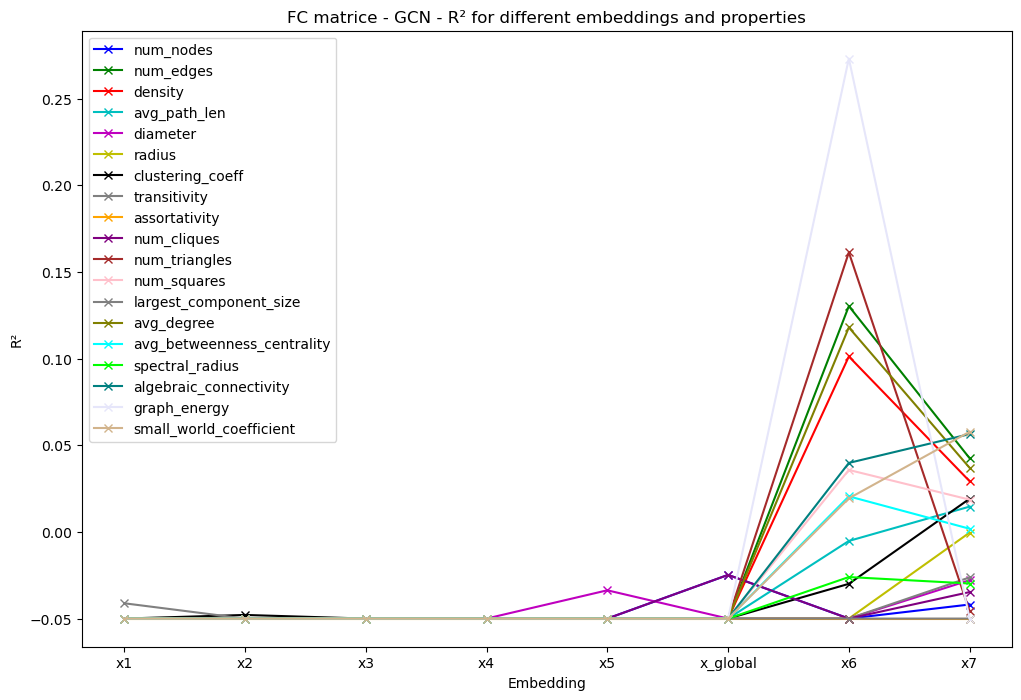

<Figure size 640x480 with 0 Axes>

In [31]:
#import plt
import matplotlib.pyplot as plt
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
#make a color list for the properties names but with different colors
colors_long = [
    (0.0, 0.45, 0.70),  # Blue
    (0.85, 0.37, 0.01),  # Orange
    (0.8, 0.47, 0.74),   # Magenta
    (0.0, 0.62, 0.45),   # Green
    (0.95, 0.90, 0.25),  # Yellow
    (0.9, 0.6, 0.0),     # Brown
    (0.35, 0.7, 0.9),    # Sky Blue
    (0.8, 0.6, 0.7),     # Light Pink
    (0.3, 0.3, 0.3),     # Dark Gray
    (0.5, 0.5, 0.0),     # Olive
    (0.0, 0.75, 0.75),   # Cyan
    (0.6, 0.6, 0.6),     # Light Gray
    (0.7, 0.3, 0.1),     # Dark Orange
    (0.6, 0.2, 0.5),     # Purple
    (0.9, 0.4, 0.3),     # Salmon
    (0.4, 0.4, 0.8),     # Light Blue
    (0.2, 0.8, 0.2),     # Light Green
    (0.6, 0.6, 0.3),     # Mustard
    (0.3, 0.55, 0.55)    # Teal
    (0.8, 0.5, 0.2),     # Dark Salmon
    (0.5, 0.5, 0.5),     # Gray
    (0.2, 0.2, 0.2)      # Black-Gray
    (0.0, 0.0, 0.0)      # Black
]
plt.figure(figsize=(12, 8))

for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_names_long)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_test_R2_plot_limited_cv_long.png', dpi=300, bbox_inches='tight')

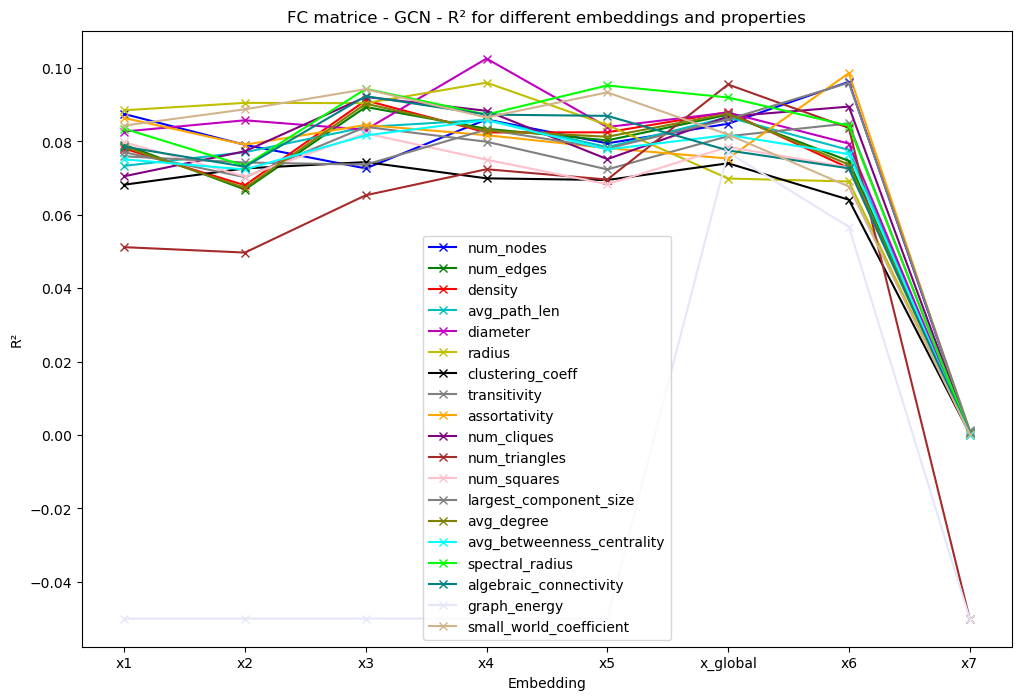

<Figure size 640x480 with 0 Axes>

In [32]:
plt.figure(figsize=(12, 8))

for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        train_r2 = results[(name_of_embedding, property_names_long)][2]
        if train_r2 < -0.05:  # Handle negative R² values
            train_r2 = -0.05
        x_points.append(j)
        y_points.append(train_r2)

    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_train_R2_plot_limited_cv_long.png', dpi=300, bbox_inches='tight')
    

### comparison with a gnn train on random (the y are shuffled)

In [ ]:
dataset = read_dataset_MDD()
MODEL = "GCN_w_edge_weight"
DATASET = "FC_MDD_suffled"

from models.models_FC import GCN_framework_wo_edge_weight as framework # import the model

gnn = framework(dataset,device="cpu")

print(gnn.model)
print(gnn.train_idx)

Net(
  (conv_layers): ModuleList(
    (0): GCNConv(116, 128)
    (1-4): 4 x GCNConv(128, 128)
  )
  (batch_norms): ModuleList(
    (0-4): 5 x BatchNorm(128)
  )
  (lin1): Linear(128, 128, bias=True)
  (lin2): Linear(128, 2, bias=True)
  (bn1): BatchNorm(128)
  (bn2): BatchNorm(2)
)
tensor([217, 137, 426,  ..., 643, 205, 434])


c:\Users\tomdu\miniconda3\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
#shuffle the y values of the dataset
import numpy as np
import torch

y = np.array([data.y for data in dataset])
np.random.shuffle(y)

#make y torch.int64, tensor([0]) instead of [0]
y = torch.tensor(y, dtype=torch.int64)

for i in range(len(dataset)):
    dataset[i].y = y[i]

In [ ]:
gnn.iterate()

Epoch: 020, Loss: 0.158, Test Loss: 0.831, Train Acc: 0.998 Test Acc: 0.509
Epoch: 040, Loss: 0.152, Test Loss: 0.867, Train Acc: 0.999 Test Acc: 0.527
Epoch: 060, Loss: 0.118, Test Loss: 0.772, Train Acc: 0.999 Test Acc: 0.491
Epoch: 080, Loss: 0.111, Test Loss: 0.756, Train Acc: 0.999 Test Acc: 0.491
Epoch: 100, Loss: 0.106, Test Loss: 0.807, Train Acc: 0.999 Test Acc: 0.509
Epoch: 120, Loss: 0.099, Test Loss: 0.786, Train Acc: 0.999 Test Acc: 0.473
Epoch: 140, Loss: 0.096, Test Loss: 0.761, Train Acc: 0.999 Test Acc: 0.527
Epoch: 160, Loss: 0.097, Test Loss: 0.748, Train Acc: 0.999 Test Acc: 0.509
Epoch: 180, Loss: 0.092, Test Loss: 0.767, Train Acc: 0.999 Test Acc: 0.473
Epoch: 200, Loss: 0.091, Test Loss: 0.763, Train Acc: 0.999 Test Acc: 0.473
Epoch: 220, Loss: 0.091, Test Loss: 0.769, Train Acc: 0.999 Test Acc: 0.455
Epoch: 240, Loss: 0.089, Test Loss: 0.766, Train Acc: 0.999 Test Acc: 0.473
Epoch: 260, Loss: 0.091, Test Loss: 0.781, Train Acc: 0.999 Test Acc: 0.473
Epoch: 280, 

In [ ]:
#save the model 
# gnn.save_model(path="models/"+DATASET+"_"+MODEL+".pt")

In [ ]:
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+"server.pt")

In [ ]:
gnn.evaluate()

In [ ]:
train_features, test_features = gnn.evaluate_with_features2()

In [ ]:
train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties_long = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties_long = compute_graph_properties(selected_dataset)

#save the properties in a file
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "wb") as f:
    pkl.dump(train_properties_long, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "wb") as f:
    pkl.dump(test_properties_long, f)

In [ ]:
import pickle as pkl
#save the properties in a file
# with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "wb") as f:
#     pkl.dump(train_properties, f)

# with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "wb") as f:
#     pkl.dump(test_properties, f)

#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "rb") as f:
    train_properties = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "rb") as f:
    test_properties = pkl.load(f)

In [ ]:
"""
The embeddings of GCN are like this:
return F.log_softmax(x7, dim=-1), (x1, x2, x3, x4, x5, x_global, x6, x7)
"""


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
#train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x4 = np.array([feat[3] for feat in train_features])
test_x4 = np.array([feat[3] for feat in test_features])

train_x5 = np.array([feat[4] for feat in train_features])
test_x5 = np.array([feat[4] for feat in test_features])

train_x_global = np.array([feat[5] for feat in train_features])
test_x_global = np.array([feat[5] for feat in test_features])

train_x6 = np.array([feat[6] for feat in train_features])
test_x6 = np.array([feat[6] for feat in test_features])

train_x7 = np.array([feat[7] for feat in train_features])
test_x7 = np.array([feat[7] for feat in test_features])

# Compute graph properties
# train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
# test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x6 = torch.tensor(test_x6, dtype=torch.float32)
test_x7 = torch.tensor(test_x7, dtype=torch.float32)

train_y = torch.tensor(train_properties, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x5, test_x5), (train_x_global, test_x_global), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

In [ ]:
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
train_y_long = torch.tensor(train_properties_long, dtype=torch.float32)
test_y_long = torch.tensor(test_properties_long, dtype=torch.float32)
#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names_long):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 800000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y_long[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y_long[:, i].cpu().numpy()
            test_target = test_y_long[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long.pkl", "wb") as f:
    pkl.dump(results, f)

In [ ]:
#load results 
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long.pkl", "rb") as f:
    results = pkl.load(f)

In [ ]:
import matplotlib.pyplot as plt
colors_long = [
    (0.0, 0.45, 0.70),  # Blue
    (0.85, 0.37, 0.01),  # Orange
    (0.8, 0.47, 0.74),   # Magenta
    (0.0, 0.62, 0.45),   # Green
    (0.95, 0.90, 0.25),  # Yellow
    (0.9, 0.6, 0.0),     # Brown
    (0.35, 0.7, 0.9),    # Sky Blue
    (0.8, 0.6, 0.7),     # Light Pink
    (0.3, 0.3, 0.3),     # Dark Gray
    (0.5, 0.5, 0.0),     # Olive
    (0.0, 0.75, 0.75),   # Cyan
    (0.6, 0.6, 0.6),     # Light Gray
    (0.7, 0.3, 0.1),     # Dark Orange
    (0.6, 0.2, 0.5),     # Purple
    (0.9, 0.4, 0.3),     # Salmon
    (0.4, 0.4, 0.8),     # Light Blue
    (0.2, 0.8, 0.2),     # Light Green
    (0.6, 0.6, 0.3),     # Mustard
    (0.3, 0.55, 0.55)    # Teal
    (0.8, 0.5, 0.2),     # Dark Salmon
    (0.5, 0.5, 0.5),     # Gray
    (0.2, 0.2, 0.2)      # Black-Gray
    (0.0, 0.0, 0.0)      # Black
]

property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

plt.figure(figsize=(12, 8))

for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_names_long)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+'_'+MODEL+'test_R2_plot_long_random.png')

### Node embedding probing

/!\ Try to not forget that we need to change the batch_size to 1 if we want to probe for node properties as we need the forward pass to be made 1 graph by 1 graph at a time. 

##### Node properties

In [ ]:
import networkx as nx
# Define function to compute node-level properties
def compute_node_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        node_degrees = list(dict(G.degree()).values())
        clustering_coeffs = list(nx.clustering(G).values())
        betweenness_centralities = list(nx.betweenness_centrality(G).values())
        eigenvector_centralities = list(nx.eigenvector_centrality(G, max_iter=10000).values())
        Local_clustering_coefficients = list(nx.clustering(G).values())

        properties.append((node_degrees, clustering_coeffs, betweenness_centralities, eigenvector_centralities, Local_clustering_coefficients))
    return properties

# Compute node-level properties for train and test sets
# Ensure gnn.train_idx and gnn.test_idx are lists of integers
train_idx = gnn.train_idx.tolist() if isinstance(gnn.train_idx, torch.Tensor) else gnn.train_idx
test_idx = gnn.test_idx.tolist() if isinstance(gnn.test_idx, torch.Tensor) else gnn.test_idx

# Compute node-level properties for train and test sets
train_node_properties = compute_node_properties([gnn.dataset[i] for i in train_idx])
test_node_properties = compute_node_properties([gnn.dataset[i] for i in test_idx])

#train_node_properties is a list of tuples, where each tuple contains 5 lists, each list contains the node-level property for each node in the graph

In [ ]:
train_idx[0]

217

In [ ]:
len(train_node_properties), len(test_node_properties)

(1044, 55)

In [ ]:
# Check the length of the first three betweenness centralities of the three first graphs in the train set
[len(train_node_properties[i][2]) for i in range(15)]

[116, 116, 116, 116, 116, 116, 115, 113, 116, 116, 114, 115, 112, 115, 116]

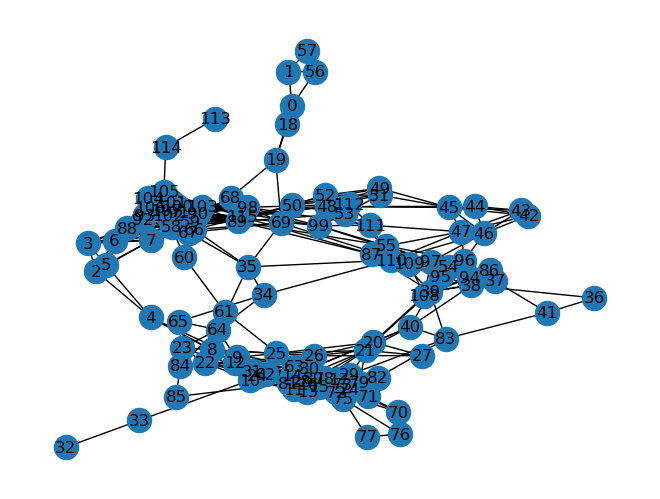

In [ ]:
import networkx as nx
# Ensure gnn.test_idx is a list of integers
test_idx = gnn.test_idx.tolist() if isinstance(gnn.test_idx, torch.Tensor) else gnn.test_idx

# Visualize the first graph of the test set to see if the properties are correct
G = nx.from_edgelist(gnn.dataset[test_idx[0]].edge_index.t().tolist())
nx.draw(G, with_labels=True)


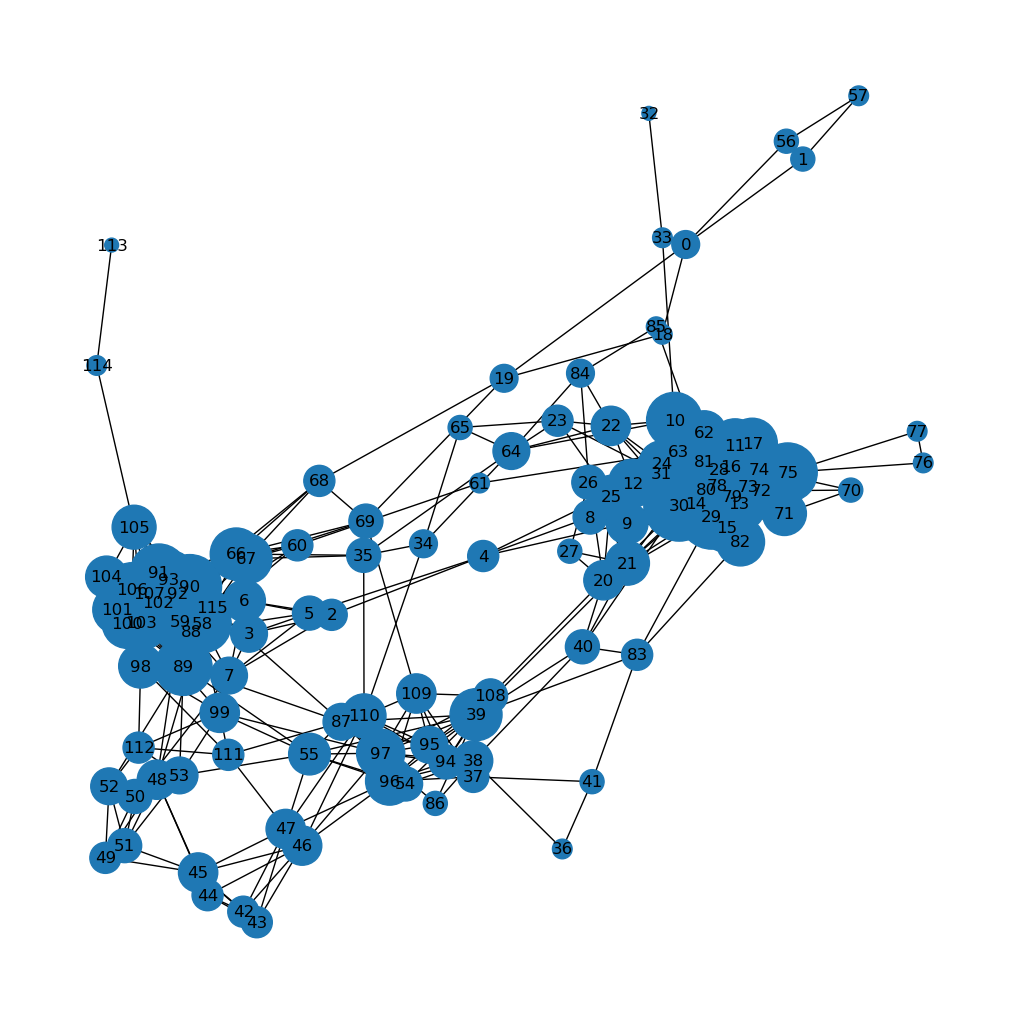

In [ ]:
import matplotlib.pyplot as plt
#represent the node degrees of the first graph in the test set
node_degrees = test_node_properties[0][0]

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=[v * 100 for v in node_degrees], cmap='viridis')
plt.show()

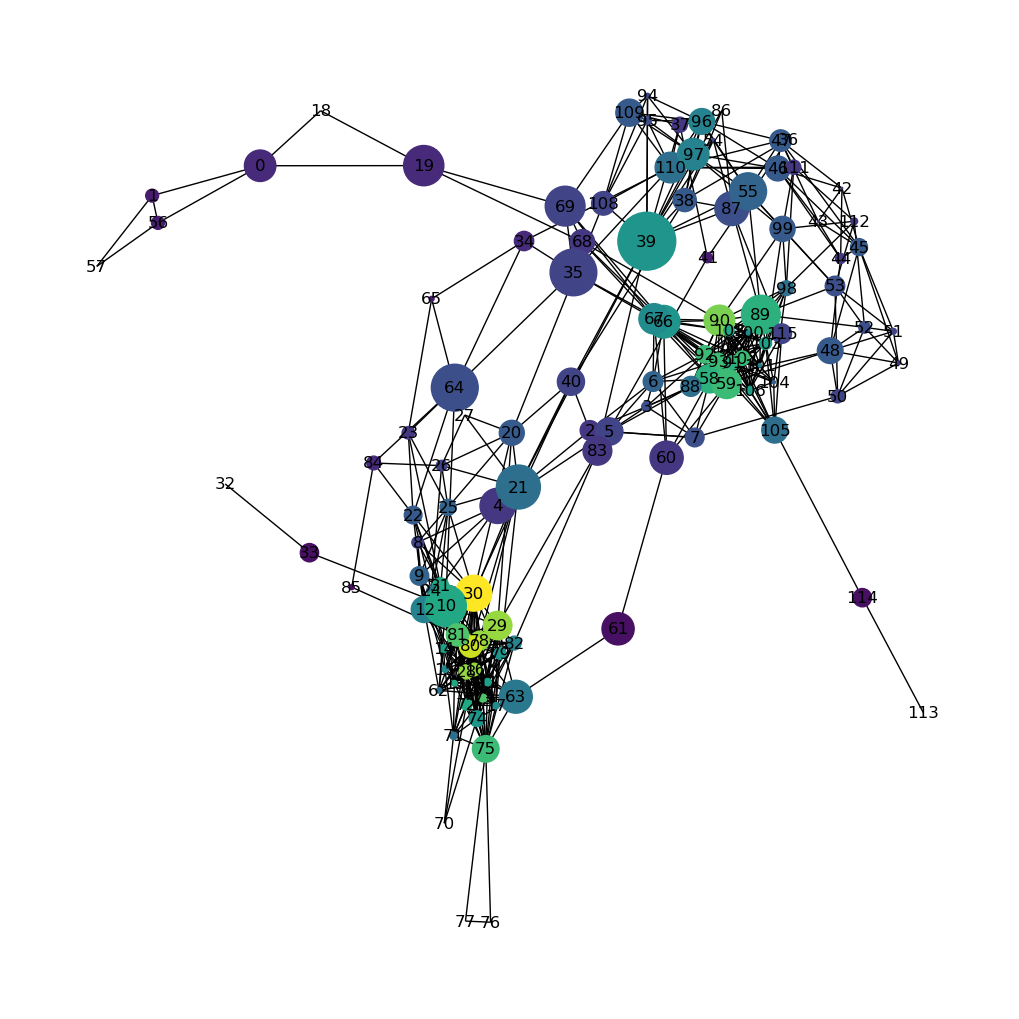

In [ ]:
#represent the properties of betweenness centrality on the graph by chaging the size of the nodes
betweenness_centrality = test_node_properties[0][2]
node_degrees = test_node_properties[0][0]

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=[v * 10000 for v in betweenness_centrality], node_color=node_degrees, cmap='viridis')
plt.show()


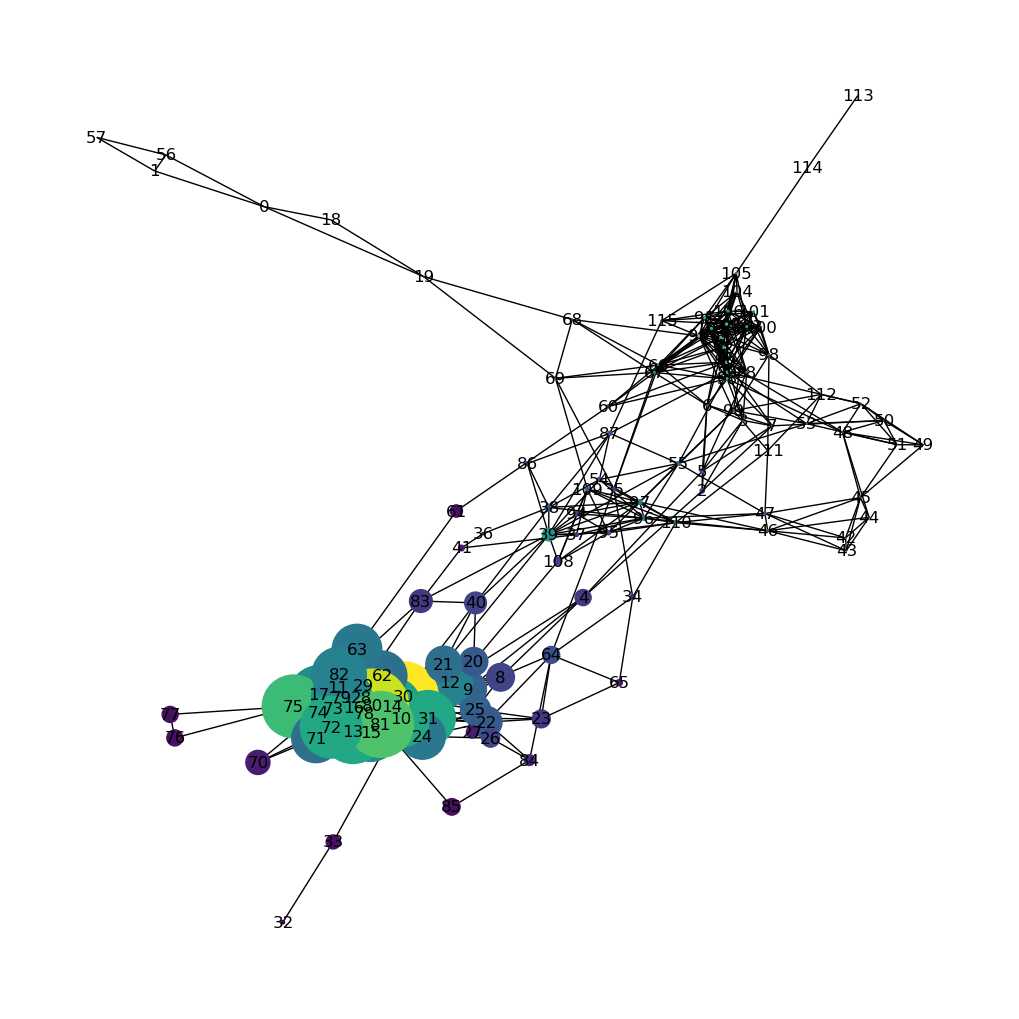

In [ ]:
#same for eigenvector centrality
eigenvector_centralities = test_node_properties[0][3]

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=[v * 10000 for v in eigenvector_centralities], node_color=node_degrees, cmap='viridis')
plt.show()

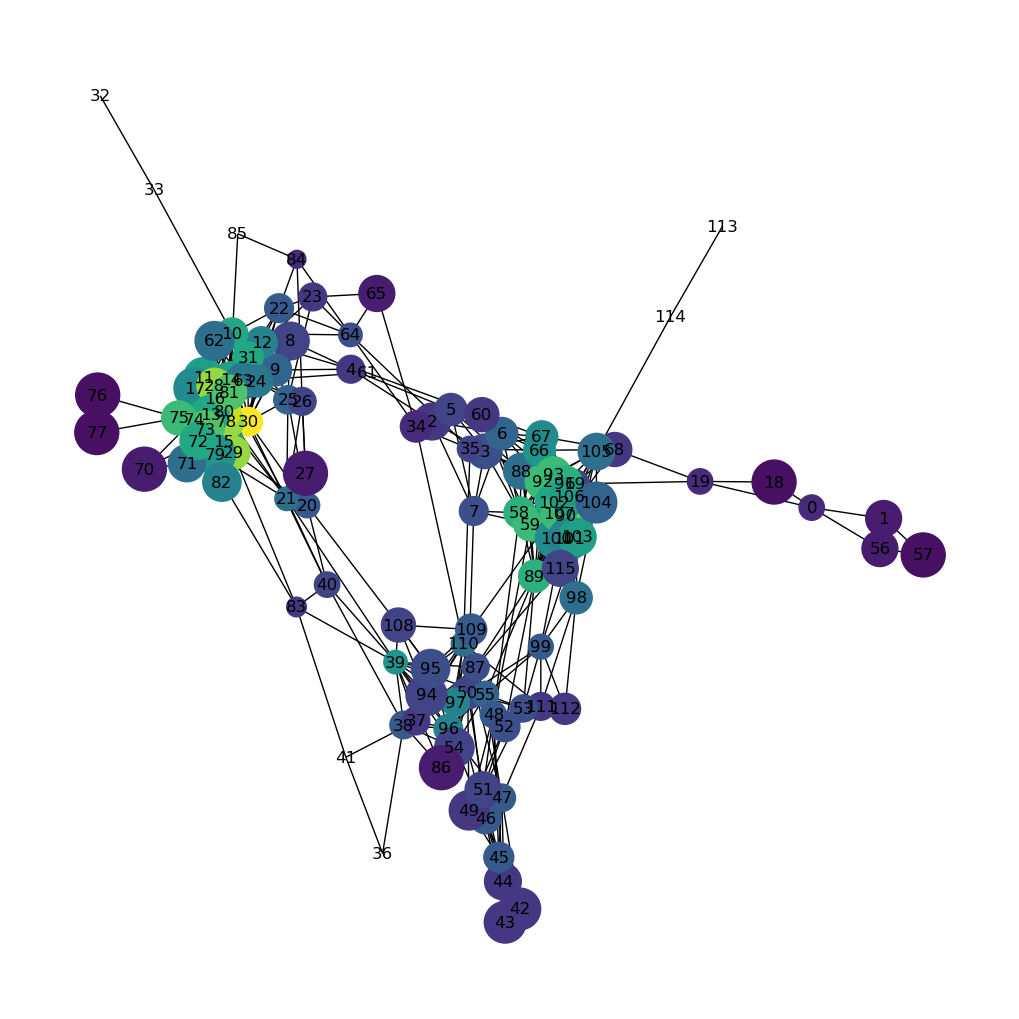

In [ ]:
#same for local clustering coefficients
Local_clustering_coefficients = test_node_properties[0][4]

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=[v * 1000 for v in Local_clustering_coefficients], node_color=node_degrees, cmap='viridis')
plt.show()

We see that for each graph, the length of the betweenness centralities, and in general the length of properties, are equal to the number of nodes in the graph and thus
is equal to the length of the x matrix in the features. 

##### Node embeddings

In [ ]:
train_features, test_features = gnn.evaluate_with_features2(return_node_embeddings=True)

len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.

In [ ]:
len(train_features), len(test_features)

(1044, 55)

In [ ]:
# Check the shape of the first graph's features
first_graph_features = train_features[1]
for i, feature in enumerate(first_graph_features):
    print(f"Feature {i+1} shape:", feature.shape)

Feature 1 shape: (116, 128)
Feature 2 shape: (116, 128)
Feature 3 shape: (116, 128)
Feature 4 shape: (116, 128)
Feature 5 shape: (116, 128)


In [ ]:
train_features[1][0][115]

array([-0.37685975,  1.6929058 ,  1.7549721 , -0.5988426 , -0.70699286,
       -0.6436017 , -0.5976539 , -0.58719116, -0.6589397 , -0.58917546,
       -0.6371779 ,  0.7570742 , -0.67844796, -0.5799983 ,  0.99585336,
        0.7851752 , -0.72770834,  2.5991597 , -0.6501186 , -0.67277133,
        0.8801811 ,  3.412127  , -0.62779766, -0.63370866, -0.6870711 ,
        0.9279621 ,  1.7032547 , -0.6746877 , -0.17400467, -0.6686538 ,
       -0.65484655, -0.6692904 , -0.6735106 , -0.6526415 ,  0.69125366,
        0.07277119, -0.6910381 , -0.6376403 , -0.5185264 , -0.6976487 ,
       -0.6681054 , -0.71855813, -0.71772814,  0.52832973, -0.73103005,
        0.28918487, -0.66227067, -0.6802141 , -0.6193607 , -0.67815524,
       -0.6069186 ,  1.8839588 , -0.59435576, -0.02621281, -0.7132852 ,
       -0.68886244, -0.6890108 , -0.6547946 ,  0.6078467 , -0.701213  ,
        1.2887506 ,  2.127263  , -0.58606315,  2.8298755 , -0.18379873,
       -0.5403075 , -0.7609473 , -0.32233348,  0.40016913, -0.10

#### Embedding probing

##### Probing for the top 3 nodes on train_features only and averaging the results of the different diagnostif classifiers

In [ ]:
import torch
import torch.nn as nn

class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Function to get the top 3 nodes based on a specific property
def get_top_nodes(property_list, top_n=10):
    sorted_indices = sorted(range(len(property_list)), key=lambda k: property_list[k], reverse=True)
    return sorted_indices[:top_n]

In [ ]:

# Get the top 3 nodes for local clustering coefficient and eigenvector centrality
top_nodes_degrees = [get_top_nodes(graph_props[0], 10) for graph_props in train_node_properties]  # Assuming 0th index is for node degrees
top_nodes_clustering = [get_top_nodes(graph_props[1], 10) for graph_props in train_node_properties]  # Assuming 1st index is for clustering coefficient
top_nodes_betweenness = [get_top_nodes(graph_props[2], 10) for graph_props in train_node_properties]  # Assuming 2nd index is for betweenness centrality
top_nodes_local_clustering = [get_top_nodes(graph_props[3], 10) for graph_props in train_node_properties]  # Assuming 3rd index is for local clustering coefficient
top_nodes_eigenvector = [get_top_nodes(graph_props[4], 10) for graph_props in train_node_properties]  # Assuming 4th index is for eigenvector centrality


In [ ]:
# Prepare the data for linear regression model training
def prepare_regression_data(features, properties, top_nodes_indices):
    X = []
    y = []
    for i, graph_features in enumerate(features):
        for layer in range(len(graph_features)):
            for node_index in top_nodes_indices[i]:
                X.append(graph_features[layer][node_index])
                y.append(properties[i][node_index])
    return torch.tensor(X), torch.tensor(y)

# Training and evaluating linear regression models
def train_and_evaluate_regression(X, y):
    model = LinearModel(X.shape[1], 1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # Train the model
    model.train()
    for epoch in range(5000):
        optimizer.zero_grad()
        outputs = model(X.float())
        loss = criterion(outputs, y.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        predictions = model(X.float()).view(-1)
        r2 = r2_score(y.float(), predictions)
    return r2

In [ ]:
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data for node degree regression
X_node_degree, y_node_degree = prepare_regression_data(train_features, [props[0] for props in train_node_properties], top_nodes_degrees)

# Train and evaluate model for node degree
r2_node_degree = train_and_evaluate_regression(X_node_degree, y_node_degree)
print(f'R² for node degree prediction: {r2_node_degree}')

# Prepare data for betweenness centrality regression
X_betweenness, y_betweenness = prepare_regression_data(train_features, [props[2] for props in train_node_properties], top_nodes_betweenness)

# Train and evaluate model for betweenness centrality
r2_betweenness = train_and_evaluate_regression(X_betweenness, y_betweenness)
print(f'R² for betweenness centrality prediction: {r2_betweenness}')

# Prepare data for local clustering coefficient regression
X_local_clustering, y_local_clustering = prepare_regression_data(train_features, [props[3] for props in train_node_properties], top_nodes_local_clustering)

# Train and evaluate model for local clustering coefficient
r2_local_clustering = train_and_evaluate_regression(X_local_clustering, y_local_clustering)
print(f'R² for local clustering coefficient prediction: {r2_local_clustering}')

# Prepare data for eigenvector centrality regression
X_eigenvector, y_eigenvector = prepare_regression_data(train_features, [props[4] for props in train_node_properties], top_nodes_eigenvector)

# Train and evaluate model for eigenvector centrality
r2_eigenvector = train_and_evaluate_regression(X_eigenvector, y_eigenvector)
print(f'R² for eigenvector centrality prediction: {r2_eigenvector}')

C:\Users\tomdu\AppData\Local\Temp\ipykernel_15848\2885731528.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor(X), torch.tensor(y)


Epoch 0, Loss: 337.63140869140625
Epoch 10, Loss: 325.15325927734375
Epoch 20, Loss: 317.4220275878906
Epoch 30, Loss: 311.8927307128906
Epoch 40, Loss: 307.3858337402344
Epoch 50, Loss: 303.4187316894531
Epoch 60, Loss: 299.7639465332031
Epoch 70, Loss: 296.2999267578125
Epoch 80, Loss: 292.96038818359375
Epoch 90, Loss: 289.7093200683594
Epoch 100, Loss: 286.5265808105469
Epoch 110, Loss: 283.3989562988281
Epoch 120, Loss: 280.3171691894531
Epoch 130, Loss: 277.27484130859375
Epoch 140, Loss: 274.2673645019531
Epoch 150, Loss: 271.29156494140625
Epoch 160, Loss: 268.34521484375
Epoch 170, Loss: 265.42669677734375
Epoch 180, Loss: 262.5349426269531
Epoch 190, Loss: 259.6691589355469
Epoch 200, Loss: 256.8288269042969
Epoch 210, Loss: 254.01341247558594
Epoch 220, Loss: 251.22276306152344
Epoch 230, Loss: 248.4565887451172
Epoch 240, Loss: 245.7146759033203
Epoch 250, Loss: 242.9969024658203
Epoch 260, Loss: 240.3031463623047
Epoch 270, Loss: 237.63323974609375
Epoch 280, Loss: 234.987

##### Probing for the top 1 nodes with diagnostic classifier trained on the train set and test on the test set

Processing property: Node Degrees
Processing property: Clustering Coefficients
Processing property: Betweenness Centralities
Processing property: Eigenvector Centralities
Processing property: Local Clustering Coefficients


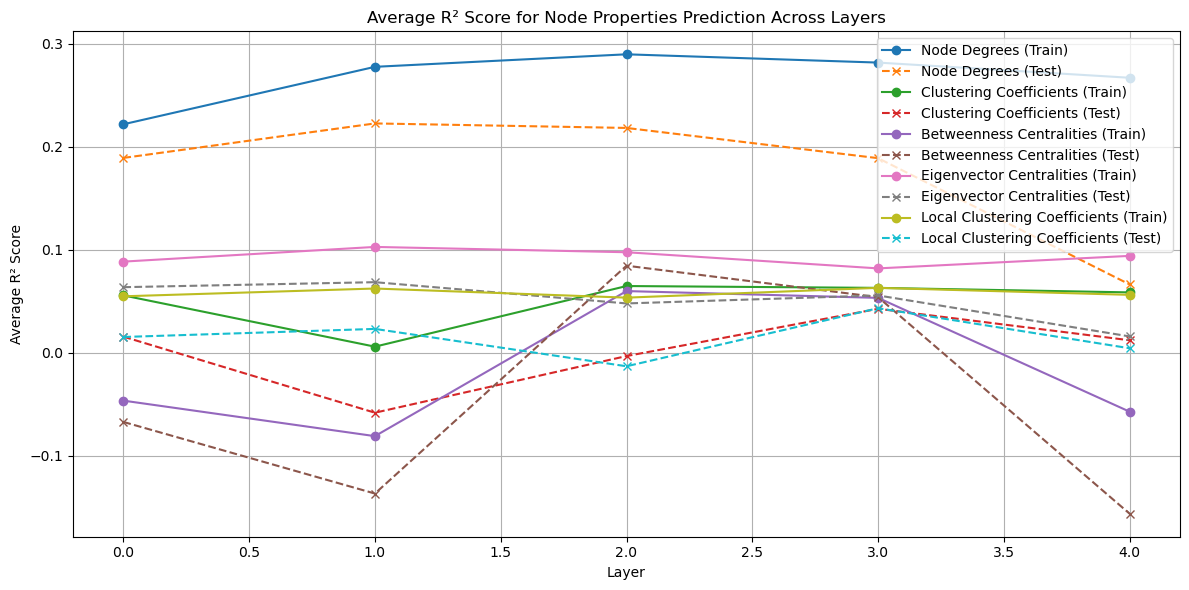

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

# Define Linear Model for probing (diagnostic classifier)
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Prepare the data for probing classifier
def prepare_regression_data(features, properties, property_index, top_n_nodes=10):
    X_layers = [[] for _ in range(len(features[0]))]
    y_layers = [[] for _ in range(len(features[0]))]

    for i, graph_features in enumerate(features):
        top_nodes_indices = get_top_nodes(properties[i][property_index], top_n=top_n_nodes)
        for layer in range(len(graph_features)):
            for node_index in top_nodes_indices:
                X_layers[layer].append(graph_features[layer][node_index])
                y_layers[layer].append(properties[i][property_index][node_index])

    X_layers = [torch.tensor(X) for X in X_layers]
    y_layers = [torch.tensor(y) for y in y_layers]
    
    return X_layers, y_layers

# Train and evaluate the probing classifier for each layer
def train_and_evaluate_regression(X_train_layers, y_train_layers, X_test_layers, y_test_layers):
    r2_scores_train = []
    r2_scores_test = []
    
    for layer in range(len(X_train_layers)):
        X_train = X_train_layers[layer]
        y_train = y_train_layers[layer]
        X_test = X_test_layers[layer]
        y_test = y_test_layers[layer]
        
        model = LinearModel(X_train.shape[1], 1)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        
        # Train the model
        model.train()
        for epoch in range(10000):
            optimizer.zero_grad()
            outputs = model(X_train.float())
            loss = criterion(outputs, y_train.float().view(-1, 1))
            loss.backward()
            optimizer.step()
        
        # Evaluate the model
        model.eval()
        with torch.no_grad():
            predictions_train = model(X_train.float()).view(-1)
            predictions_test = model(X_test.float()).view(-1)
            r2_train = r2_score(y_train.float(), predictions_train)
            r2_test = r2_score(y_test.float(), predictions_test)
        r2_scores_train.append(r2_train)
        r2_scores_test.append(r2_test)
    
    return r2_scores_train, r2_scores_test

# Aggregate R² scores across all graphs
def aggregate_r2_scores(features_train, properties_train, features_test, properties_test, property_index):
    X_train_layers, y_train_layers = prepare_regression_data(features_train, properties_train, property_index)
    X_test_layers, y_test_layers = prepare_regression_data(features_test, properties_test, property_index)
    
    r2_scores_train, r2_scores_test = train_and_evaluate_regression(X_train_layers, y_train_layers, X_test_layers, y_test_layers)
    
    return r2_scores_train, r2_scores_test

# Properties indices: 0 - node_degrees, 1 - clustering_coeffs, 2 - betweenness_centralities, 3 - eigenvector_centralities, 4 - Local_clustering_coefficients
properties_indices = [0, 1, 2, 3, 4]
property_names = ['Node Degrees', 'Clustering Coefficients', 'Betweenness Centralities', 'Eigenvector Centralities', 'Local Clustering Coefficients']

# Initialize dictionaries to store average R² scores across all layers
avg_r2_train_dict = {name: [] for name in property_names}
avg_r2_test_dict = {name: [] for name in property_names}

# Train and evaluate the probing classifier for each property
for prop_idx, prop_name in zip(properties_indices, property_names):
    print(f"Processing property: {prop_name}")
    avg_r2_train_dict[prop_name], avg_r2_test_dict[prop_name] = aggregate_r2_scores(train_features, train_node_properties, test_features, test_node_properties, prop_idx)

# Plotting the average R² scores across layers for each property
layers = np.arange(len(avg_r2_train_dict[property_names[0]]))

plt.figure(figsize=(12, 6))

# Plot for average R² scores
for prop_name in property_names:
    plt.plot(layers, avg_r2_train_dict[prop_name], label=f'{prop_name} (Train)', marker='o')
    plt.plot(layers, avg_r2_test_dict[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')

plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

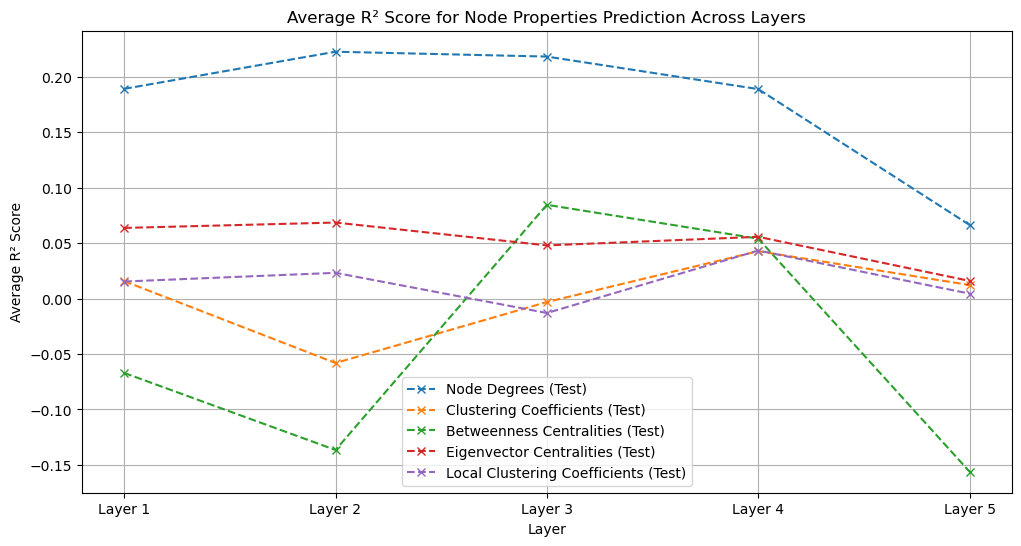

In [ ]:
#plot only test results
plt.figure(figsize=(12, 6))

# Plot for average R² scores
for prop_name in property_names:
    plt.plot(layers, avg_r2_test_dict[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')

plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers')
plt.legend()
#x axis called layer 1, layer 2, etc
plt.xticks(range(len(layers)), [f'Layer {i+1}' for i in layers])           
plt.grid(True)

y=1 and y=0 as two different plots

Processing property for y=0: Node Degrees
Processing property for y=0: Clustering Coefficients
Processing property for y=0: Betweenness Centralities
Processing property for y=0: Eigenvector Centralities
Processing property for y=0: Local Clustering Coefficients
Processing property for y=1: Node Degrees
Processing property for y=1: Clustering Coefficients
Processing property for y=1: Betweenness Centralities
Processing property for y=1: Eigenvector Centralities
Processing property for y=1: Local Clustering Coefficients


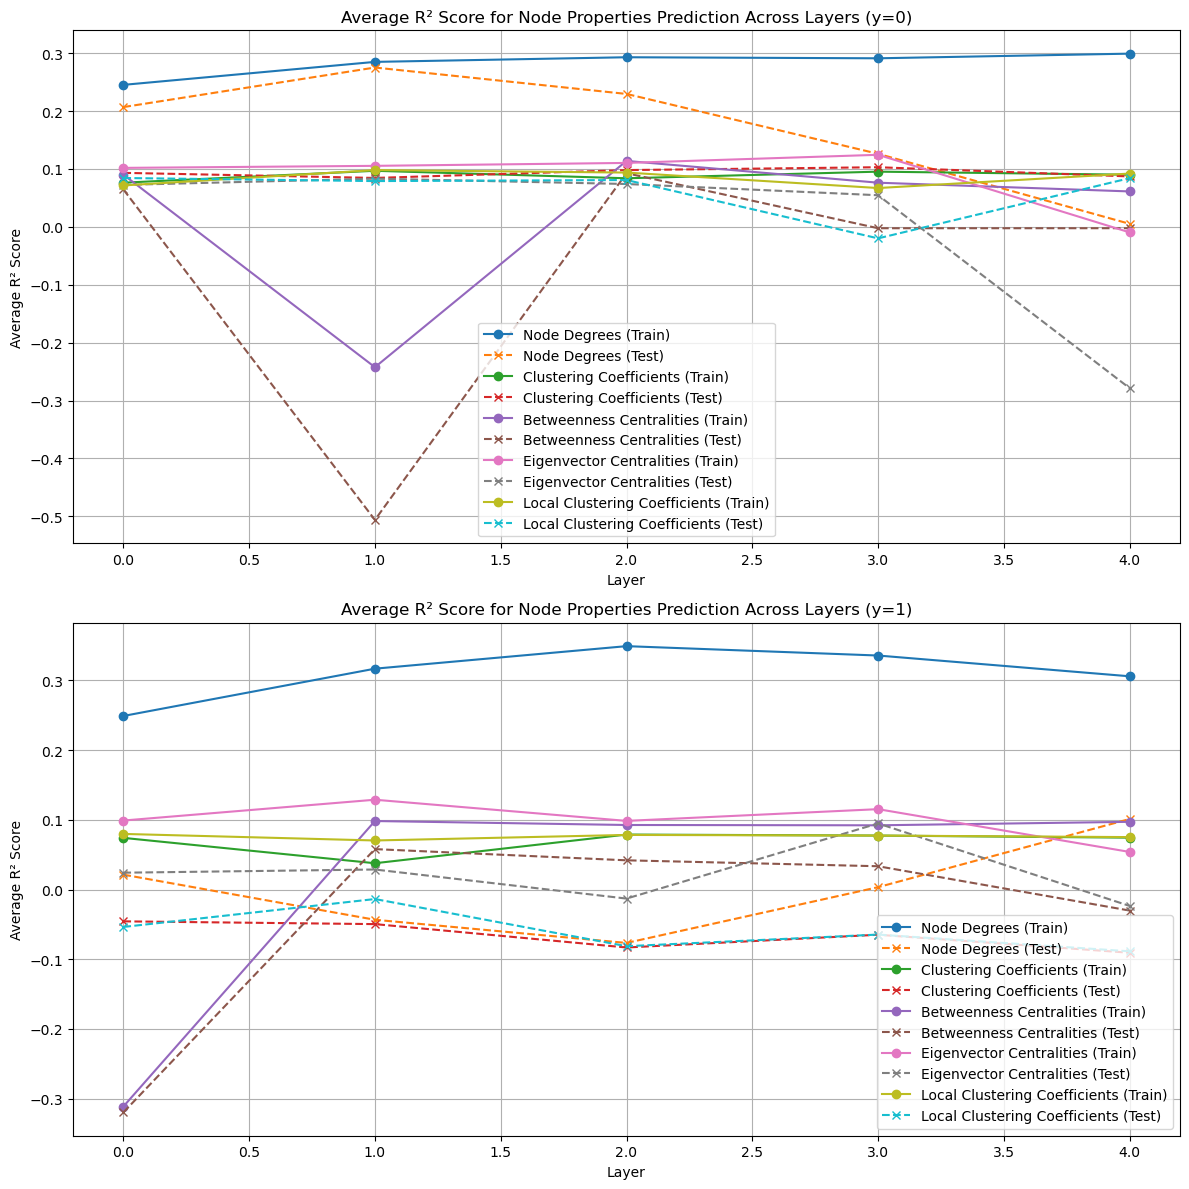

In [ ]:
# Extract labels from the dataset using train_idx_list and test_idx_list
train_idx_list = gnn.train_idx.tolist()
test_idx_list = gnn.test_idx.tolist()

train_labels = [gnn.dataset[i].y.item() for i in train_idx_list]
test_labels = [gnn.dataset[i].y.item() for i in test_idx_list]

# Split the dataset by label y=0 and y=1
def split_by_label(features, properties, labels):
    features_0, properties_0, features_1, properties_1 = [], [], [], []
    
    for i, label in enumerate(labels):
        if label == 0:
            features_0.append(features[i])
            properties_0.append(properties[i])
        else:
            features_1.append(features[i])
            properties_1.append(properties[i])
    
    return features_0, properties_0, features_1, properties_1

# Assuming you have train_features, train_node_properties, test_features, test_node_properties from your GNN
train_features_0, train_node_properties_0, train_features_1, train_node_properties_1 = split_by_label(train_features, train_node_properties, train_labels)
test_features_0, test_node_properties_0, test_features_1, test_node_properties_1 = split_by_label(test_features, test_node_properties, test_labels)

# Properties indices: 0 - node_degrees, 1 - clustering_coeffs, 2 - betweenness_centralities, 3 - eigenvector_centralities, 4 - Local_clustering_coefficients
properties_indices = [0, 1, 2, 3, 4]
property_names = ['Node Degrees', 'Clustering Coefficients', 'Betweenness Centralities', 'Eigenvector Centralities', 'Local Clustering Coefficients']

# Initialize dictionaries to store average R² scores across all layers for y=0 and y=1
avg_r2_train_dict_0 = {name: [] for name in property_names}
avg_r2_test_dict_0 = {name: [] for name in property_names}
avg_r2_train_dict_1 = {name: [] for name in property_names}
avg_r2_test_dict_1 = {name: [] for name in property_names}

# Train and evaluate the probing classifier for each property for y=0
for prop_idx, prop_name in zip(properties_indices, property_names):
    print(f"Processing property for y=0: {prop_name}")
    avg_r2_train_dict_0[prop_name], avg_r2_test_dict_0[prop_name] = aggregate_r2_scores(train_features_0, train_node_properties_0, test_features_0, test_node_properties_0, prop_idx)

# Train and evaluate the probing classifier for each property for y=1
for prop_idx, prop_name in zip(properties_indices, property_names):
    print(f"Processing property for y=1: {prop_name}")
    avg_r2_train_dict_1[prop_name], avg_r2_test_dict_1[prop_name] = aggregate_r2_scores(train_features_1, train_node_properties_1, test_features_1, test_node_properties_1, prop_idx)

# Plotting the average R² scores across layers for each property, separately for y=0 and y=1
layers = np.arange(len(avg_r2_train_dict_0[property_names[0]]))

plt.figure(figsize=(12, 12))

# Plot for y=0
plt.subplot(2, 1, 1)
for prop_name in property_names:
    plt.plot(layers, avg_r2_train_dict_0[prop_name], label=f'{prop_name} (Train)', marker='o')
    plt.plot(layers, avg_r2_test_dict_0[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')
plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers (y=0)')
plt.legend()
plt.grid(True)

# Plot for y=1
plt.subplot(2, 1, 2)
for prop_name in property_names:
    plt.plot(layers, avg_r2_train_dict_1[prop_name], label=f'{prop_name} (Train)', marker='o')
    plt.plot(layers, avg_r2_test_dict_1[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')
plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers (y=1)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
